# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 1 video only

In [2]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [3]:
conn = sqlite3.connect('web-performance-youtube-single-vm-5-proto-shorter-warmups.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

msm_id              py_time       js_time  \
0     1a0c8739-7f95-c790-79f6-2604aeff3848  1645740012238129565  1.645740e+12   
1     2fb48370-cb7b-e23e-1a31-5395a36afd92  1645740046924748649  1.645740e+12   
2     7df60094-ad26-7292-fa47-3f3534665e2f  1645740058482892877  1.645740e+12   
3     0ef31fa4-6e6a-0958-36d3-0452cea11919  1645740093657725720  1.645740e+12   
4     e012dfc6-3bd7-c57b-f319-e794f9e902ff  1645740105339742693  1.645740e+12   
...                                    ...                  ...           ...   
4675  90de21d2-c071-ef40-1516-725dc45e2306  1645880037909561745  1.645880e+12   
4676  f98c001d-86b8-c8c6-f3c5-8c1b598fc93a  1645880049634784109  1.645880e+12   
4677  715ca830-b8a4-d920-3756-916671724d53  1645880084362044408  1.645880e+12   
4678  b40326d7-8b91-9d5d-27c7-45433c80e7c9  1645880097072732724  1.645880e+12   
4679  3ed66603-5df4-ffba-edd5-0f71f69dd297  1645880132058244534  1.645880e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
0             1.645740e+12      tls  94.140.14.140  aqz-KE-bpKQ                
1             1.645740e+12      tls  94.140.14.140  aqz-KE-bpKQ                
2             1.645740e+12      tls  94.140.14.140  aqz-KE-bpKQ                
3             1.645740e+12      tls  94.140.14.140  aqz-KE-bpKQ                
4             1.645740e+12      tls  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
4675          1.645880e+12      udp  94.140.14.140  aqz-KE-bpKQ                
4676          1.645880e+12      udp  94.140.14.140  aqz-KE-bpKQ                
4677          1.645880e+12      udp  94.140.14.140  aqz-KE-bpKQ                
4678          1.645880e+12      udp  94.140.14.140  aqz-KE-bpKQ                
4679          1.645880e+12      udp  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality  player_width  \
0     2022-02-24 22:00:05.593907              auto          1280   
1     2022-02-24 22:00:13.638250              auto          1280   
2     2022-02-24 22:00:51.902903              auto          1920   
3     2022-02-24 22:00:59.851611              auto          1920   
4     2022-02-24 22:01:38.785471              auto          2560   
...                          ...               ...           ...   
4675  2022-02-26 12:53:24.590159              auto          1920   
4676  2022-02-26 12:54:02.926130              auto          2560   
4677  2022-02-26 12:54:11.020853              auto          2560   
4678  2022-02-26 12:54:50.443750              auto          3840   
4679  2022-02-26 12:54:58.453184              auto          3840   

      player_height  start_time  play_time    video_ids  cacheWarming  \
0               720           0         30  aqz-KE-bpKQ             1   
1               720           0         30  aqz-KE-bpKQ             0   
2              1080           0         30  aqz-KE-bpKQ             1   
3              1080           0         30  aqz-KE-bpKQ             0   
4              1440           0         30  aqz-KE-bpKQ             1   
...             ...         ...        ...          ...           ...   
4675           1080           0         30  aqz-KE-bpKQ             0   
4676           1440           0         30  aqz-KE-bpKQ             1   
4677           1440           0         30  aqz-KE-bpKQ             0   
4678           2160           0         30  aqz-KE-bpKQ             1   
4679           2160           0         30  aqz-KE-bpKQ             0   

                                                  error  
0                                                        
1     googlevideo subdomain changed between cache wa...  
2                                                        
3                                                        
4                                                        
...                                                 ...  
46

# data pre-processing

In [4]:
measurements.groupby(['cacheWarming', 'error']).agg({'msm_id':pd.Series.nunique})

msm_id
cacheWarming error                                                     
0                                                                  1002
             googlevideo subdomain changed between cache war...     203
             googlevideo subdomain changed between cache war...     215
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       4
             googlevideo subdomain changed between cache war...     444
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       2
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...     440
             googlevideo subdomain changed between cache war...       2
             googlevideo subdomain changed between cache war...       4
             googlevideo subdomain changed between cache war...       3
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       8
             googlevideo subdomain changed between cache war...       1
             googlevideo subdomain changed between cache war...       2
             googlevideo subdomain changed between cache war...       2
1                                                                  2339
             failed switching selenium focus to youtube ifra...       1

In [5]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [6]:
measurements = measurements[measurements.cacheWarming == 0]

In [7]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [8]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [9]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [10]:
measurements

msm_id              py_time       js_time  \
3     0ef31fa4-6e6a-0958-36d3-0452cea11919  1645740093657725720  1.645740e+12   
7     79939960-fbd2-f102-0a03-3bb637b77a01  1645740187631667149  1.645740e+12   
27    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994  1645740655871666162  1.645741e+12   
31    10e6f661-758d-9934-e4d4-03276ee1c92e  1645740749325899355  1.645741e+12   
35    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71  1645740841686805905  1.645741e+12   
...                                    ...                  ...           ...   
4667  a96eedda-0fc3-50ee-2b0c-ed529c2f035e  1645879852452677271  1.645880e+12   
4669  c290cf6e-2940-d4e0-f2a8-d578db830a21  1645879899497830891  1.645880e+12   
4671  7b1afa75-95c9-a553-84d5-2df26e33d205  1645879945952906684  1.645880e+12   
4673  7f46509f-60c9-3a87-1026-2880b2b54d62  1645879991742512065  1.645880e+12   
4677  715ca830-b8a4-d920-3756-916671724d53  1645880084362044408  1.645880e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
3             1.645740e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
7             1.645740e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
27            1.645741e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
31            1.645741e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
35            1.645741e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
4667          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4669          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4671          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4673          1.645880e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
4677          1.645880e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
3     2022-02-24 22:00:59.851611              auto         1920          1080   
7     2022-02-24 22:02:34.150607              auto         3840          2160   
27    2022-02-24 22:10:22.514397              auto         1920          1080   
31    2022-02-24 22:11:55.704526              auto         3840          2160   
35    2022-02-24 22:13:28.454685              auto         1920          1080   
...                          ...               ...          ...           ...   
4667  2022-02-26 12:50:19.116933              auto         1920          1080   
4669  2022-02-26 12:51:05.989061              auto         2560          1440   
4671  2022-02-26 12:51:52.563689              auto         3840          2160   
4673  2022-02-26 12:52:38.474629              auto         1280           720   
4677  2022-02-26 12:54:11.020853              auto         2560          1440   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
27             0         30  aqz-KE-bpKQ             0               1920x1080  
31             0         30  aqz-KE-bpKQ             0               3840x2160  
35             0         30  aqz-KE-bpKQ             0               1920x1080  
...          ...        ...          ...           ...   ...               ...  
4667           0         30  aqz-KE-bpKQ             0               1920x1080  
4669           0         30  aqz-KE-bpKQ             0               2560x1440  
4671           0         30  aqz-KE-bpKQ             0               3840x2160  
4673           0         30  aqz-KE-bpKQ             0                1280x720  
4677           0         30  aqz-KE-bpKQ             0               2560x1440  

[1002 rows x 18 columns]

## find the optimal resolution as determined by the youtube player for each run

In [11]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [12]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [13]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [14]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
00015408-da52-2306-55a6-07f9569c6faa    1
ac150dc0-31dd-a1de-45f6-2a8f6b247df3    1
ac09f162-60af-e1ea-9f6b-f53884abe9cc    1
abfefcc9-972a-c93a-8d06-33ddff9d62c1    1
abc209d7-231f-9e07-5710-6f5b7241e3d9    1
                                       ..
31047a63-c5e9-5042-d2ec-9d6a70855197    2
a2ba33c0-10f8-0142-3a40-0f858a95890d    2
99e566f2-36da-8a9d-a8f2-7a386f46992a    2
249685fa-ff92-470c-d6e6-e772de3ef6ee    2
08628388-9fd5-3854-e4c8-bfa3e40c9413    2
Name: optimal_res, Length: 4679, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [15]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [16]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['08628388-9fd5-3854-e4c8-bfa3e40c9413',
 '249685fa-ff92-470c-d6e6-e772de3ef6ee',
 '31047a63-c5e9-5042-d2ec-9d6a70855197',
 '99e566f2-36da-8a9d-a8f2-7a386f46992a',
 'a2ba33c0-10f8-0142-3a40-0f858a95890d']

In [17]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
31047a63-c5e9-5042-d2ec-9d6a70855197 3840x2160   2022-02-25 03:11:55.169599744
                                     2560x1440   2022-02-25 03:12:20.426099968
99e566f2-36da-8a9d-a8f2-7a386f46992a 3840x2160   2022-02-25 05:35:01.898700032
                                     2560x1440   2022-02-25 05:35:31.832000000
08628388-9fd5-3854-e4c8-bfa3e40c9413 3840x2160   2022-02-25 15:25:40.573499904
                                     2560x1440   2022-02-25 15:26:00.798500096
a2ba33c0-10f8-0142-3a40-0f858a95890d 3840x2160   2022-02-25 16:08:50.551800064
                                     2560x1440   2022-02-25 16:09:10.289799936
249685fa-ff92-470c-d6e6-e772de3ef6ee 3840x2160   2022-02-25 20:22:37.540100096
                                     2560x1440   2022-02-25 20:22:57.683400192

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [18]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [19]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [20]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

msm_id  opt_res_num  \
890   31047a63-c5e9-5042-d2ec-9d6a70855197            2   
2941  a2ba33c0-10f8-0142-3a40-0f858a95890d            2   
2773  99e566f2-36da-8a9d-a8f2-7a386f46992a            2   
651   249685fa-ff92-470c-d6e6-e772de3ef6ee            2   
146   08628388-9fd5-3854-e4c8-bfa3e40c9413            2   

                opt_res_list  
890   [3840x2160, 2560x1440]  
2941  [3840x2160, 2560x1440]  
2773  [3840x2160, 2560x1440]  
651   [3840x2160, 2560x1440]  
146   [3840x2160, 2560x1440]

In [21]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [22]:
measurements_to_remove

['31047a63-c5e9-5042-d2ec-9d6a70855197',
 'a2ba33c0-10f8-0142-3a40-0f858a95890d',
 '99e566f2-36da-8a9d-a8f2-7a386f46992a',
 '249685fa-ff92-470c-d6e6-e772de3ef6ee',
 '08628388-9fd5-3854-e4c8-bfa3e40c9413']

In [23]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    5
Name: player_dimensions, dtype: int64

In [24]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

DoT      1
DoQ      1
DoH      1
DoUDP    1
DoTCP    1
Name: protocol, dtype: int64

In [25]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

DoTCP    58
DoT      54
DoUDP    54
DoQ      53
DoH      49
Name: protocol, dtype: int64

In [26]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [27]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [28]:
df_optimal_resolutions

msm_id optimal_res
0     1a0c8739-7f95-c790-79f6-2604aeff3848    1280x720
1     2fb48370-cb7b-e23e-1a31-5395a36afd92    1280x720
2     7df60094-ad26-7292-fa47-3f3534665e2f   1920x1080
3     0ef31fa4-6e6a-0958-36d3-0452cea11919   1920x1080
4     e012dfc6-3bd7-c57b-f319-e794f9e902ff   2560x1440
...                                    ...         ...
4669  90de21d2-c071-ef40-1516-725dc45e2306   1920x1080
4670  f98c001d-86b8-c8c6-f3c5-8c1b598fc93a   2560x1440
4671  715ca830-b8a4-d920-3756-916671724d53   2560x1440
4672  b40326d7-8b91-9d5d-27c7-45433c80e7c9   3840x2160
4673  3ed66603-5df4-ffba-edd5-0f71f69dd297   3840x2160

[4674 rows x 2 columns]

In [29]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

msm_id optimal_res player_dimensions
0    0ef31fa4-6e6a-0958-36d3-0452cea11919   1920x1080         1920x1080
1    79939960-fbd2-f102-0a03-3bb637b77a01   3840x2160         3840x2160
2    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994   1920x1080         1920x1080
3    10e6f661-758d-9934-e4d4-03276ee1c92e   3840x2160         3840x2160
4    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71   1920x1080         1920x1080
..                                    ...         ...               ...
992  a96eedda-0fc3-50ee-2b0c-ed529c2f035e   1920x1080         1920x1080
993  c290cf6e-2940-d4e0-f2a8-d578db830a21   2560x1440         2560x1440
994  7b1afa75-95c9-a553-84d5-2df26e33d205   3840x2160         3840x2160
995  7f46509f-60c9-3a87-1026-2880b2b54d62    1280x720          1280x720
996  715ca830-b8a4-d920-3756-916671724d53   2560x1440         2560x1440

[997 rows x 3 columns]

### make sure the optimal resolutions match what we set as the player size

In [30]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

Empty DataFrame
Columns: [msm_id, optimal_res, player_dimensions]
Index: []

### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [31]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [32]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    1839.000000
mean       19.956833
std         2.360183
min         4.536500
25%        17.943333
50%        19.350333
75%        21.121000
max        28.237667
Name: curr_play_time, dtype: float64

In [33]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    4677.000000
mean        0.022321
std         0.012968
min         0.003651
25%         0.016782
50%         0.020589
75%         0.023898
max         0.199470
Name: curr_play_time, dtype: float64

In [34]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [35]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [36]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [37]:
df_start_time

start_time                     play_time  \
3    2022-02-24 22:01:02.532199936 2022-02-24 22:01:02.878400000   
7    2022-02-24 22:02:36.571599872 2022-02-24 22:02:37.106099968   
27   2022-02-24 22:10:24.858100224 2022-02-24 22:10:25.267000064   
31   2022-02-24 22:11:58.095500032 2022-02-24 22:11:58.527399936   
35   2022-02-24 22:13:30.815099904 2022-02-24 22:13:31.205899776   
...                            ...                           ...   
4664 2022-02-26 12:50:21.444300032 2022-02-26 12:50:21.831500032   
4666 2022-02-26 12:51:08.484899840 2022-02-26 12:51:08.896800000   
4668 2022-02-26 12:51:54.900000000 2022-02-26 12:51:55.225699840   
4670 2022-02-26 12:52:40.778500096 2022-02-26 12:52:41.232999936   
4674 2022-02-26 12:54:13.350200064 2022-02-26 12:54:13.738799872   

                                    msm_id initial_quality  startup_delay  
3     0ef31fa4-6e6a-0958-36d3-0452cea11919          hd1080         0.3462  
7     79939960-fbd2-f102-0a03-3bb637b77a01          hd2160         0.5345  
27    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994          hd1080         0.4089  
31    10e6f661-758d-9934-e4d4-03276ee1c92e          hd1440         0.4319  
35    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71          hd1080         0.3908  
...                                    ...             ...            ...  
4664  a96eedda-0fc3-50ee-2b0c-ed529c2f035e          hd1080         0.3872  
4666  c290cf6e-2940-d4e0-f2a8-d578db830a21          hd1440         0.4119  
4668  7b1afa75-95c9-a553-84d5-2df26e33d205          hd2160         0.3257  
4670  7f46509f-60c9-3a87-1026-2880b2b54d62           hd720         0.4545  
4674  715ca830-b8a4-d920-3756-916671724d53          hd1440         0.3886  

[997 rows x 5 columns]

### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [38]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [39]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [40]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     1970
0.020956        1
0.027188        1
0.027856        1
0.028038        1
             ... 
27.605772       1
27.620134       1
27.652850       1
27.724962       1
27.731098       1
Name: curr_play_time, Length: 211, dtype: int64

In [41]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

8873bb74-0219-4b97-c0fb-0857c55dbdf0    2
001da4cd-230b-248e-e625-565347752c36    2
acd82db6-ab4e-88dc-e9d5-23487b9958e7    2
69f9066c-bebf-9b8e-93a4-89467c8a81ee    2
cd3317a3-b333-5c00-c605-29cd9202c009    2
                                       ..
3b32b6a6-015e-1788-1a51-615f8fdfae9d    1
5229f803-bad7-7aa4-8956-87e2251c72bc    1
1c7e4032-9524-40df-984d-944d3cd59289    1
f3133cee-6acb-87a7-eaa3-bf4078521a75    1
2a1fa64c-885d-1352-52db-b7b9b394e0d2    1
Name: msm_id, Length: 997, dtype: int64

In [42]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "475e434f-022f-18f9-79f2-7f78e10e4a60"]

msm_id                          time  \
3161  475e434f-022f-18f9-79f2-7f78e10e4a60 2022-02-25 10:31:56.304900096   
3162  475e434f-022f-18f9-79f2-7f78e10e4a60 2022-02-25 10:31:56.384300032   
3163  475e434f-022f-18f9-79f2-7f78e10e4a60 2022-02-25 10:32:27.358800128   

      curr_play_time current_quality  
3161        0.000000          medium  
3162        0.000000          hd2160  
3163       23.319588          hd1440

In [43]:
measurements[measurements.msm_id == "475e434f-022f-18f9-79f2-7f78e10e4a60"]

msm_id              py_time       js_time  \
1511  475e434f-022f-18f9-79f2-7f78e10e4a60  1645785147349401421  1.645785e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1511          1.645785e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
1511  2022-02-25 10:31:53.801073              auto         3840          2160   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1511           0         30  aqz-KE-bpKQ             0               3840x2160

In [44]:
df_start_time[df_start_time.msm_id == "475e434f-022f-18f9-79f2-7f78e10e4a60"]

start_time                     play_time  \
1509 2022-02-25 10:31:56.109400064 2022-02-25 10:31:56.492600064   

                                    msm_id initial_quality  startup_delay  
1509  475e434f-022f-18f9-79f2-7f78e10e4a60          hd2160         0.3832

In [45]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [46]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [47]:
df_true_initial_quality[df_true_initial_quality.msm_id == "475e434f-022f-18f9-79f2-7f78e10e4a60"]

msm_id                     play_time  \
586  475e434f-022f-18f9-79f2-7f78e10e4a60 2022-02-25 10:31:56.492600064   
587  475e434f-022f-18f9-79f2-7f78e10e4a60 2022-02-25 10:31:56.492600064   

    initial_quality                          time current_quality  \
586          hd2160 2022-02-25 10:31:56.304900096          medium   
587          hd2160 2022-02-25 10:31:56.384300032          hd2160   

     delay_to_play_time  
586              0.1877  
587              0.1083

In [48]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [49]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [50]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

msm_id                     play_time  \
199  31d98ad9-aea2-c10a-1abe-9eb85273941d 2022-02-25 02:43:21.603300096   
209  35049e21-4dbe-5233-7a19-8e3c550c2837 2022-02-25 03:04:54.767500032   
432  702b42d9-a284-35f2-5fed-5b263deee0bf 2022-02-25 05:04:55.489199872   
674  abfefcc9-972a-c93a-8d06-33ddff9d62c1 2022-02-25 01:14:58.898500096   
911  eabd9c13-556e-06b4-26c4-0045961c40be 2022-02-26 07:15:03.488800000   

    initial_quality                          time current_quality  \
199           hd720 2022-02-25 02:43:21.459500032          medium   
209          hd1440 2022-02-25 03:04:54.634599936          medium   
432          hd1440 2022-02-25 05:04:55.384399872          medium   
674          hd2160 2022-02-25 01:14:58.768599808          medium   
911          hd1440 2022-02-26 07:15:03.295200000          medium   

     delay_to_play_time  
199              0.1438  
209              0.1329  
432              0.1048  
674              0.1299  
911              0.1936

In [51]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [52]:
df_true_initial_quality

msm_id                     play_time  \
0    00049eac-ef06-fd3b-b33b-72e661646c35 2022-02-25 13:14:59.118400000   
1    001da4cd-230b-248e-e625-565347752c36 2022-02-25 15:03:22.361999872   
2    001e6d00-cb55-8b67-d324-858cf0929955 2022-02-25 20:09:35.993199872   
3    0028d8ff-d2b1-2be4-7a59-2af4862bca08 2022-02-26 07:04:08.029099776   
4    0085fc96-3905-4880-20b2-ce94e9238f25 2022-02-26 09:21:01.329799936   
..                                    ...                           ...   
992  fe708eb5-3bb9-9c77-88fe-90fa93e925b0 2022-02-25 15:28:47.225400064   
993  fea7de59-0f5d-e24d-ca4c-92f14f03bc6a 2022-02-25 00:27:59.342000128   
994  fec9aaba-fa8c-09f5-8f92-e342f0b14b48 2022-02-25 10:08:49.029400064   
995  ff00bc8f-ee19-4ff5-71f4-5e8a9c90311b 2022-02-26 08:55:01.999500032   
996  ffb5f3e0-cfe9-2be5-aa08-d7abef6bcf7b 2022-02-25 13:53:29.881099776   

    initial_quality                          time true_initial_quality  \
0            hd2160 2022-02-25 13:14:59.068299776               hd2160   
1             hd720 2022-02-25 15:03:22.320200192                hd720   
2             hd720 2022-02-25 20:09:35.942400256                hd720   
3            hd1080 2022-02-26 07:04:07.993499904               hd1080   
4            hd1080 2022-02-26 09:21:01.251200000               hd1080   
..              ...                           ...                  ...   
992          hd1440 2022-02-25 15:28:47.219000064               hd1440   
993          hd1440 2022-02-25 00:27:59.159100160               hd1440   
994          hd2160 2022-02-25 10:08:48.762700288               hd2160   
995          hd2160 2022-02-26 08:55:01.709100032               hd2160   
996          hd1080 2022-02-25 13:53:29.853399808               hd1080   

     delay_to_play_time  
0                0.0501  
1                0.0418  
2                0.0508  
3                0.0356  
4                0.0786  
..                  ...  
992              0.0064  
993              0.1829  
994              0.2667  
995              0.2904  
996              0.0277  

[997 rows x 6 columns]

### helper functions

In [53]:
res_to_quality = {
    "256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [54]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name, nextHopProtocol FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [55]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [56]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5lzner.googlevideo.com',
       'rr2---sn-4g5ednly.googlevideo.com',
       'rr2---sn-5hne6nsr.googlevideo.com',
       'r2---sn-4g5lzner.googlevideo.com',
       'rr1---sn-1gieen7e.googlevideo.com',
       'rr4---sn-4g5lzner.googlevideo.com'], dtype=object)

In [57]:
def find_initial_requests(url_):
    parse_res = urlparse(url_)
    opts = parse_qs(parse_res.query)
    if opts['range'][0][0] == '0':
        return True
    return False
df_resource_timing['first_request'] = df_resource_timing['name'].map(find_initial_requests)

In [58]:
df_resource_timing['h1_first_request'] = False
df_resource_timing['h1_first_request'] = np.where((df_resource_timing.nextHopProtocol == 'http/1.1') & (df_resource_timing.first_request == True), True, df_resource_timing['h1_first_request'])

In [59]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [60]:
df_resource_timing[df_resource_timing.cacheWarming == 0].groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo')

msm_id  googlevideo
0     00015408-da52-2306-55a6-07f9569c6faa            1
1551  ab67b3ae-fea1-c454-e0ad-dba19b1c7af6            1
1552  ab74f713-cf80-8ea4-40df-369e73e4b4bf            1
1553  ab756f1a-548e-5ca3-e977-e716292ba27e            1
1554  ab790dbf-c2cd-cdbc-e09c-163de17e91cb            1
...                                    ...          ...
1813  c88d9048-c353-f107-4378-2bd88c993fbc            2
670   48a2f8ea-4736-3de1-3027-23e6ed919003            2
169   1450afc7-fe4c-eed3-5ca0-12fd4fbdec50            2
1584  af708167-f883-b416-ba82-7876dcc95646            2
2274  f9ac065f-46dc-18c5-f181-e69552c6e87f            2

[2340 rows x 2 columns]

In [61]:
df_caught_first_request = df_resource_timing.groupby('msm_id', as_index=False).agg({'first_request': lambda x: sum(x) > 0, 'h1_first_request': lambda x: sum(x) > 0})

In [62]:
print(df_caught_first_request[df_caught_first_request.first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())

604
3656
4260
248
4012
4260


In [63]:
df_caught_first_request = pd.merge(df_caught_first_request, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [64]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())

416
1924
2340
131
2209
2340


In [65]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())

188
1732
1920
117
1803
1920


In [66]:
df_resource_timing.msm_id.nunique()

4260

In [67]:
df_resource_timing.groupby(['player_dimensions', 'googlevideo']).agg({'cacheWarming':lambda x: list(set(x))})

cacheWarming
player_dimensions googlevideo                                   
1280x720          rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
                  rr4---sn-4g5lzner.googlevideo.com       [0, 1]
1920x1080         r2---sn-4g5lzner.googlevideo.com           [0]
                  rr1---sn-1gieen7e.googlevideo.com          [0]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
                  rr4---sn-4g5lzner.googlevideo.com       [0, 1]
2560x1440         rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
                  rr4---sn-4g5lzner.googlevideo.com       [0, 1]
3840x2160         rr1---sn-1gieen7e.googlevideo.com          [0]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
                  rr4---sn-4g5lzner.googlevideo.com       [0, 1]

In [68]:
df_resource_timing[(df_resource_timing.googlevideo == 'rr1---sn-1gieen7e.googlevideo.com') & (df_resource_timing.player_dimensions == '3840x2160')]

msm_id  \
22659  af708167-f883-b416-ba82-7876dcc95646   
22660  af708167-f883-b416-ba82-7876dcc95646   
22664  af708167-f883-b416-ba82-7876dcc95646   
22668  af708167-f883-b416-ba82-7876dcc95646   
22669  af708167-f883-b416-ba82-7876dcc95646   
22670  af708167-f883-b416-ba82-7876dcc95646   
22674  af708167-f883-b416-ba82-7876dcc95646   
22675  af708167-f883-b416-ba82-7876dcc95646   
22676  af708167-f883-b416-ba82-7876dcc95646   
22677  af708167-f883-b416-ba82-7876dcc95646   
22681  af708167-f883-b416-ba82-7876dcc95646   
22682  af708167-f883-b416-ba82-7876dcc95646   
22683  af708167-f883-b416-ba82-7876dcc95646   
22684  af708167-f883-b416-ba82-7876dcc95646   
22686  af708167-f883-b416-ba82-7876dcc95646   

                                                    name nextHopProtocol  \
22659  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22660  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22664  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22668  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22669  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22670  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22674  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22675  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22676  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22677  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22681  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22682  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22683  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22684  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   
22686  https://rr1---sn-1gieen7e.googlevideo.com/vide...              h3   

                             googlevideo  first_request  h1_first_request  \
22659  rr1---sn-1gieen7e.googlevideo.com          False             False   
22660  rr1---sn-1gieen7e.googlevideo.com          False             False   
22664  rr1---sn-1gieen7e.googlevideo.com          False             False   
22668  rr1---sn-1gieen7e.googlevideo.com          False             False   
22669  rr1---sn-1gieen7e.googlevideo.com          False             False   
22670  rr1---sn-1gieen7e.googlevideo.com          False             False   
22674  rr1---sn-1gieen7e.googlevideo.com           True             False   
22675  rr1---sn-1gieen7e.googlevideo.com          False             False   
22676  rr1---sn-1gieen7e.googlevideo.com           True             False   
22677  rr1---sn-1gieen7e.googlevideo.com          False             False   
22681  rr1---sn-1gieen7e.googlevideo.com          False             False   
22682  rr1---sn-1gieen7e.googlevideo.com          False             False   
22683  rr1---sn-1gieen7e.googlevideo.com          False             False   
22684  rr1---sn-1gieen7e.googlevideo.com          False             False   
22686  rr1---sn-1gieen7e.googlevideo.com          False             False   

       cacheWarming player_dimensions                   timestamp  
22659             0         3840x2160  2022-02-25 21:05:40.050514  
22660             0         3840x2160  2022-02-25 21:05:40.050514  
22664             0         3840x2160  2022-02-25 21:05:40.050514  
22668             0         3840x2160  2022-02-25 21:05:40.050514  
22669             0         3840x2160  2022-02-25 21:05:40.050514  
22670             0         3840x2160  2022-02-25 21:05:40.050514  
22674             0         3840x2160  2022-02-25 21:05:40.050514  
22675             0         3840x2160  2022-02-25 21:05:40.050514  
22676             0         3840x2160  2022-02-25 21:05:40.050514  
22677             0         3840x2160  2022-02-25 21:05:40.050514  
22681             0         3840x2160  2022-02-25 21:05:40.050514  
22682             

In [69]:
all_measurements = pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn)

In [70]:
all_measurements[all_measurements.msm_id == "d08424ba-6221-9928-26d1-572a73acb5f9"]

Empty DataFrame
Columns: [msm_id, cacheWarming, player_dimensions, timestamp]
Index: []

In [71]:
all_measurements.iloc[2486]

msm_id               a26e9cb8-5ac3-4f69-3834-f2a17268176d
cacheWarming                                            1
player_dimensions                               3840x2160
timestamp                      2022-02-25 18:42:24.708610
Name: 2486, dtype: object

In [72]:
df_resource_timing[df_resource_timing.msm_id == "6954276f-fecb-0f99-7b3a-701512801034"]

Empty DataFrame
Columns: [msm_id, name, nextHopProtocol, googlevideo, first_request, h1_first_request, cacheWarming, player_dimensions, timestamp]
Index: []

In [73]:
#df_start_time = df_start_time[~df_start_time.msm_id.isin(measurements_to_remove)]
df_start_time

start_time                     play_time  \
3    2022-02-24 22:01:02.532199936 2022-02-24 22:01:02.878400000   
7    2022-02-24 22:02:36.571599872 2022-02-24 22:02:37.106099968   
27   2022-02-24 22:10:24.858100224 2022-02-24 22:10:25.267000064   
31   2022-02-24 22:11:58.095500032 2022-02-24 22:11:58.527399936   
35   2022-02-24 22:13:30.815099904 2022-02-24 22:13:31.205899776   
...                            ...                           ...   
4664 2022-02-26 12:50:21.444300032 2022-02-26 12:50:21.831500032   
4666 2022-02-26 12:51:08.484899840 2022-02-26 12:51:08.896800000   
4668 2022-02-26 12:51:54.900000000 2022-02-26 12:51:55.225699840   
4670 2022-02-26 12:52:40.778500096 2022-02-26 12:52:41.232999936   
4674 2022-02-26 12:54:13.350200064 2022-02-26 12:54:13.738799872   

                                    msm_id initial_quality  startup_delay  
3     0ef31fa4-6e6a-0958-36d3-0452cea11919          hd1080         0.3462  
7     79939960-fbd2-f102-0a03-3bb637b77a01          hd2160         0.5345  
27    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994          hd1080         0.4089  
31    10e6f661-758d-9934-e4d4-03276ee1c92e          hd1440         0.4319  
35    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71          hd1080         0.3908  
...                                    ...             ...            ...  
4664  a96eedda-0fc3-50ee-2b0c-ed529c2f035e          hd1080         0.3872  
4666  c290cf6e-2940-d4e0-f2a8-d578db830a21          hd1440         0.4119  
4668  7b1afa75-95c9-a553-84d5-2df26e33d205          hd2160         0.3257  
4670  7f46509f-60c9-3a87-1026-2880b2b54d62           hd720         0.4545  
4674  715ca830-b8a4-d920-3756-916671724d53          hd1440         0.3886  

[997 rows x 5 columns]

In [74]:
measurements

msm_id              py_time       js_time  \
3     0ef31fa4-6e6a-0958-36d3-0452cea11919  1645740093657725720  1.645740e+12   
7     79939960-fbd2-f102-0a03-3bb637b77a01  1645740187631667149  1.645740e+12   
27    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994  1645740655871666162  1.645741e+12   
31    10e6f661-758d-9934-e4d4-03276ee1c92e  1645740749325899355  1.645741e+12   
35    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71  1645740841686805905  1.645741e+12   
...                                    ...                  ...           ...   
4667  a96eedda-0fc3-50ee-2b0c-ed529c2f035e  1645879852452677271  1.645880e+12   
4669  c290cf6e-2940-d4e0-f2a8-d578db830a21  1645879899497830891  1.645880e+12   
4671  7b1afa75-95c9-a553-84d5-2df26e33d205  1645879945952906684  1.645880e+12   
4673  7f46509f-60c9-3a87-1026-2880b2b54d62  1645879991742512065  1.645880e+12   
4677  715ca830-b8a4-d920-3756-916671724d53  1645880084362044408  1.645880e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
3             1.645740e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
7             1.645740e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
27            1.645741e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
31            1.645741e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
35            1.645741e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
4667          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4669          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4671          1.645880e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
4673          1.645880e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
4677          1.645880e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
3     2022-02-24 22:00:59.851611              auto         1920          1080   
7     2022-02-24 22:02:34.150607              auto         3840          2160   
27    2022-02-24 22:10:22.514397              auto         1920          1080   
31    2022-02-24 22:11:55.704526              auto         3840          2160   
35    2022-02-24 22:13:28.454685              auto         1920          1080   
...                          ...               ...          ...           ...   
4667  2022-02-26 12:50:19.116933              auto         1920          1080   
4669  2022-02-26 12:51:05.989061              auto         2560          1440   
4671  2022-02-26 12:51:52.563689              auto         3840          2160   
4673  2022-02-26 12:52:38.474629              auto         1280           720   
4677  2022-02-26 12:54:11.020853              auto         2560          1440   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
27             0         30  aqz-KE-bpKQ             0               1920x1080  
31             0         30  aqz-KE-bpKQ             0               3840x2160  
35             0         30  aqz-KE-bpKQ             0               1920x1080  
...          ...        ...          ...           ...   ...               ...  
4667           0         30  aqz-KE-bpKQ             0               1920x1080  
4669           0         30  aqz-KE-bpKQ             0               2560x1440  
4671           0         30  aqz-KE-bpKQ             0               3840x2160  
4673           0         30  aqz-KE-bpKQ             0                1280x720  
4677           0         30  aqz-KE-bpKQ             0               2560x1440  

[997 rows x 18 columns]

In [75]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [76]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [77]:
df_start_time.protocol.value_counts()

DoT      212
DoH      204
DoQ      197
DoTCP    195
DoUDP    189
Name: protocol, dtype: int64

In [78]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'player_dimensions', 'protocol', 'vantagePoint', 'domain'],
      dtype='object')

In [79]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [80]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

start_time                     play_time  \
80  2022-02-25 01:14:58.593899776 2022-02-25 01:14:58.898500096   
114 2022-02-25 02:43:21.270000128 2022-02-25 02:43:21.603300096   
123 2022-02-25 03:04:54.442200064 2022-02-25 03:04:54.767500032   
171 2022-02-25 05:04:55.151899904 2022-02-25 05:04:55.489199872   
855 2022-02-26 07:15:03.062400000 2022-02-26 07:15:03.488800000   

                                   msm_id initial_quality  startup_delay  \
80   abfefcc9-972a-c93a-8d06-33ddff9d62c1          hd2160         0.3046   
114  31d98ad9-aea2-c10a-1abe-9eb85273941d           hd720         0.3333   
123  35049e21-4dbe-5233-7a19-8e3c550c2837          hd1440         0.3253   
171  702b42d9-a284-35f2-5fed-5b263deee0bf          hd1440         0.3373   
855  eabd9c13-556e-06b4-26c4-0045961c40be          hd1440         0.4264   

    player_dimensions protocol vantagePoint       domain true_initial_quality  
80          3840x2160    DoUDP               aqz-KE-bpKQ               medium  
114          1280x720      DoH               aqz-KE-bpKQ               medium  
123         2560x1440      DoH               aqz-KE-bpKQ               medium  
171         2560x1440      DoH               aqz-KE-bpKQ               medium  
855         3840x2160    DoUDP               aqz-KE-bpKQ               medium

In [81]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [82]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [83]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [84]:
df_optimal_resolutions

msm_id optimal_res player_dimensions
0    0ef31fa4-6e6a-0958-36d3-0452cea11919   1920x1080         1920x1080
1    79939960-fbd2-f102-0a03-3bb637b77a01   3840x2160         3840x2160
2    9cb3e7ef-57e5-cfd2-542b-b6afd61ad994   1920x1080         1920x1080
3    10e6f661-758d-9934-e4d4-03276ee1c92e   3840x2160         3840x2160
4    9cccd6fa-b0f3-2022-eb3d-7ae777e03c71   1920x1080         1920x1080
..                                    ...         ...               ...
992  a96eedda-0fc3-50ee-2b0c-ed529c2f035e   1920x1080         1920x1080
993  c290cf6e-2940-d4e0-f2a8-d578db830a21   2560x1440         2560x1440
994  7b1afa75-95c9-a553-84d5-2df26e33d205   3840x2160         3840x2160
995  7f46509f-60c9-3a87-1026-2880b2b54d62    1280x720          1280x720
996  715ca830-b8a4-d920-3756-916671724d53   2560x1440         2560x1440

[997 rows x 3 columns]

In [85]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

msm_id                          time  \
0     0ef31fa4-6e6a-0958-36d3-0452cea11919 2022-02-24 22:01:02.745199872   
1     0ef31fa4-6e6a-0958-36d3-0452cea11919 2022-02-24 22:01:02.861299968   
2     79939960-fbd2-f102-0a03-3bb637b77a01 2022-02-24 22:02:36.787599872   
3     79939960-fbd2-f102-0a03-3bb637b77a01 2022-02-24 22:02:36.910300160   
4     9cb3e7ef-57e5-cfd2-542b-b6afd61ad994 2022-02-24 22:10:25.088100096   
...                                    ...                           ...   
2175  7b1afa75-95c9-a553-84d5-2df26e33d205 2022-02-26 12:51:55.164999936   
2176  7f46509f-60c9-3a87-1026-2880b2b54d62 2022-02-26 12:52:41.017100032   
2177  7f46509f-60c9-3a87-1026-2880b2b54d62 2022-02-26 12:52:41.115699968   
2178  715ca830-b8a4-d920-3756-916671724d53 2022-02-26 12:54:13.564499968   
2179  715ca830-b8a4-d920-3756-916671724d53 2022-02-26 12:54:13.643899904   

      curr_play_time current_quality curr_qual_as_res optimal_res  
0                0.0          medium          640x360   1920x1080  
1                0.0          hd1080        1920x1080   1920x1080  
2                0.0          medium          640x360   3840x2160  
3                0.0          hd2160        3840x2160   3840x2160  
4                0.0          medium          640x360   1920x1080  
...              ...             ...              ...         ...  
2175             0.0          hd2160        3840x2160   3840x2160  
2176             0.0          medium          640x360    1280x720  
2177             0.0           hd720         1280x720    1280x720  
2178             0.0          medium          640x360   2560x1440  
2179             0.0          hd1440        2560x1440   2560x1440  

[2180 rows x 6 columns]

In [86]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

997

In [87]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [88]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    907
4.476248      1
0.020956      1
4.546860      1
0.283254      1
           ... 
4.271821      1
1.189055      1
1.307731      1
0.300789      1
2.422863      1
Name: curr_play_time, Length: 91, dtype: int64

In [89]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [90]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [91]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

msm_id                          time  \
0    00049eac-ef06-fd3b-b33b-72e661646c35 2022-02-25 13:14:59.068299776   
1    001da4cd-230b-248e-e625-565347752c36 2022-02-25 15:03:22.320200192   
2    001e6d00-cb55-8b67-d324-858cf0929955 2022-02-25 20:09:35.942400256   
3    0028d8ff-d2b1-2be4-7a59-2af4862bca08 2022-02-26 07:04:07.993499904   
4    0085fc96-3905-4880-20b2-ce94e9238f25 2022-02-26 09:21:01.251200000   
..                                    ...                           ...   
992  fe708eb5-3bb9-9c77-88fe-90fa93e925b0 2022-02-25 15:28:48.509400064   
993  fea7de59-0f5d-e24d-ca4c-92f14f03bc6a 2022-02-25 00:27:59.159100160   
994  fec9aaba-fa8c-09f5-8f92-e342f0b14b48 2022-02-25 10:08:48.762700288   
995  ff00bc8f-ee19-4ff5-71f4-5e8a9c90311b 2022-02-26 08:55:01.709100032   
996  ffb5f3e0-cfe9-2be5-aa08-d7abef6bcf7b 2022-02-25 13:53:29.853399808   

    optimal_res                    start_time  optimal_quality_delay  
0     3840x2160 2022-02-25 13:14:58.780999936                 0.2873  
1      1280x720 2022-02-25 15:03:22.007200256                 0.3130  
2      1280x720 2022-02-25 20:09:35.658400256                 0.2840  
3     1920x1080 2022-02-26 07:04:07.676099840                 0.3174  
4     1920x1080 2022-02-26 09:21:00.917299968                 0.3339  
..          ...                           ...                    ...  
992   3840x2160 2022-02-25 15:28:46.874500096                 1.6349  
993   2560x1440 2022-02-25 00:27:58.908000000                 0.2511  
994   3840x2160 2022-02-25 10:08:48.475100160                 0.2876  
995   3840x2160 2022-02-26 08:55:01.344999936                 0.3641  
996   1920x1080 2022-02-25 13:53:29.473599744                 0.3798  

[997 rows x 5 columns]

In [92]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [93]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [94]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [95]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [96]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [97]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array(['hd2160', 'hd1440', 'hd1080'], dtype=object)

filter out buffering events that happened before the player started playing

In [98]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [99]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [100]:
df_playback_started

play_time                                msm_id  \
3    2022-02-24 22:01:02.878400000  0ef31fa4-6e6a-0958-36d3-0452cea11919   
7    2022-02-24 22:02:37.106099968  79939960-fbd2-f102-0a03-3bb637b77a01   
27   2022-02-24 22:10:25.267000064  9cb3e7ef-57e5-cfd2-542b-b6afd61ad994   
31   2022-02-24 22:11:58.527399936  10e6f661-758d-9934-e4d4-03276ee1c92e   
35   2022-02-24 22:13:31.205899776  9cccd6fa-b0f3-2022-eb3d-7ae777e03c71   
...                            ...                                   ...   
4664 2022-02-26 12:50:21.831500032  a96eedda-0fc3-50ee-2b0c-ed529c2f035e   
4666 2022-02-26 12:51:08.896800000  c290cf6e-2940-d4e0-f2a8-d578db830a21   
4668 2022-02-26 12:51:55.225699840  7b1afa75-95c9-a553-84d5-2df26e33d205   
4670 2022-02-26 12:52:41.232999936  7f46509f-60c9-3a87-1026-2880b2b54d62   
4674 2022-02-26 12:54:13.738799872  715ca830-b8a4-d920-3756-916671724d53   

     current_quality  
3             hd1080  
7             hd2160  
27            hd1080  
31            hd1440  
35            hd1080  
...              ...  
4664          hd1080  
4666          hd1440  
4668          hd2160  
4670           hd720  
4674          hd1440  

[997 rows x 3 columns]

In [101]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [102]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [103]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


time  curr_play_time current_quality  \
0   2022-02-24 22:02:54.928899840       17.825308          hd2160   
1   2022-02-24 22:03:02.416000000       21.020323          hd2160   
2   2022-02-24 22:12:17.881399808       19.283733          hd2160   
3   2022-02-24 22:12:22.209399808       22.883579          hd2160   
4   2022-02-24 22:12:26.944199936       26.276891          hd2160   
..                            ...             ...             ...   
974 2022-02-26 12:49:19.722400256       22.773663          hd2160   
975 2022-02-26 12:51:28.166599936       19.253151          hd1440   
976 2022-02-26 12:52:13.139300096       17.846980          hd2160   
977 2022-02-26 12:52:20.692800000       21.046725          hd2160   
978 2022-02-26 12:54:33.035899904       19.264520          hd1440   

                                   msm_id                     play_time  \
0    79939960-fbd2-f102-0a03-3bb637b77a01 2022-02-24 22:02:37.106099968   
1    79939960-fbd2-f102-0a03-3bb637b77a01 2022-02-24 22:02:37.106099968   
2    10e6f661-758d-9934-e4d4-03276ee1c92e 2022-02-24 22:11:58.527399936   
3    10e6f661-758d-9934-e4d4-03276ee1c92e 2022-02-24 22:11:58.527399936   
4    10e6f661-758d-9934-e4d4-03276ee1c92e 2022-02-24 22:11:58.527399936   
..                                    ...                           ...   
974  353fe3c7-eefc-a25c-bae0-b70dc41e3fc6 2022-02-26 12:48:49.279000064   
975  c290cf6e-2940-d4e0-f2a8-d578db830a21 2022-02-26 12:51:08.896800000   
976  7b1afa75-95c9-a553-84d5-2df26e33d205 2022-02-26 12:51:55.225699840   
977  7b1afa75-95c9-a553-84d5-2df26e33d205 2022-02-26 12:51:55.225699840   
978  715ca830-b8a4-d920-3756-916671724d53 2022-02-26 12:54:13.738799872   

    player_dimensions protocol vantagePoint       domain  
0           3840x2160      DoT               aqz-KE-bpKQ  
1           3840x2160      DoT               aqz-KE-bpKQ  
2           3840x2160    DoTCP               aqz-KE-bpKQ  
3           3840x2160    DoTCP               aqz-KE-bpKQ  
4           3840x2160    DoTCP               aqz-KE-bpKQ  
..                ...      ...          ...          ...  
974         3840x2160      DoQ               aqz-KE-bpKQ  
975         2560x1440    DoTCP               aqz-KE-bpKQ  
976         3840x2160    DoTCP               aqz-KE-bpKQ  
977         3840x2160    DoTCP               aqz-KE-bpKQ  
978         2560x1440    DoUDP               aqz-KE-bpKQ  

[979 rows x 9 columns]

In [104]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [105]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [106]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [107]:
df_stall_times = pd.merge_asof(df_playback_restarted, df_buffering_events, by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [108]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

play_time                                msm_id  \
0   2022-02-24 22:02:59.225099776  79939960-fbd2-f102-0a03-3bb637b77a01   
1   2022-02-24 22:03:05.505199872  79939960-fbd2-f102-0a03-3bb637b77a01   
2   2022-02-24 22:12:18.596100096  10e6f661-758d-9934-e4d4-03276ee1c92e   
3   2022-02-24 22:12:23.581399808  10e6f661-758d-9934-e4d4-03276ee1c92e   
4   2022-02-24 22:12:27.905699840  10e6f661-758d-9934-e4d4-03276ee1c92e   
..                            ...                                   ...   
846 2022-02-26 12:49:17.991900160  353fe3c7-eefc-a25c-bae0-b70dc41e3fc6   
847 2022-02-26 12:51:28.608599808  c290cf6e-2940-d4e0-f2a8-d578db830a21   
848 2022-02-26 12:52:17.484000000  7b1afa75-95c9-a553-84d5-2df26e33d205   
849 2022-02-26 12:52:23.679099904  7b1afa75-95c9-a553-84d5-2df26e33d205   
850 2022-02-26 12:54:33.444099840  715ca830-b8a4-d920-3756-916671724d53   

    current_quality_x                          time  curr_play_time  \
0              hd2160 2022-02-24 22:02:54.928899840       17.825308   
1              hd2160 2022-02-24 22:03:02.416000000       21.020323   
2              hd2160 2022-02-24 22:12:17.881399808       19.283733   
3              hd2160 2022-02-24 22:12:22.209399808       22.883579   
4              hd2160 2022-02-24 22:12:26.944199936       26.276891   
..                ...                           ...             ...   
846            hd2160 2022-02-26 12:49:14.900999936       21.060480   
847            hd1440 2022-02-26 12:51:28.166599936       19.253151   
848            hd2160 2022-02-26 12:52:13.139300096       17.846980   
849            hd2160 2022-02-26 12:52:20.692800000       21.046725   
850            hd1440 2022-02-26 12:54:33.035899904       19.264520   

    current_quality_y player_dimensions protocol vantagePoint       domain  
0              hd2160         3840x2160      DoT               aqz-KE-bpKQ  
1              hd2160         3840x2160      DoT               aqz-KE-bpKQ  
2              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
3              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
4              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
..                ...               ...      ...          ...          ...  
846            hd2160         3840x2160      DoQ               aqz-KE-bpKQ  
847            hd1440         2560x1440    DoTCP               aqz-KE-bpKQ  
848            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
849            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
850            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ  

[851 rows x 10 columns]

In [109]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [110]:
df_stall_times

play_time                                msm_id  \
0   2022-02-24 22:02:59.225099776  79939960-fbd2-f102-0a03-3bb637b77a01   
1   2022-02-24 22:03:05.505199872  79939960-fbd2-f102-0a03-3bb637b77a01   
2   2022-02-24 22:12:18.596100096  10e6f661-758d-9934-e4d4-03276ee1c92e   
3   2022-02-24 22:12:23.581399808  10e6f661-758d-9934-e4d4-03276ee1c92e   
4   2022-02-24 22:12:27.905699840  10e6f661-758d-9934-e4d4-03276ee1c92e   
..                            ...                                   ...   
846 2022-02-26 12:49:17.991900160  353fe3c7-eefc-a25c-bae0-b70dc41e3fc6   
847 2022-02-26 12:51:28.608599808  c290cf6e-2940-d4e0-f2a8-d578db830a21   
848 2022-02-26 12:52:17.484000000  7b1afa75-95c9-a553-84d5-2df26e33d205   
849 2022-02-26 12:52:23.679099904  7b1afa75-95c9-a553-84d5-2df26e33d205   
850 2022-02-26 12:54:33.444099840  715ca830-b8a4-d920-3756-916671724d53   

    current_quality_x                          time  curr_play_time  \
0              hd2160 2022-02-24 22:02:54.928899840       17.825308   
1              hd2160 2022-02-24 22:03:02.416000000       21.020323   
2              hd2160 2022-02-24 22:12:17.881399808       19.283733   
3              hd2160 2022-02-24 22:12:22.209399808       22.883579   
4              hd2160 2022-02-24 22:12:26.944199936       26.276891   
..                ...                           ...             ...   
846            hd2160 2022-02-26 12:49:14.900999936       21.060480   
847            hd1440 2022-02-26 12:51:28.166599936       19.253151   
848            hd2160 2022-02-26 12:52:13.139300096       17.846980   
849            hd2160 2022-02-26 12:52:20.692800000       21.046725   
850            hd1440 2022-02-26 12:54:33.035899904       19.264520   

    current_quality_y player_dimensions protocol vantagePoint       domain  \
0              hd2160         3840x2160      DoT               aqz-KE-bpKQ   
1              hd2160         3840x2160      DoT               aqz-KE-bpKQ   
2              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
3              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
4              hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
..                ...               ...      ...          ...          ...   
846            hd2160         3840x2160      DoQ               aqz-KE-bpKQ   
847            hd1440         2560x1440    DoTCP               aqz-KE-bpKQ   
848            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
849            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
850            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ   

     stall_time  
0        4.2962  
1        3.0892  
2        0.7147  
3        1.3720  
4        0.9615  
..          ...  
846      3.0909  
847      0.4420  
848      4.3447  
849      2.9863  
850      0.4082  

[851 rows x 11 columns]

In [111]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order =['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.tick_params(axis='x', which='minor', labelsize=6)


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    #if log:
                    #    fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    #else:
                    #    fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()

In [231]:
def draw_cdf_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                if df_[col_outer_groupby_].nunique() > 1:
                    fig, axs = plt.subplots(num_rows, 2, sharex='all', sharey='all', figsize=(12,3*num_rows))
                    fig.subplots_adjust(hspace=.5)
                    for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        for col_val_ in df_tmp[col_name_].sort_values().unique():
                            cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                        linestyle='-', linewidth=lnwidth, 
                                        markersize=mrksize, fillstyle='none', 
                                        markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                        color=colors[col_val_], marker=markers[col_val_]
                                    )
                            #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                            ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                            ax.spines['right'].set_color('none')
                            ax.spines['top'].set_color('none')
                            ax.yaxis.set_ticks_position('left')
                            ax.xaxis.set_ticks_position('bottom')
                            ax.spines['bottom'].set_position(('axes', -0.0))
                            ax.spines['left'].set_position(('axes', -0.0))
                            if log:
                                ax.set_xscale('log')
                            #if not log:
                            #    #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                            #    ax.legend(loc='best', ncol=2, markerscale=2)
                            #else:
                            #    ax.set_xscale('log')
                            #    #ax.set_xscale('symlog')
                            #    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.4))
                            #if i == df_[col_outer_groupby_].nunique()-1:
                            #    handles, labels = ax.get_legend_handles_labels()
                            #    fig.legend(handles, labels, loc='upper center')

                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel("CDF")
                            ax.set_ylim(-0.1,1.1)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)
                                
                        #for line in ax.get_legend().get_lines():
                            #    line.set_linewidth(2.0)
                    legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item, marker=markers[legend_item]) for legend_item in df_tmp[col_name_].unique()]
                    #handles, labels = ax.get_legend_handles_labels()
                    plt.gca().legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(-.3, (-.4-num_rows*.1)))

                    #if log:
                    #    fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    #else:
                    #    fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()
                

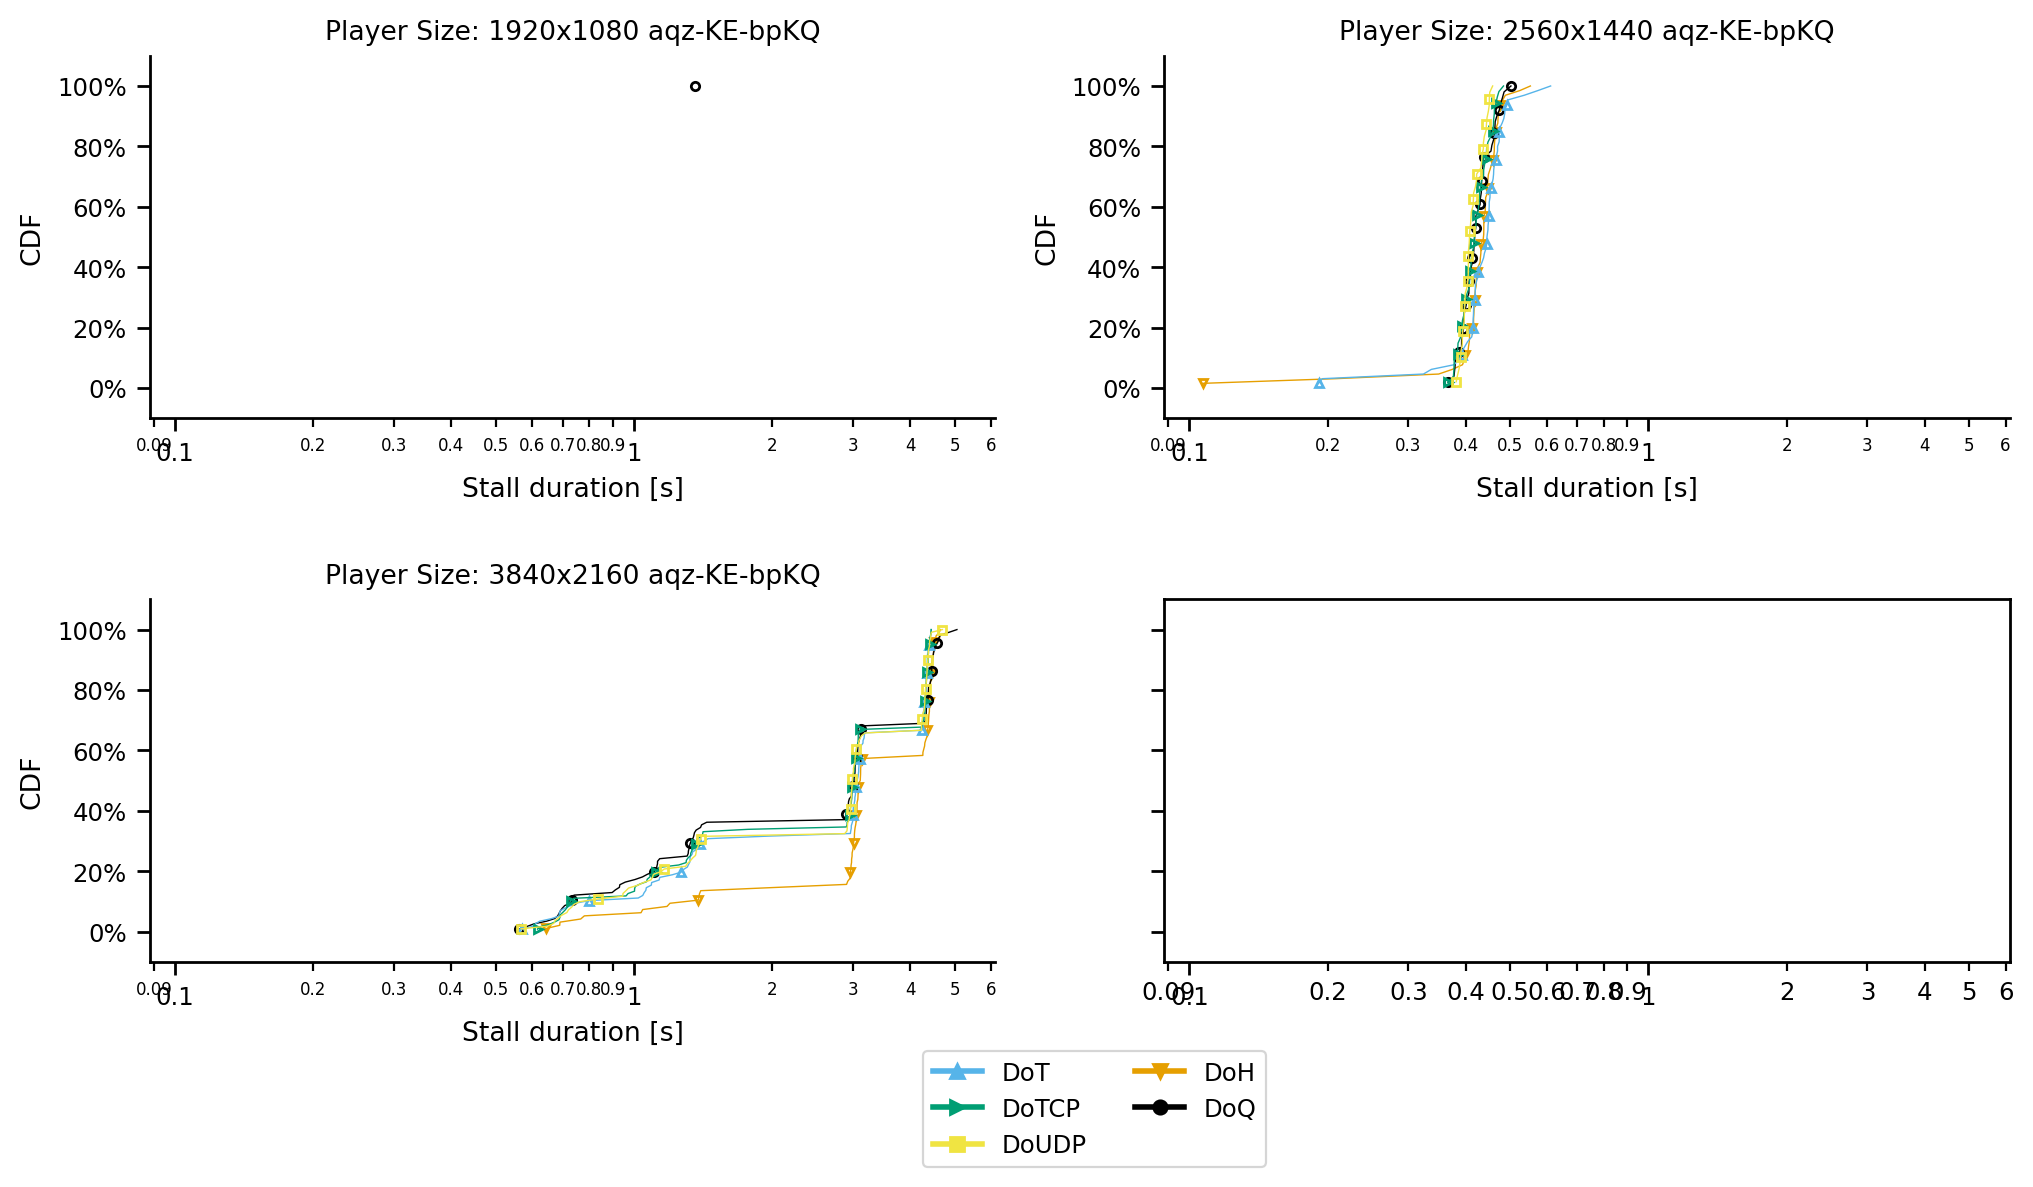

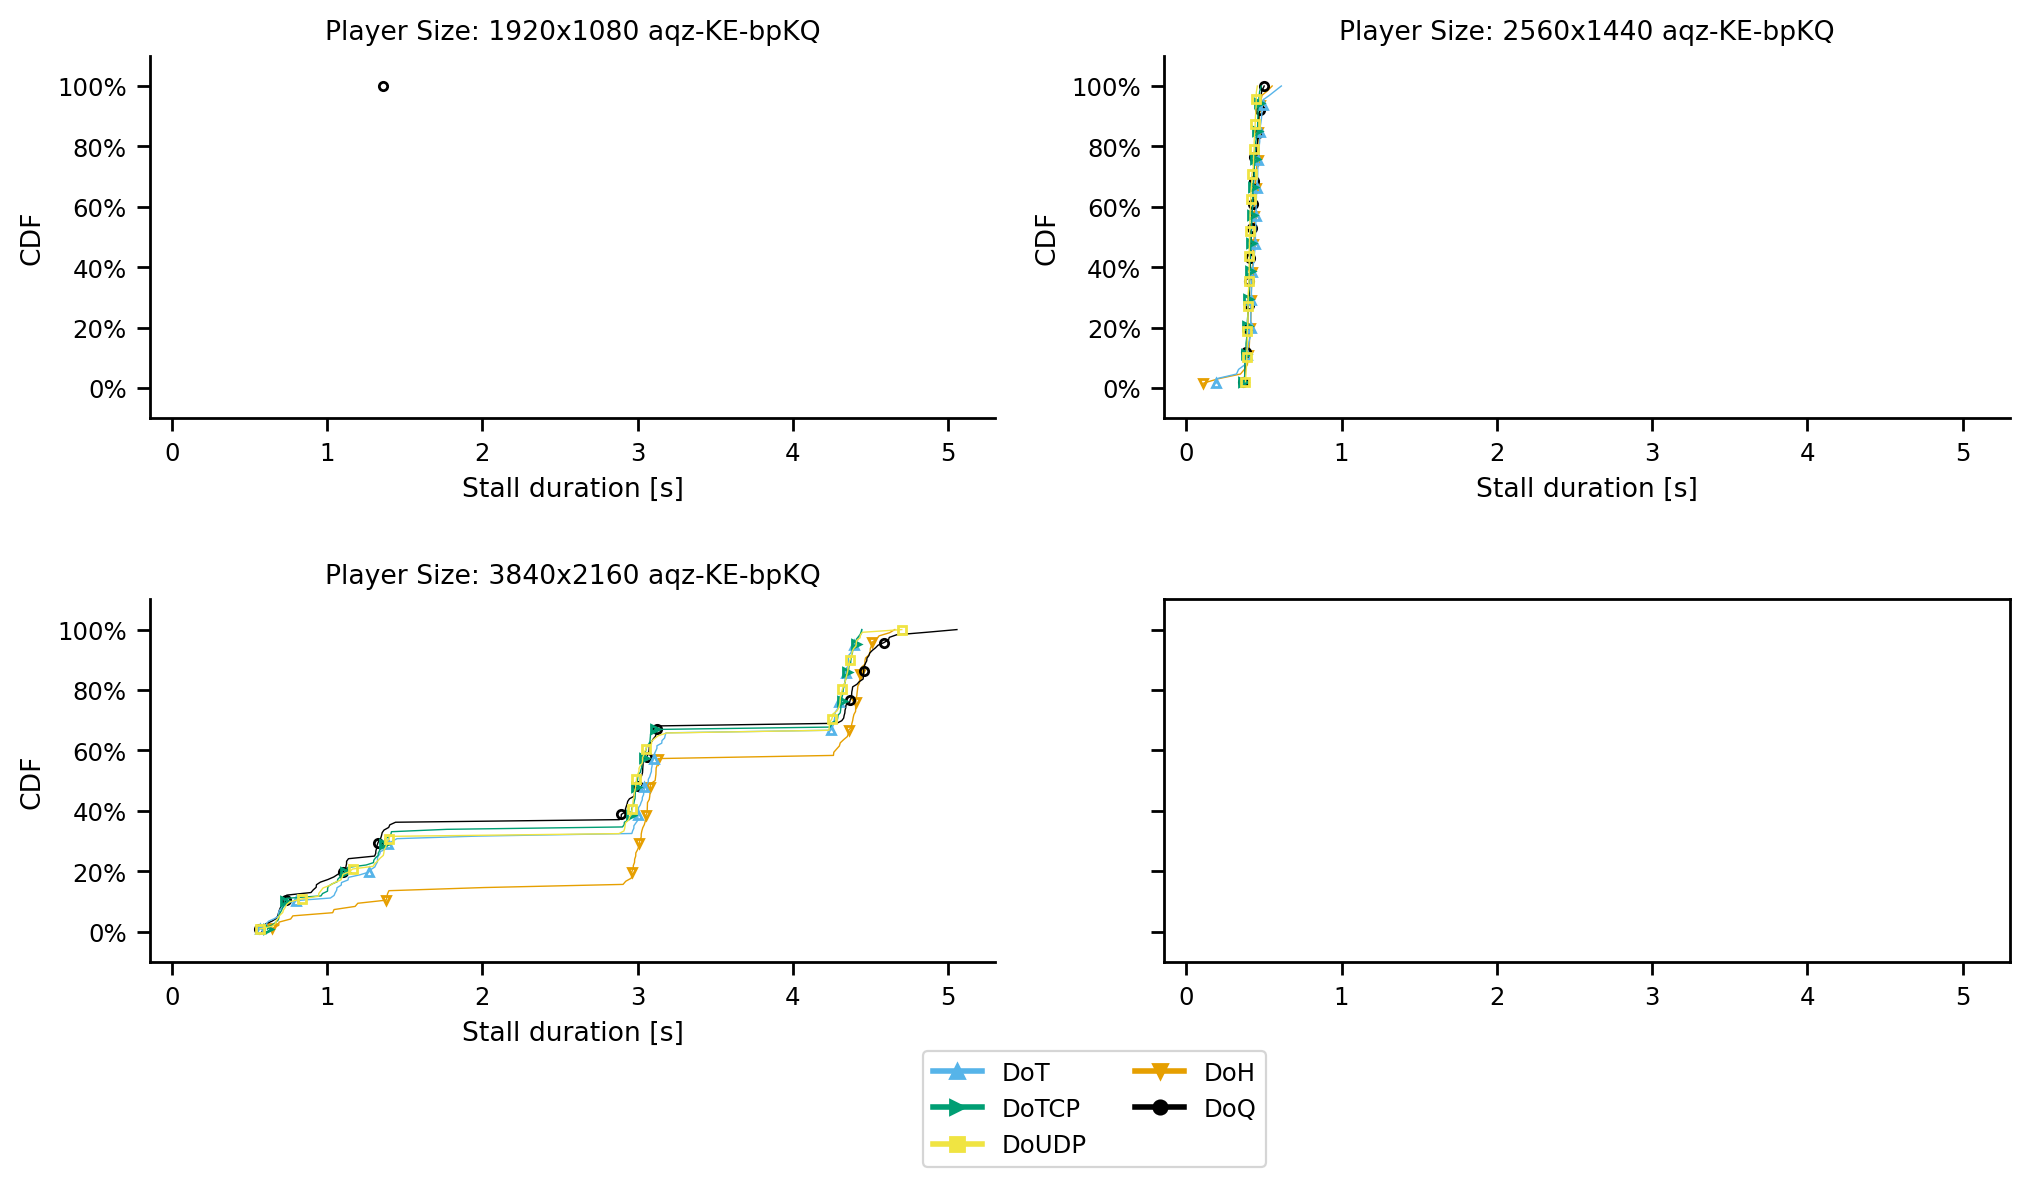

In [232]:
draw_cdf_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

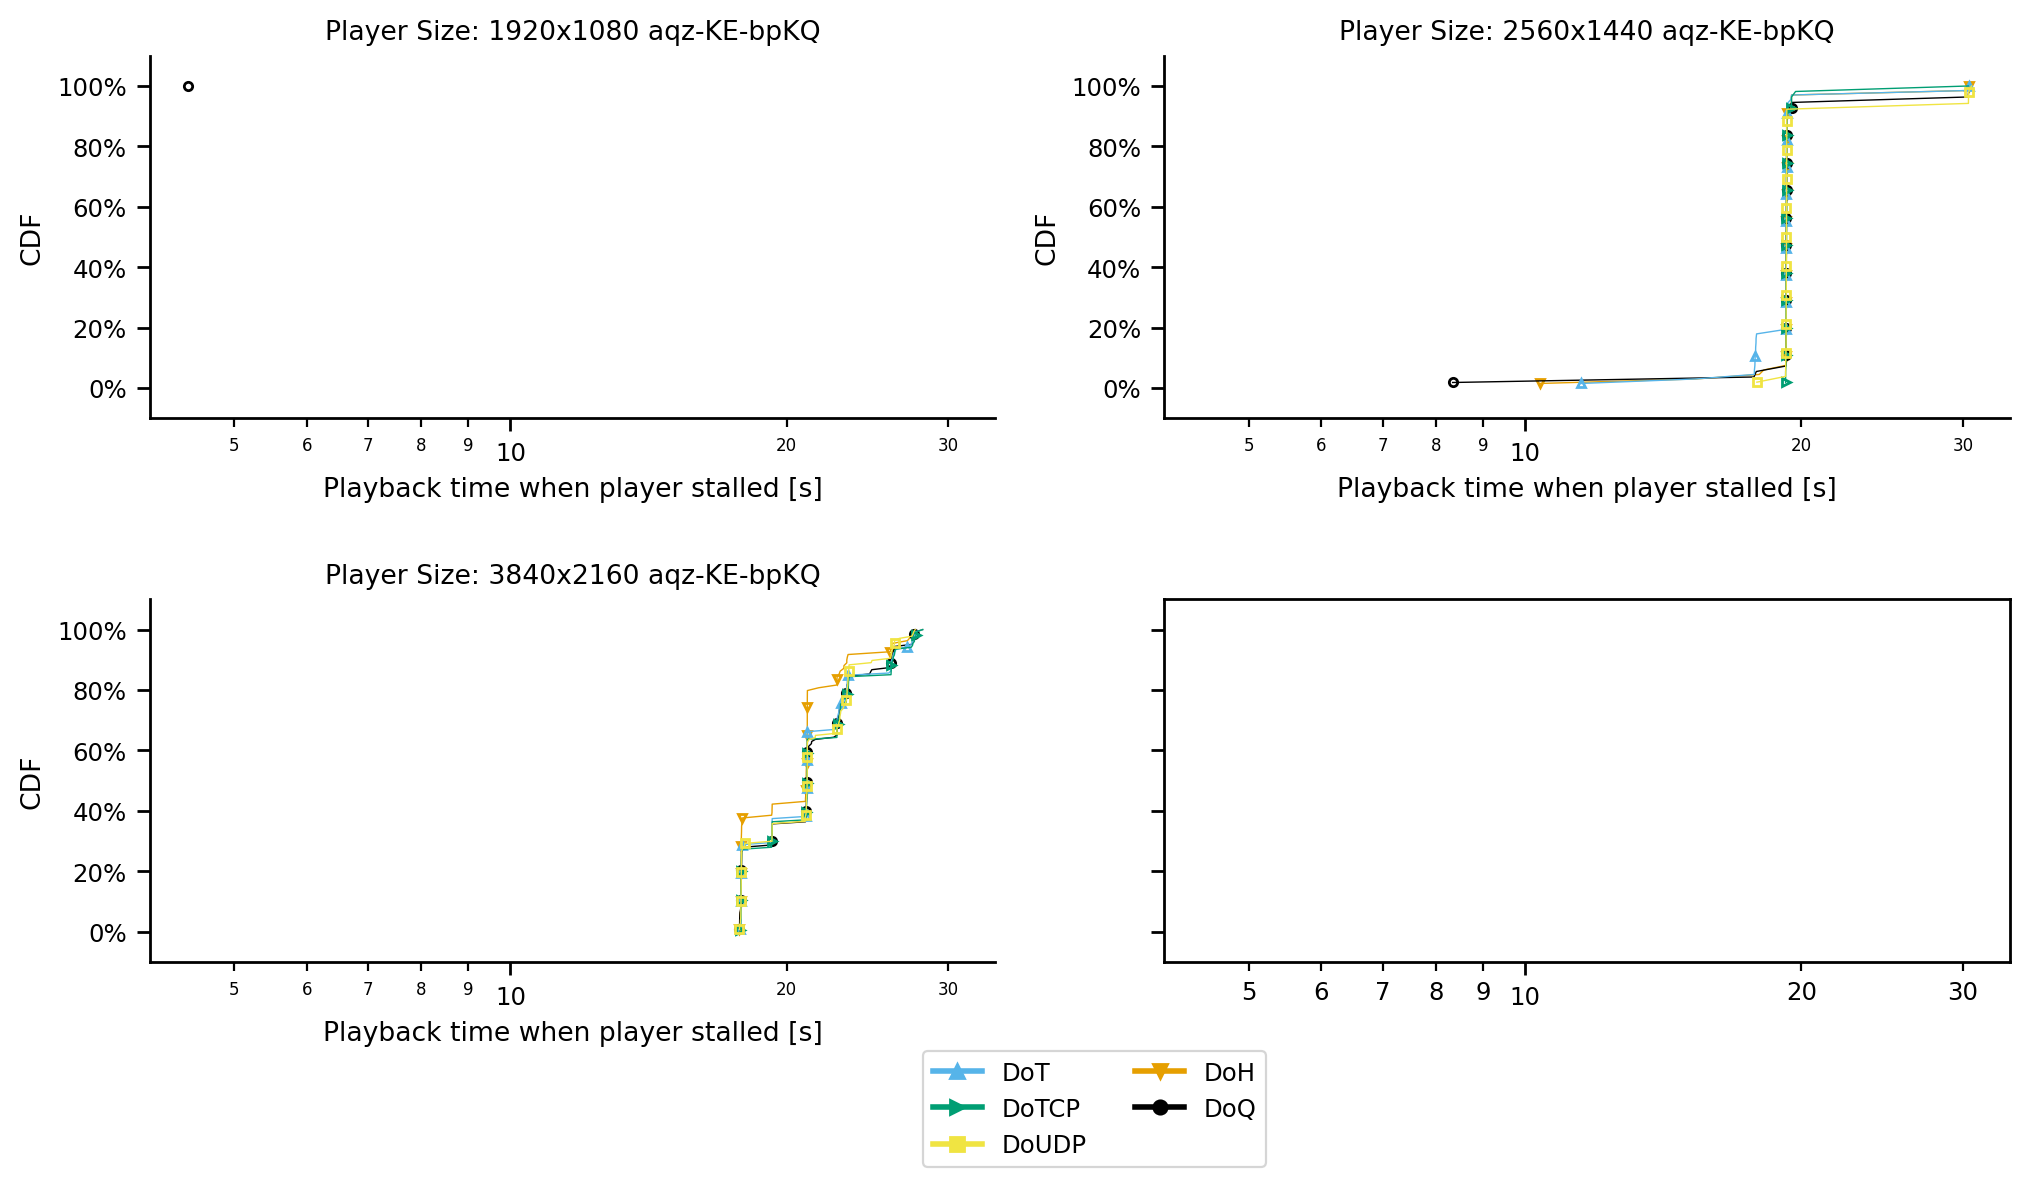

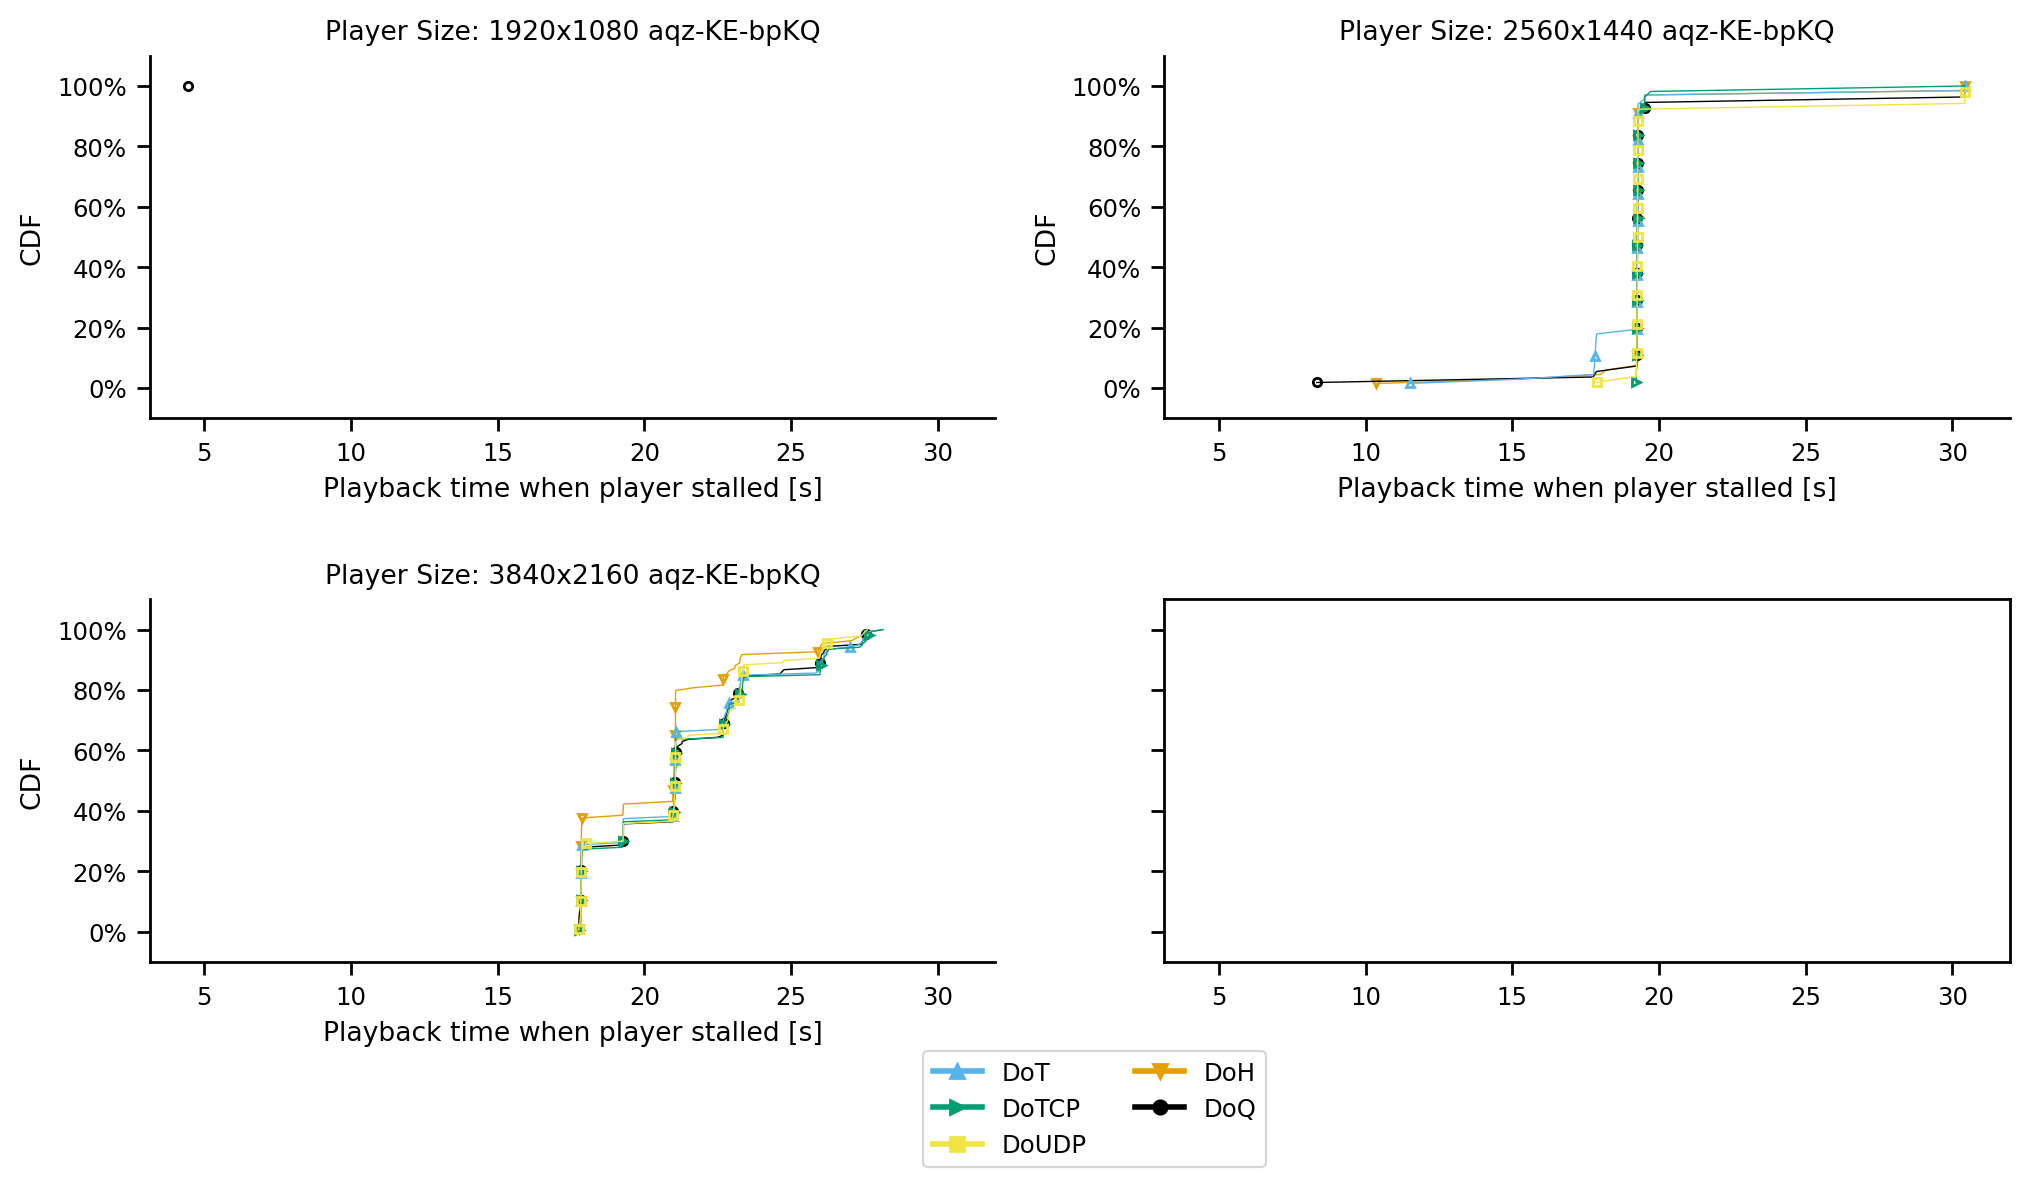

In [233]:
draw_cdf_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

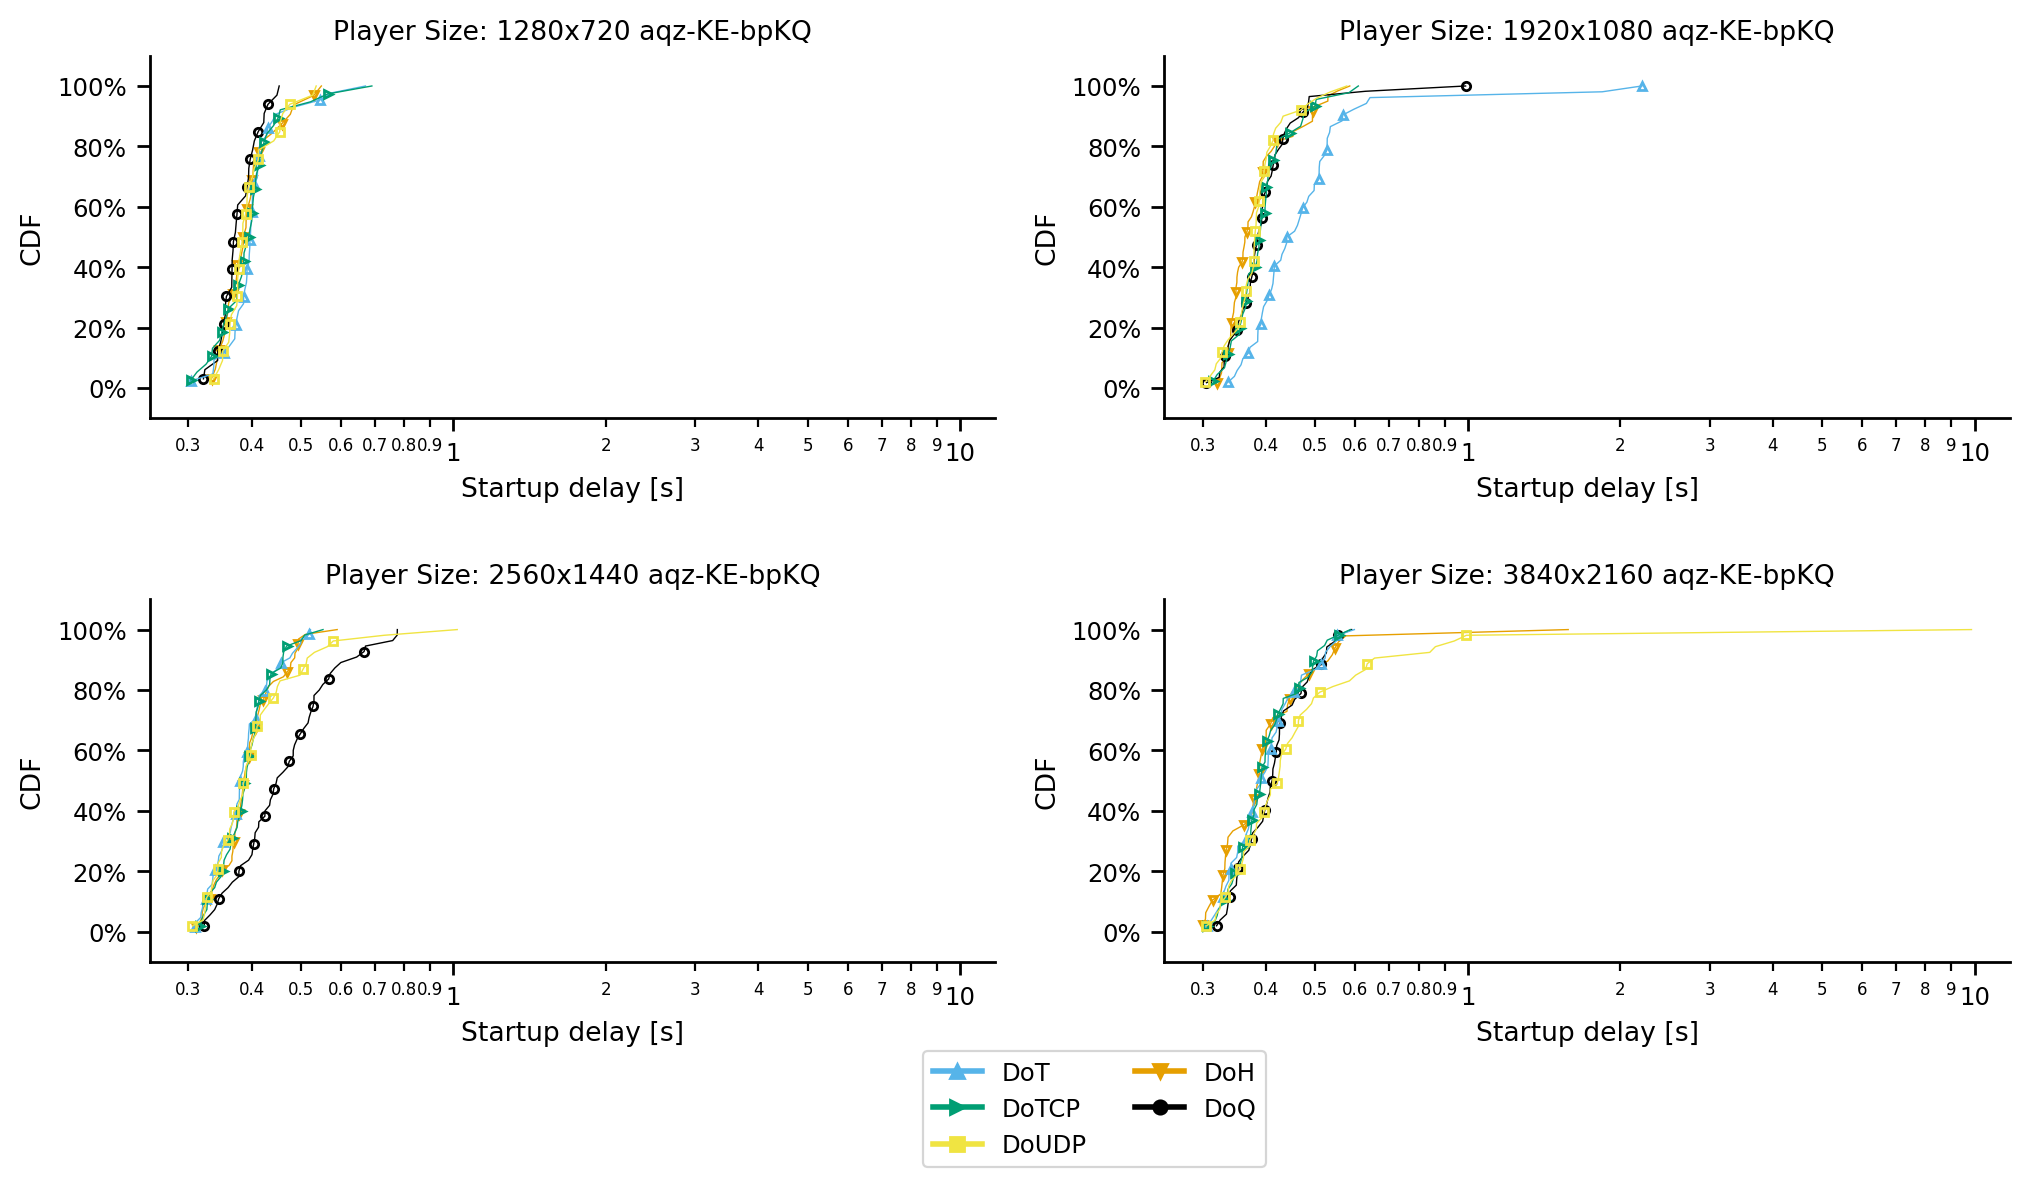

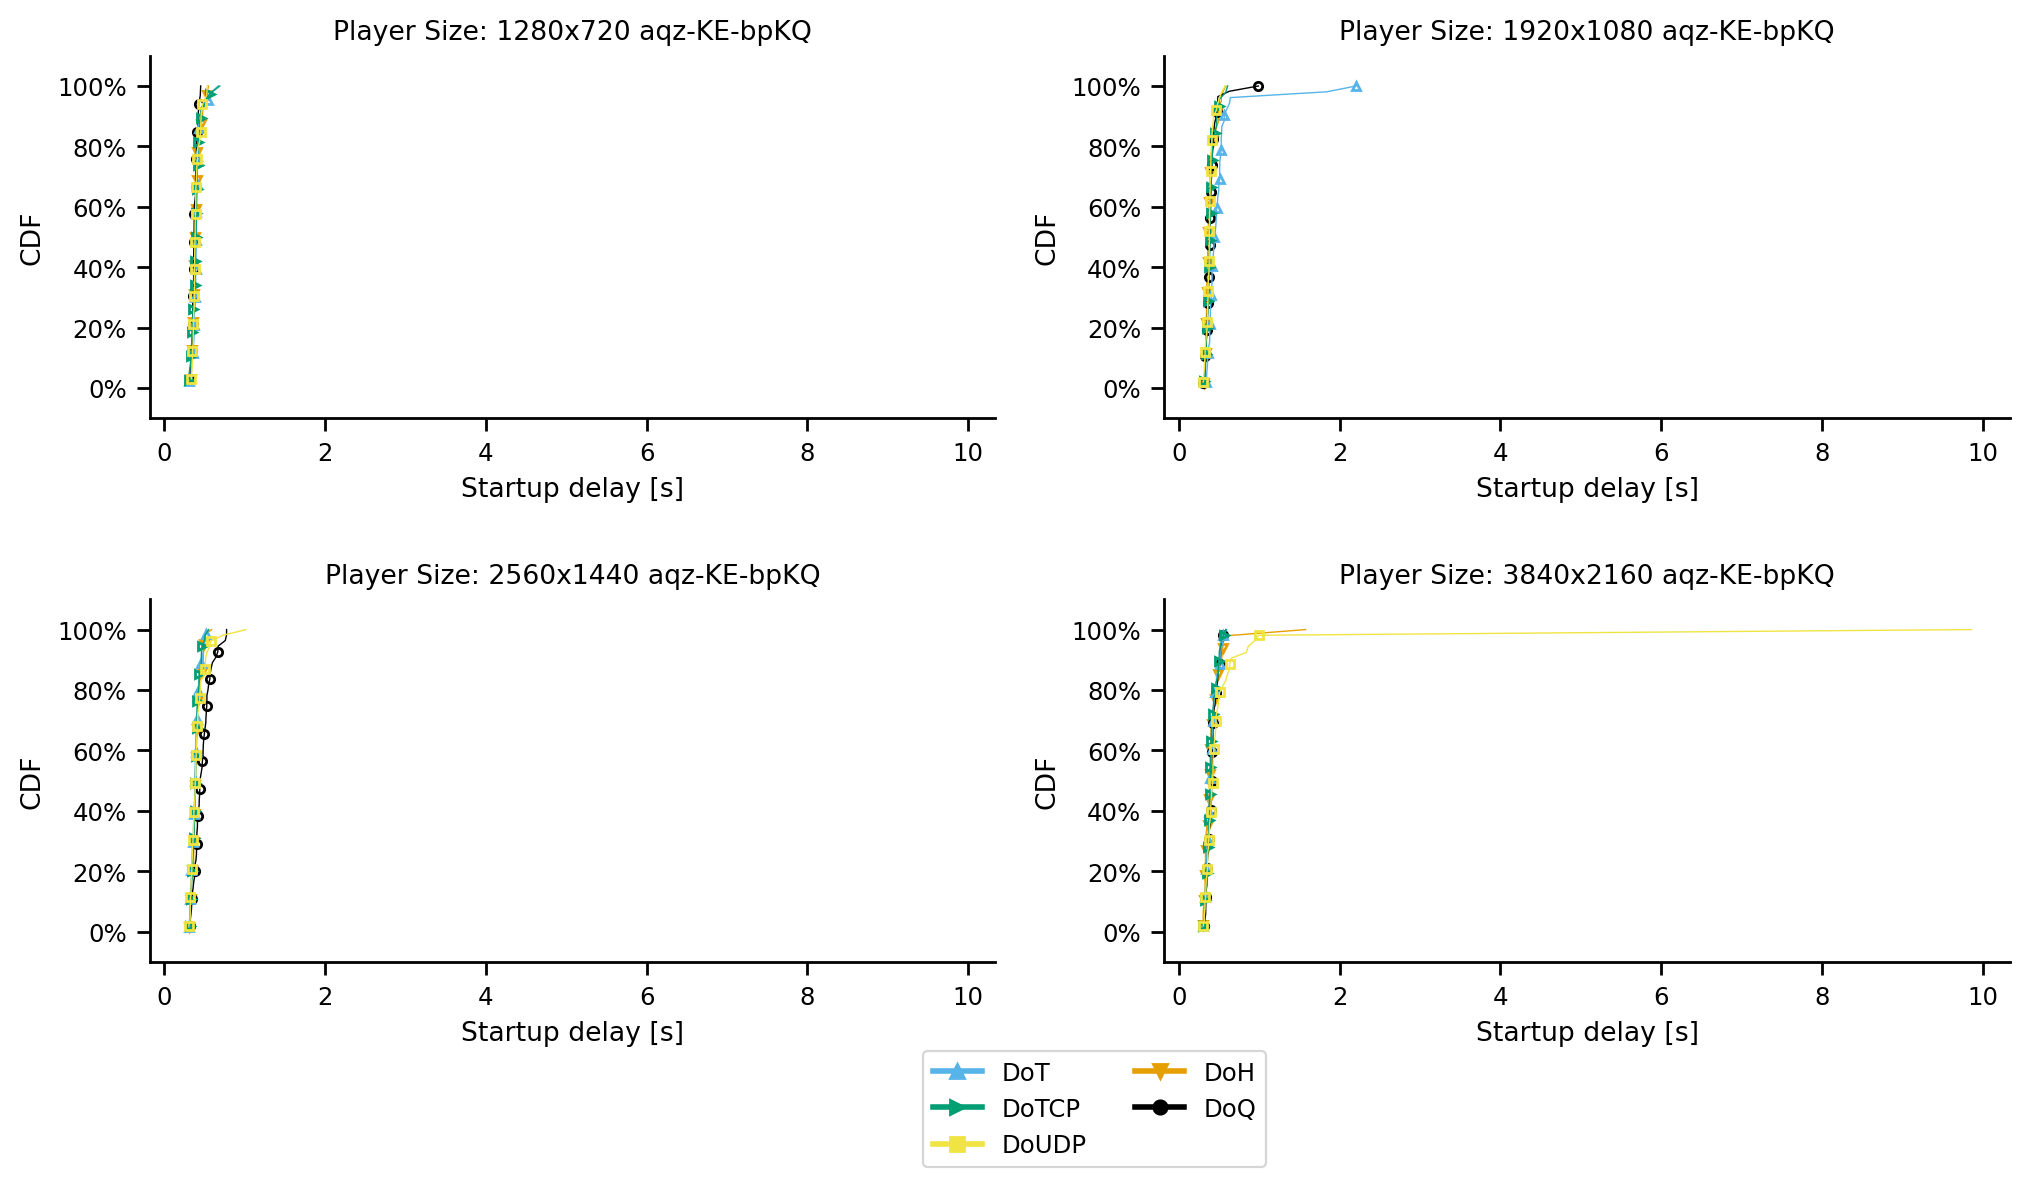

In [234]:
draw_cdf_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.1,1])

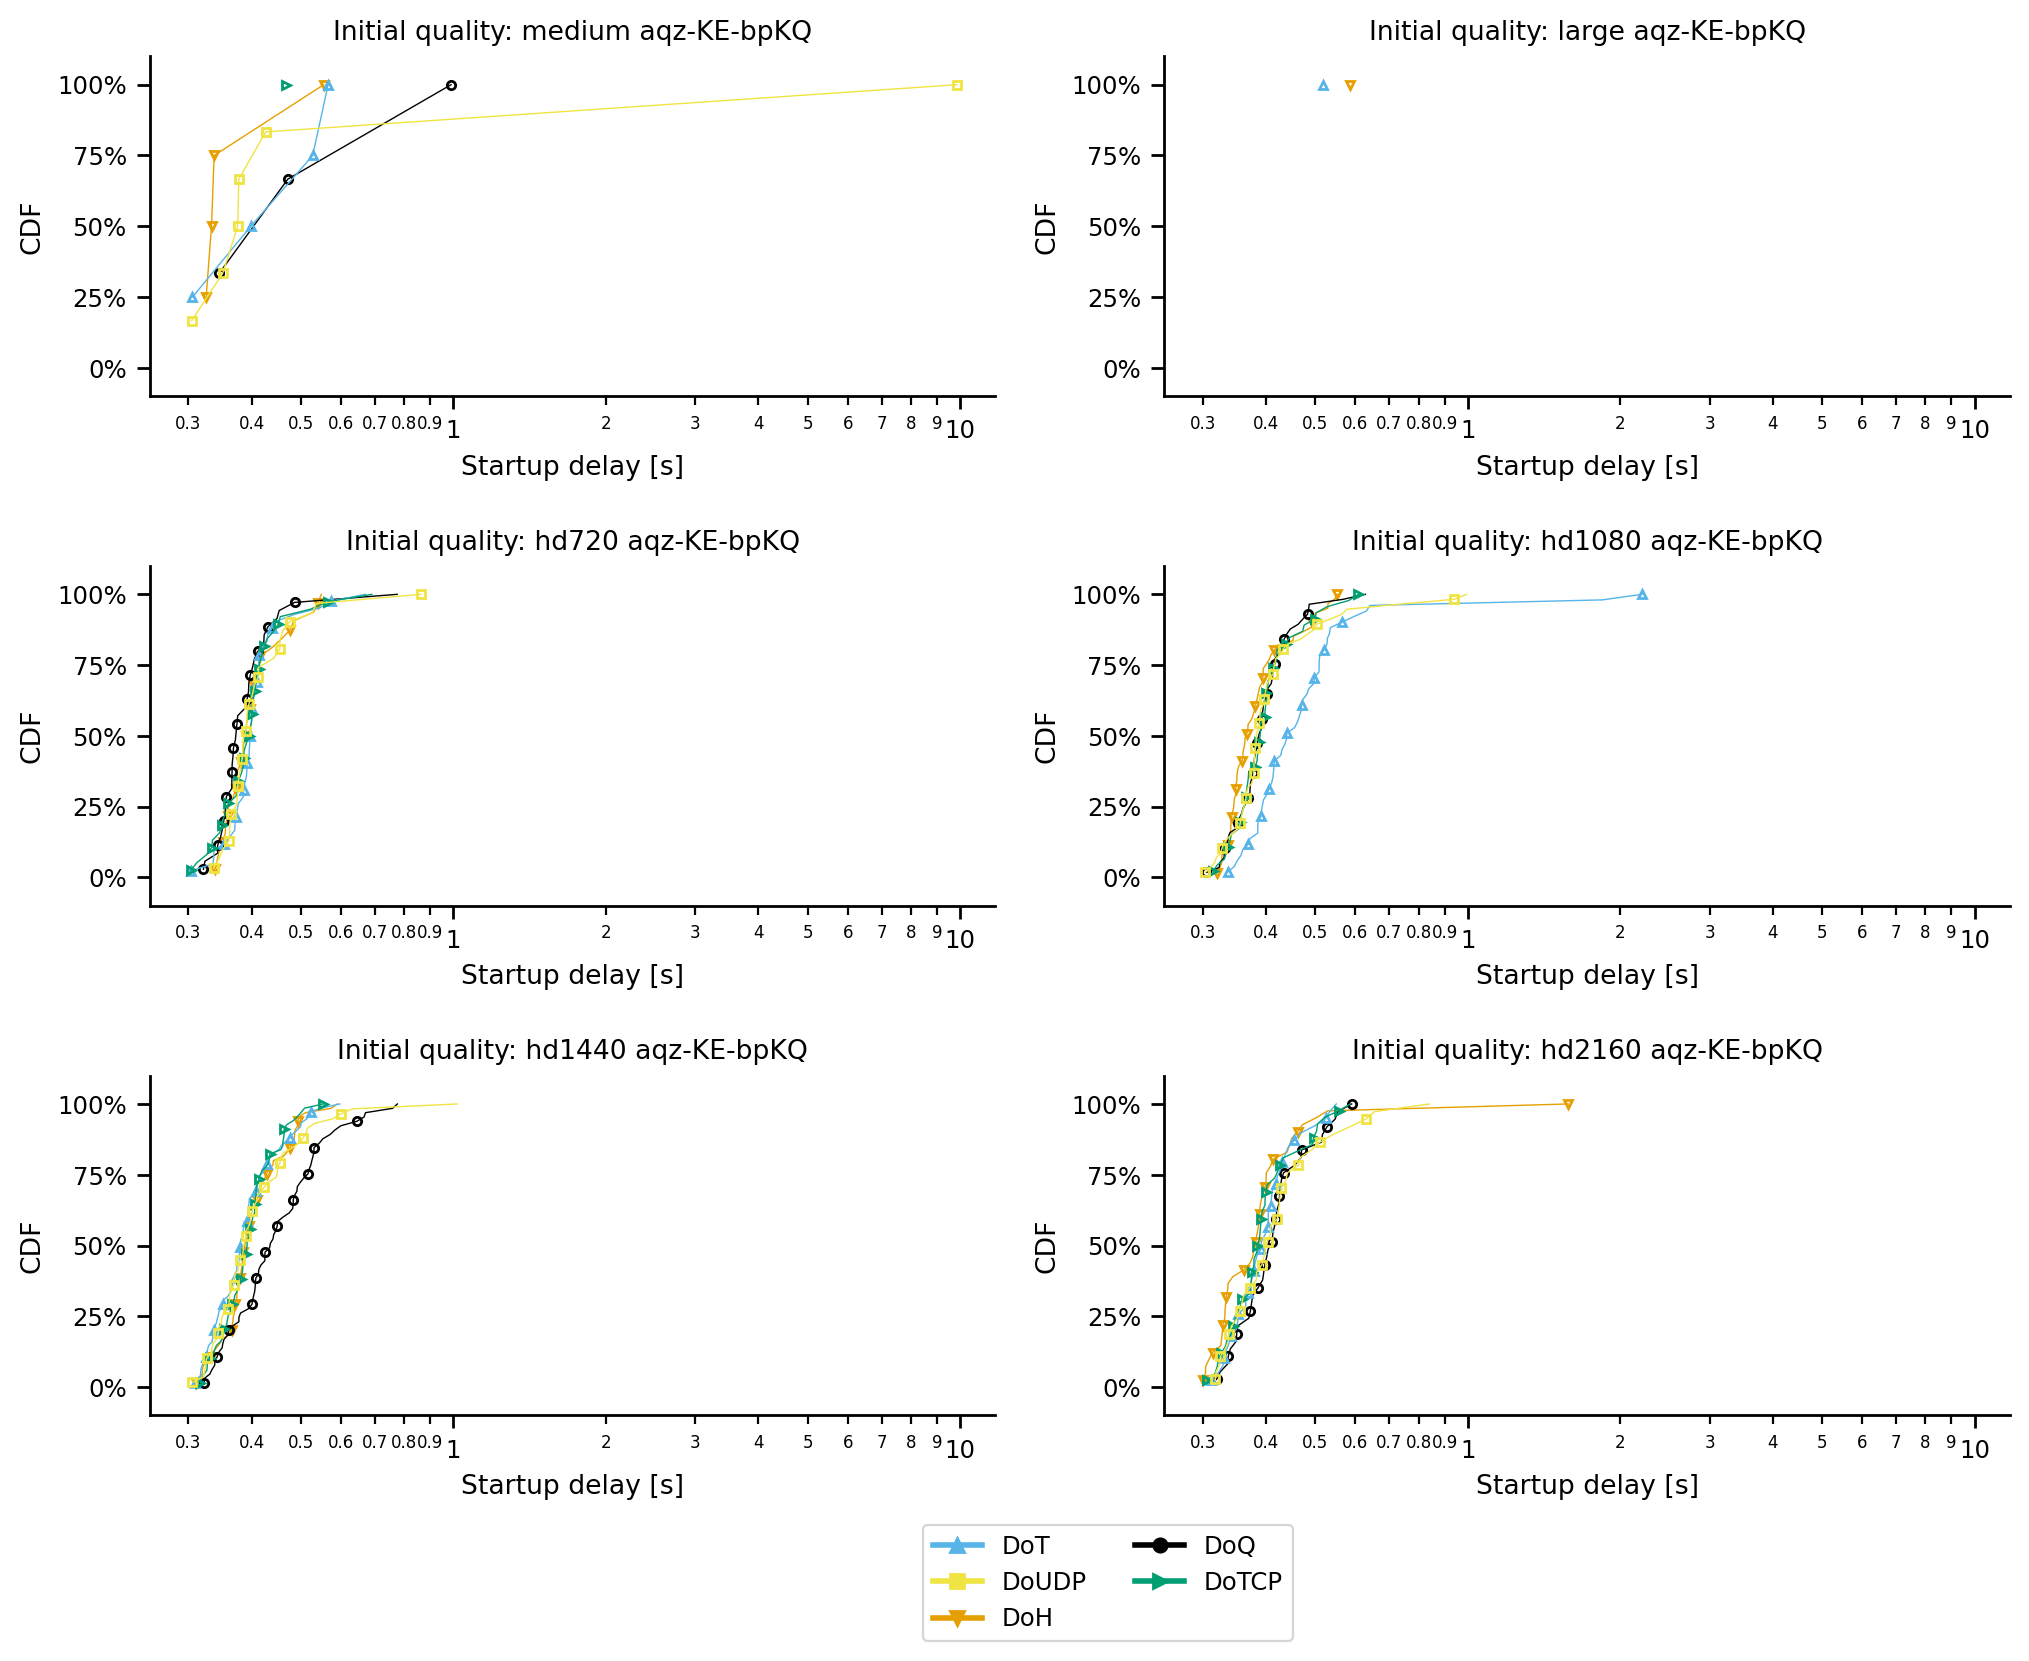

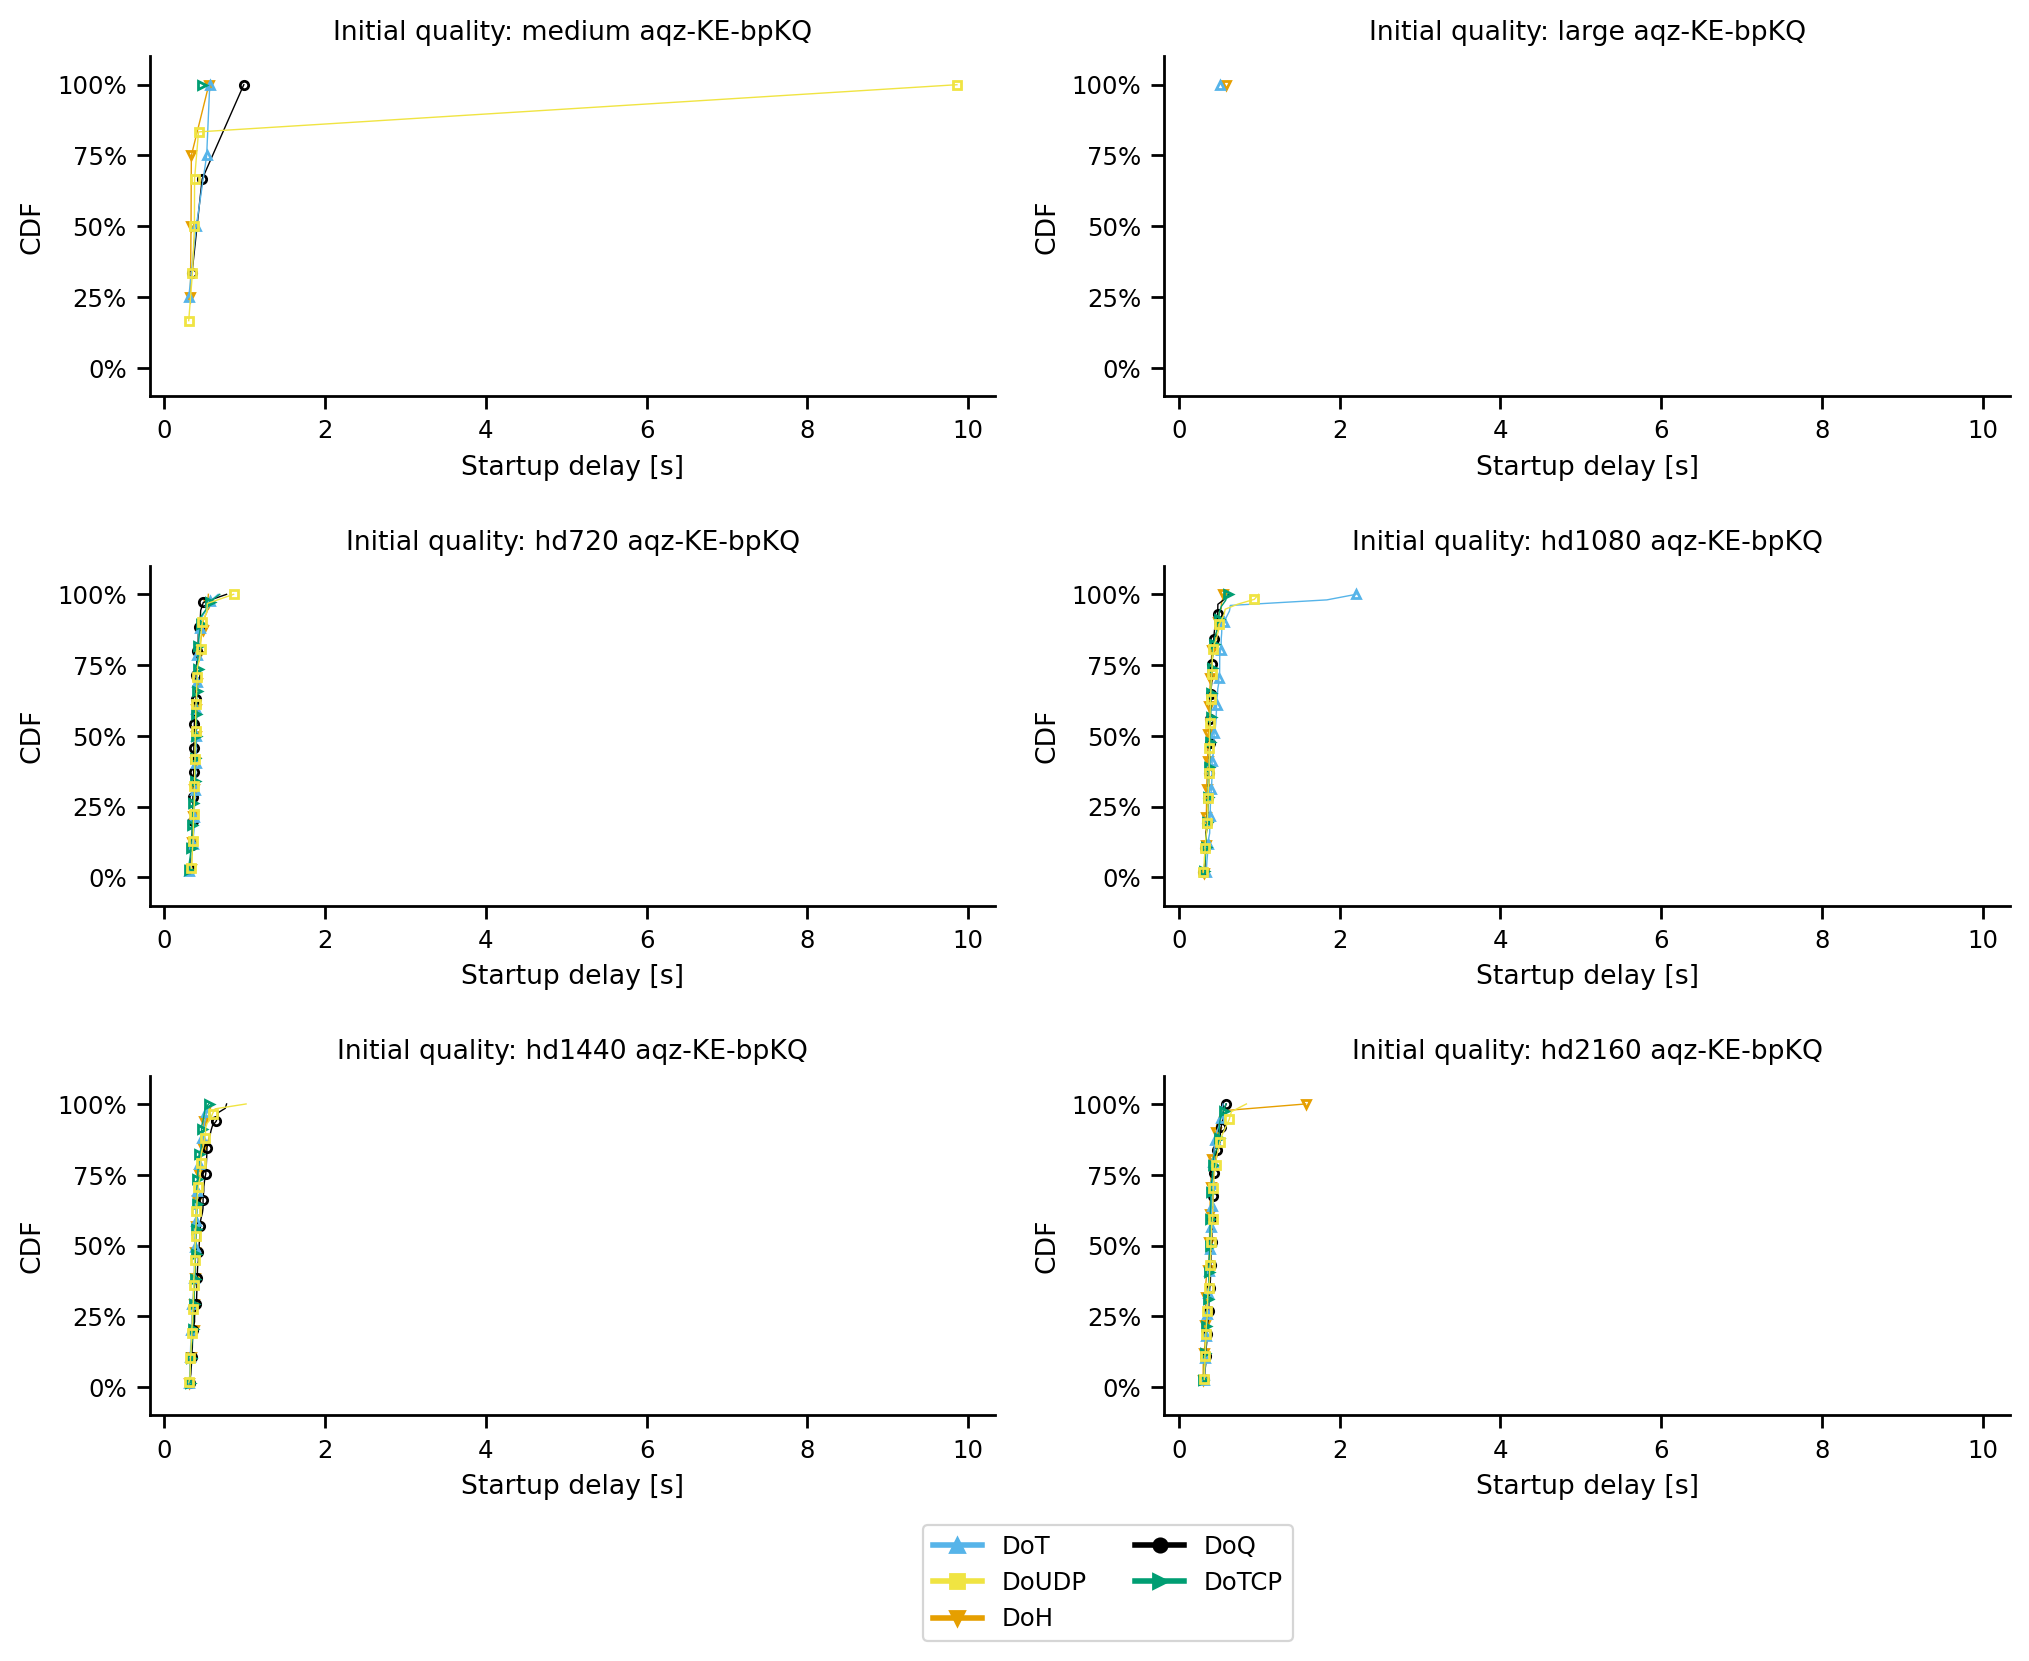

In [235]:
draw_cdf_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.1,1])

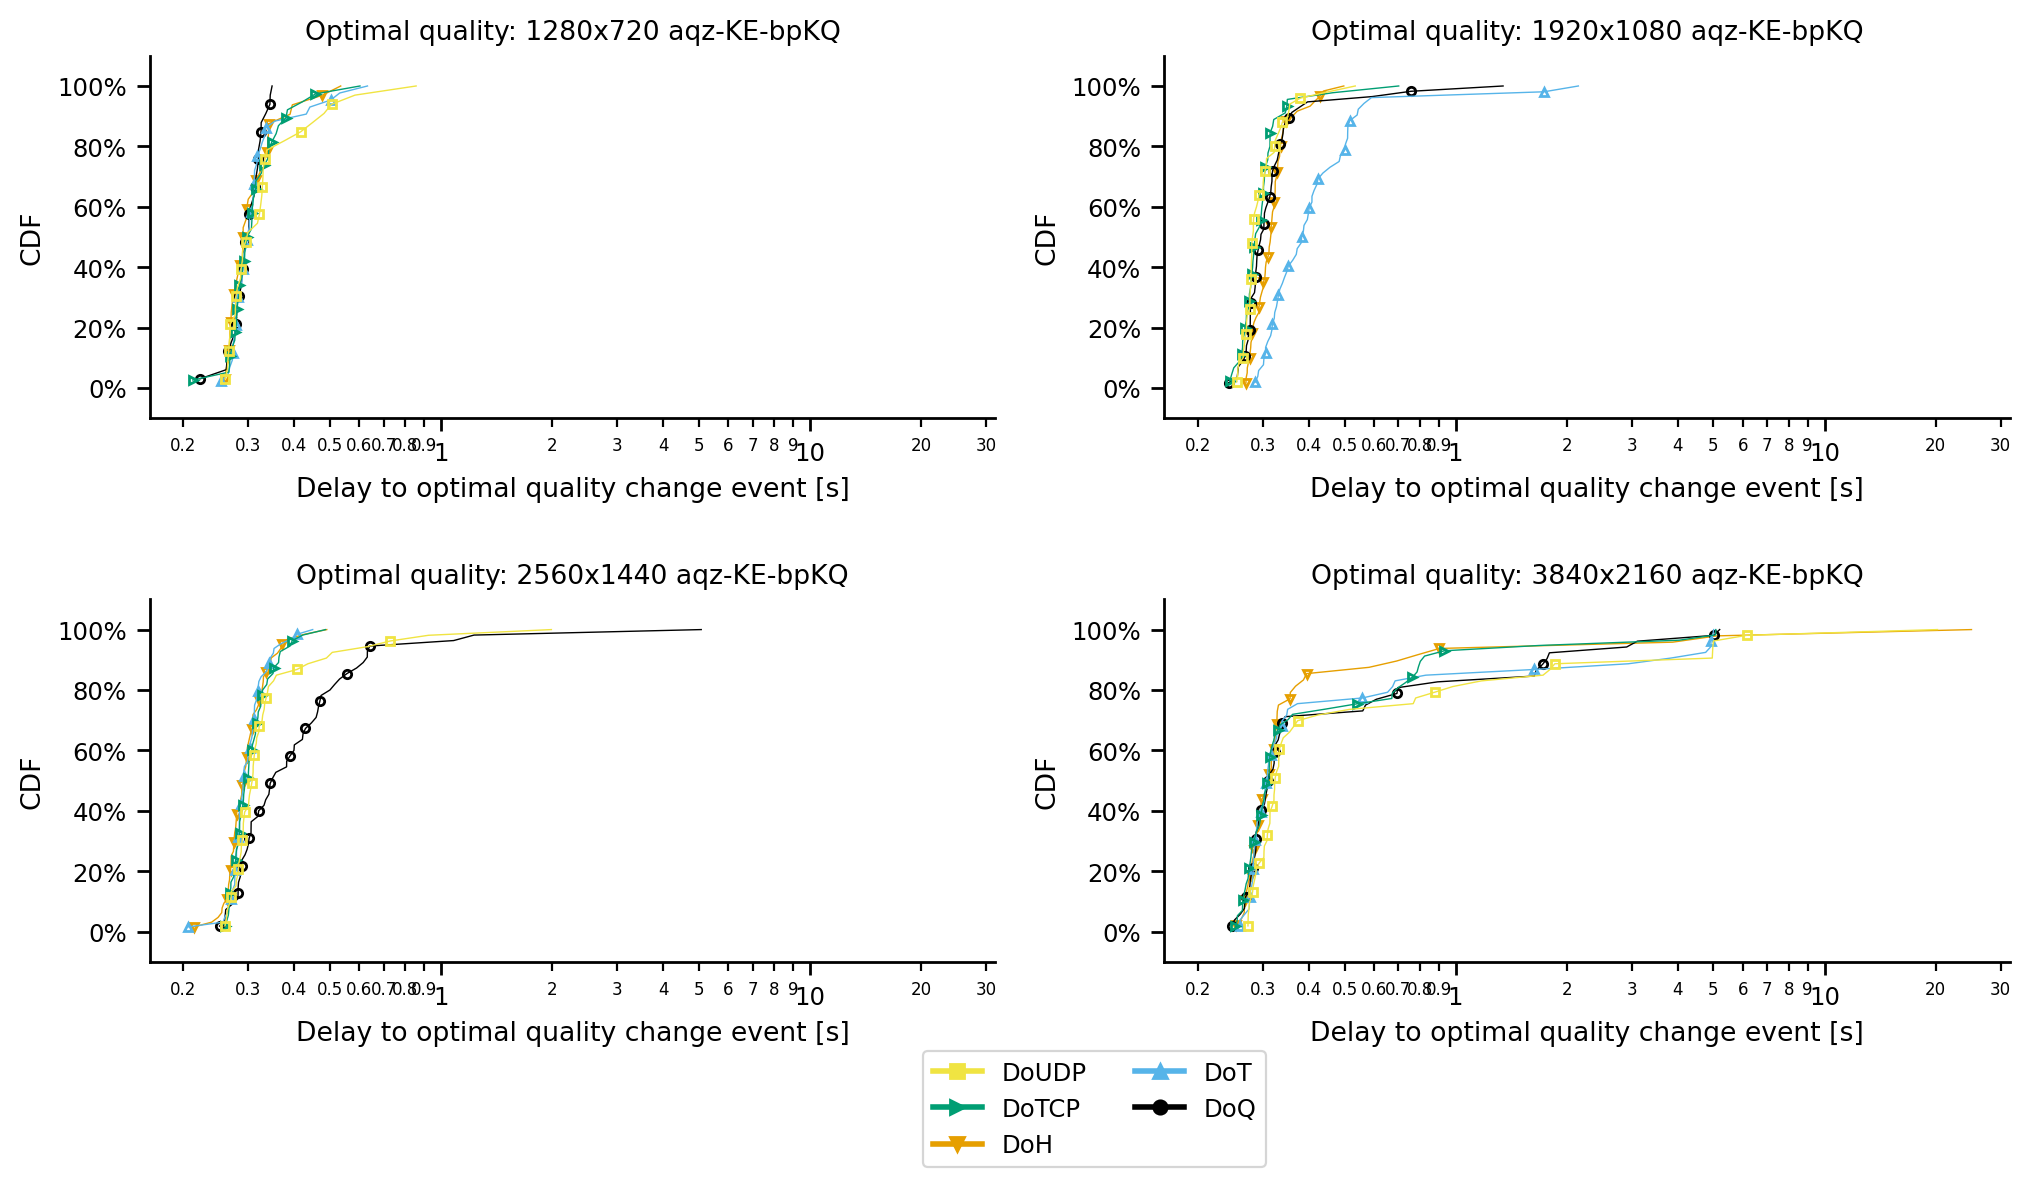

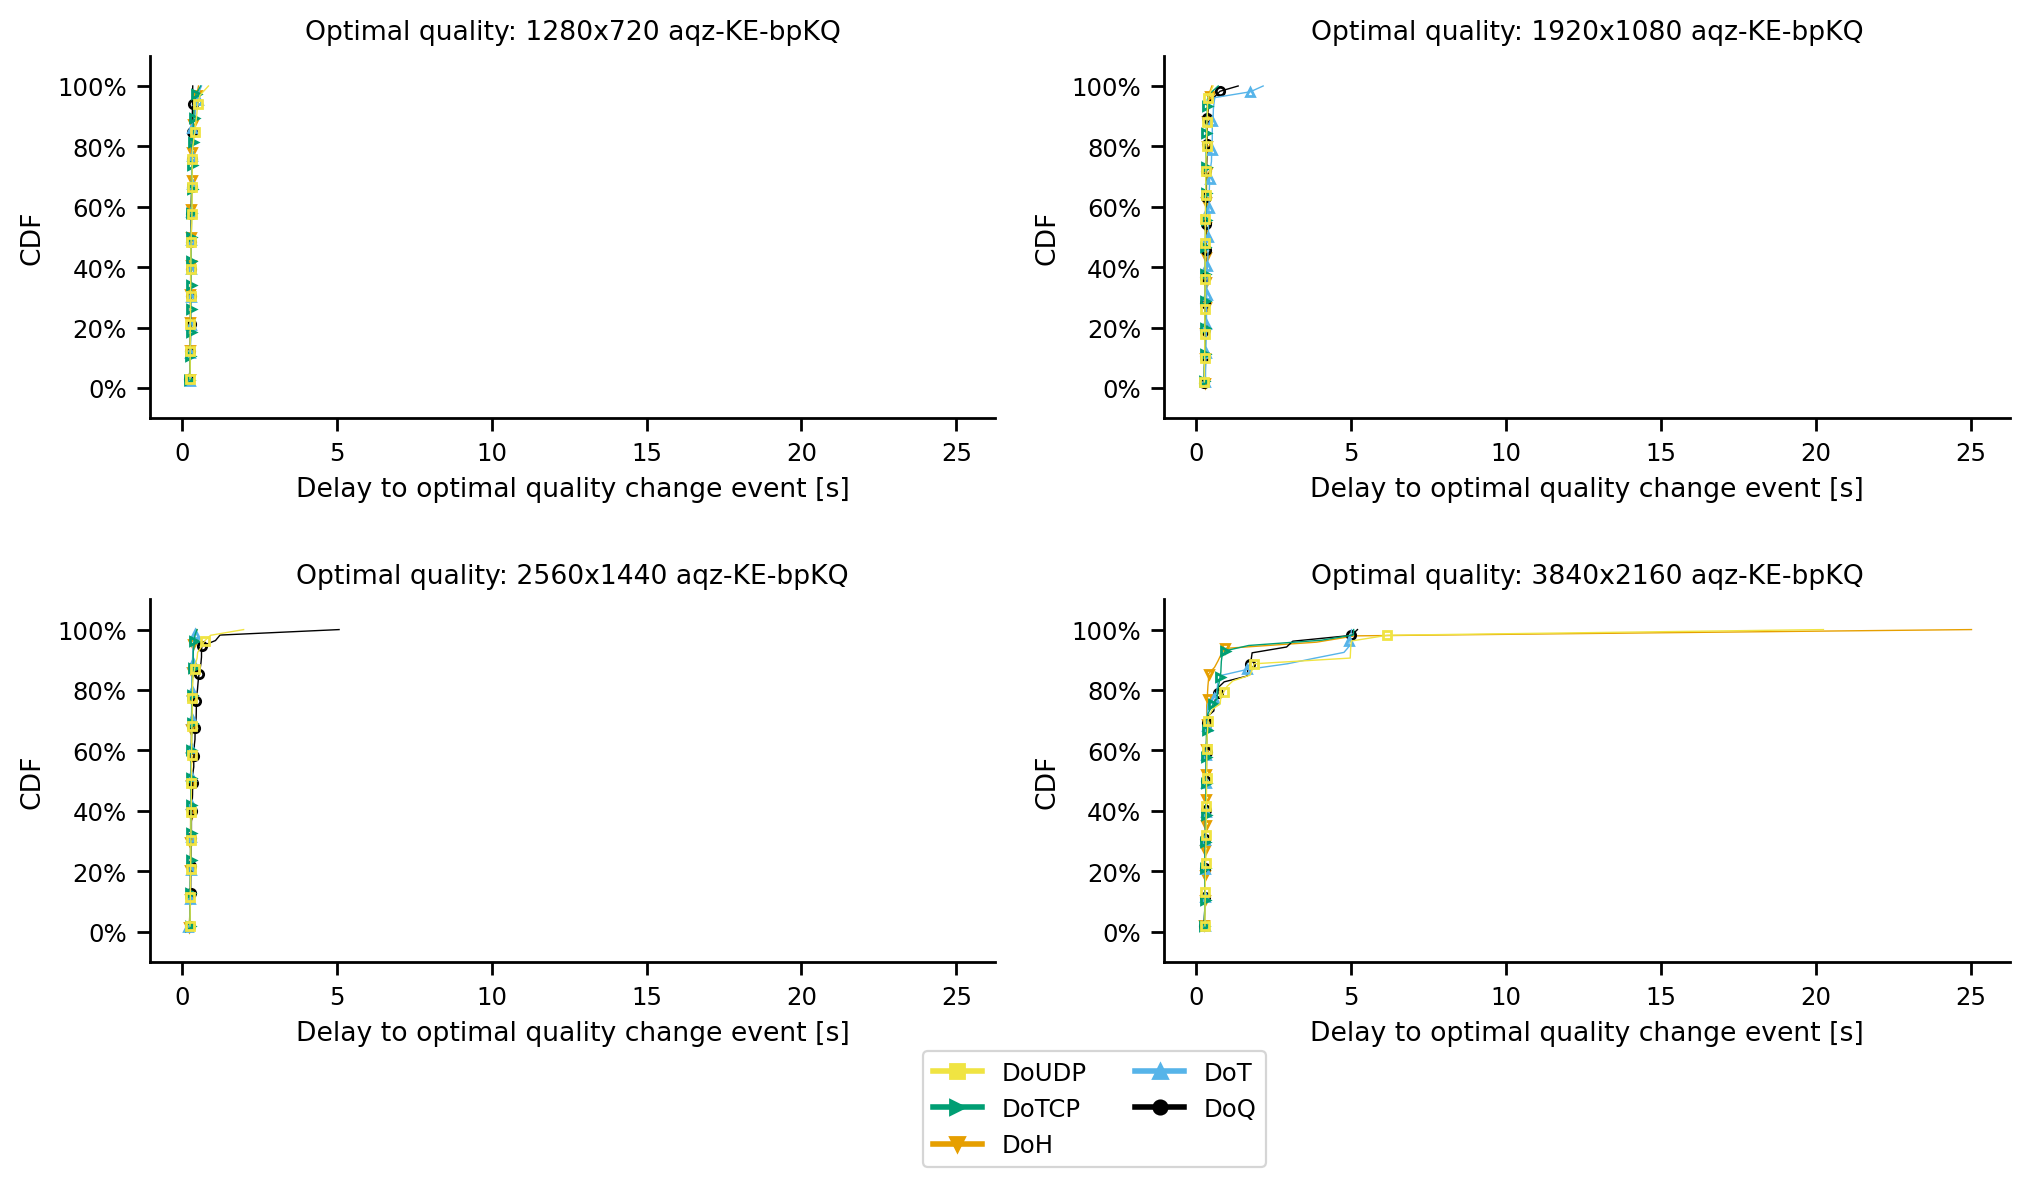

In [236]:
draw_cdf_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [237]:
def draw_boxplot_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                    if df_[col_outer_groupby_].nunique() > 1:
                        fig, axs = plt.subplots(num_rows, 2, sharex='all', figsize=(12,6*num_rows))#, sharey='all')
                        fig.subplots_adjust(hspace=.2, wspace=.3)
                        for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        #for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                            lnwidth = .5
                            mrksize = 3
                            df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                            #hue=
                            
                            boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                            showfliers=False, order=y_order,
                            color='white',
                            meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                            sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                            
                            if log:
                                ax.set_xscale('log')
                            
                            
                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel(ylabel)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)

                            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                            ax.grid(b=True, which='both')


                        #if log:
                        #    fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        #else:
                        #    fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

In [238]:
def draw_boxplot(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        fig, ax = plt.subplots(figsize=(6,8))
                        #hue=
                        boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                        showfliers=False, order=y_order,
                        color='white',
                        meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                        sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                        
                        if log:
                            ax.set_xscale('log')
                        
                        
                        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                        ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                        ax.set_xlabel(xlabel)

                        ax.set_ylabel(ylabel)
                        if xlim != [0,0]:
                            ax.set_xlim(xlim)

                        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                        ax.grid(b=True, which='both')


                        #if log:
                        #    fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        #else:
                        #    fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

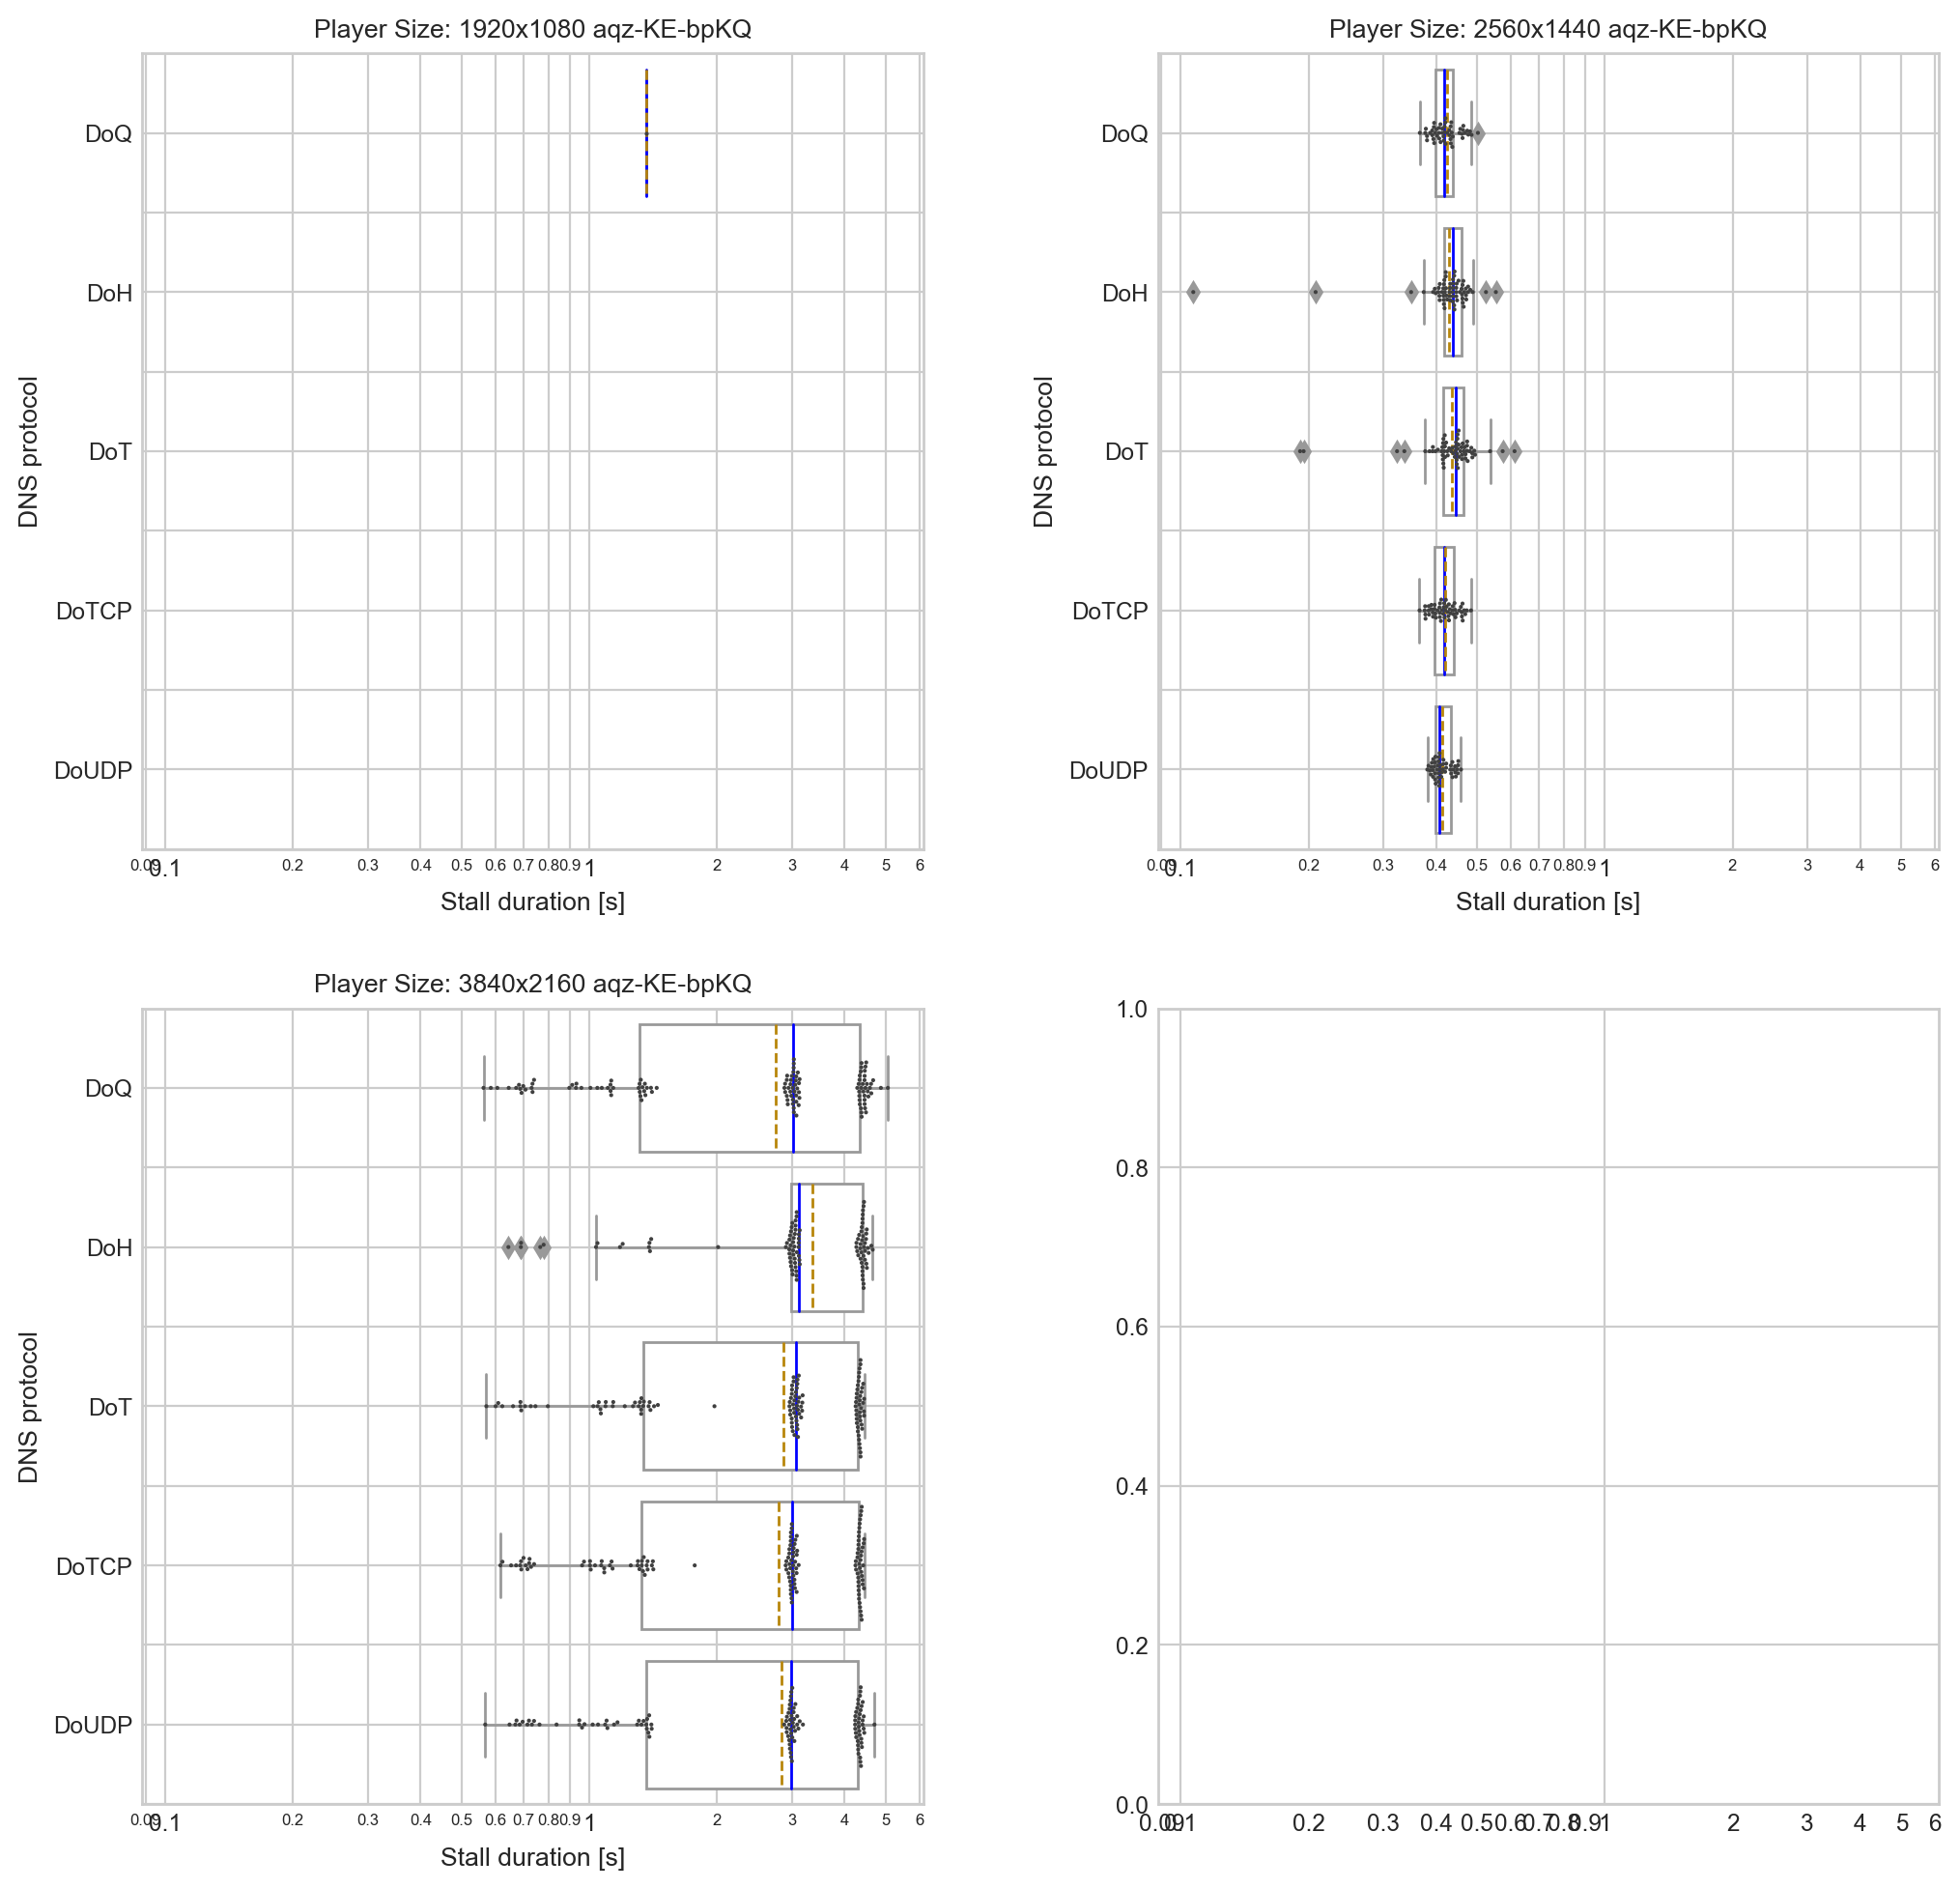

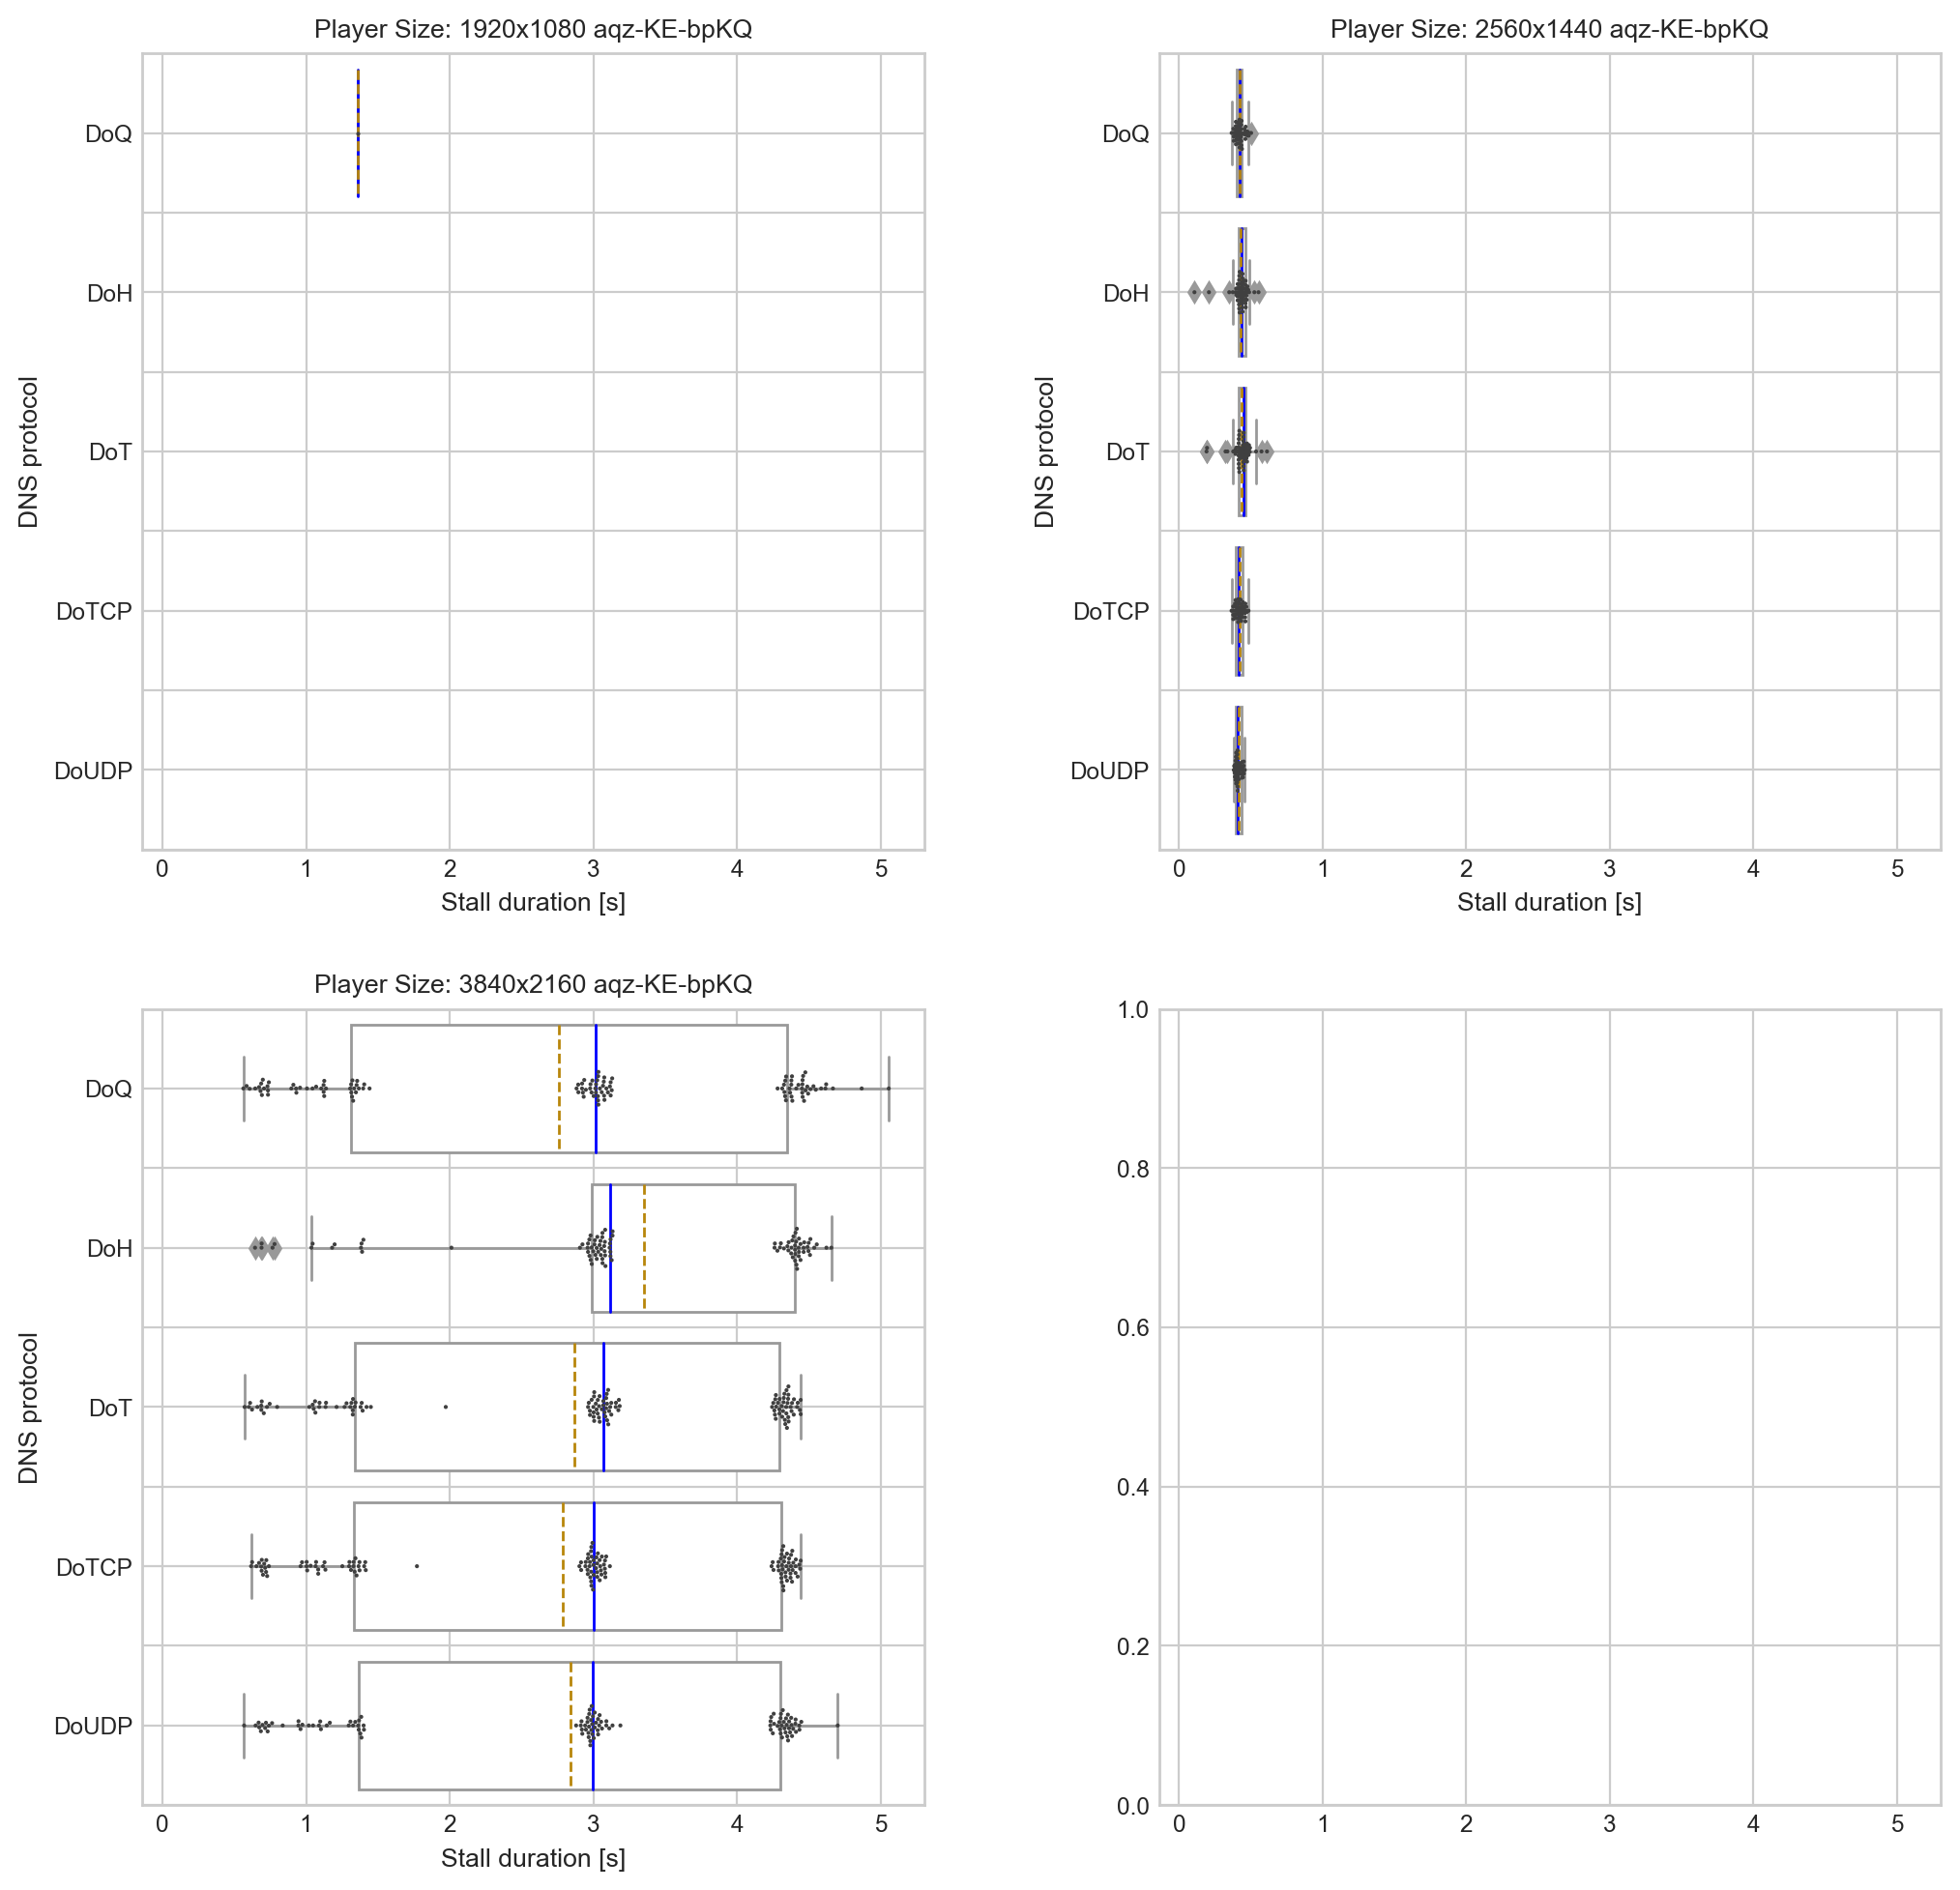

In [239]:
draw_boxplot_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

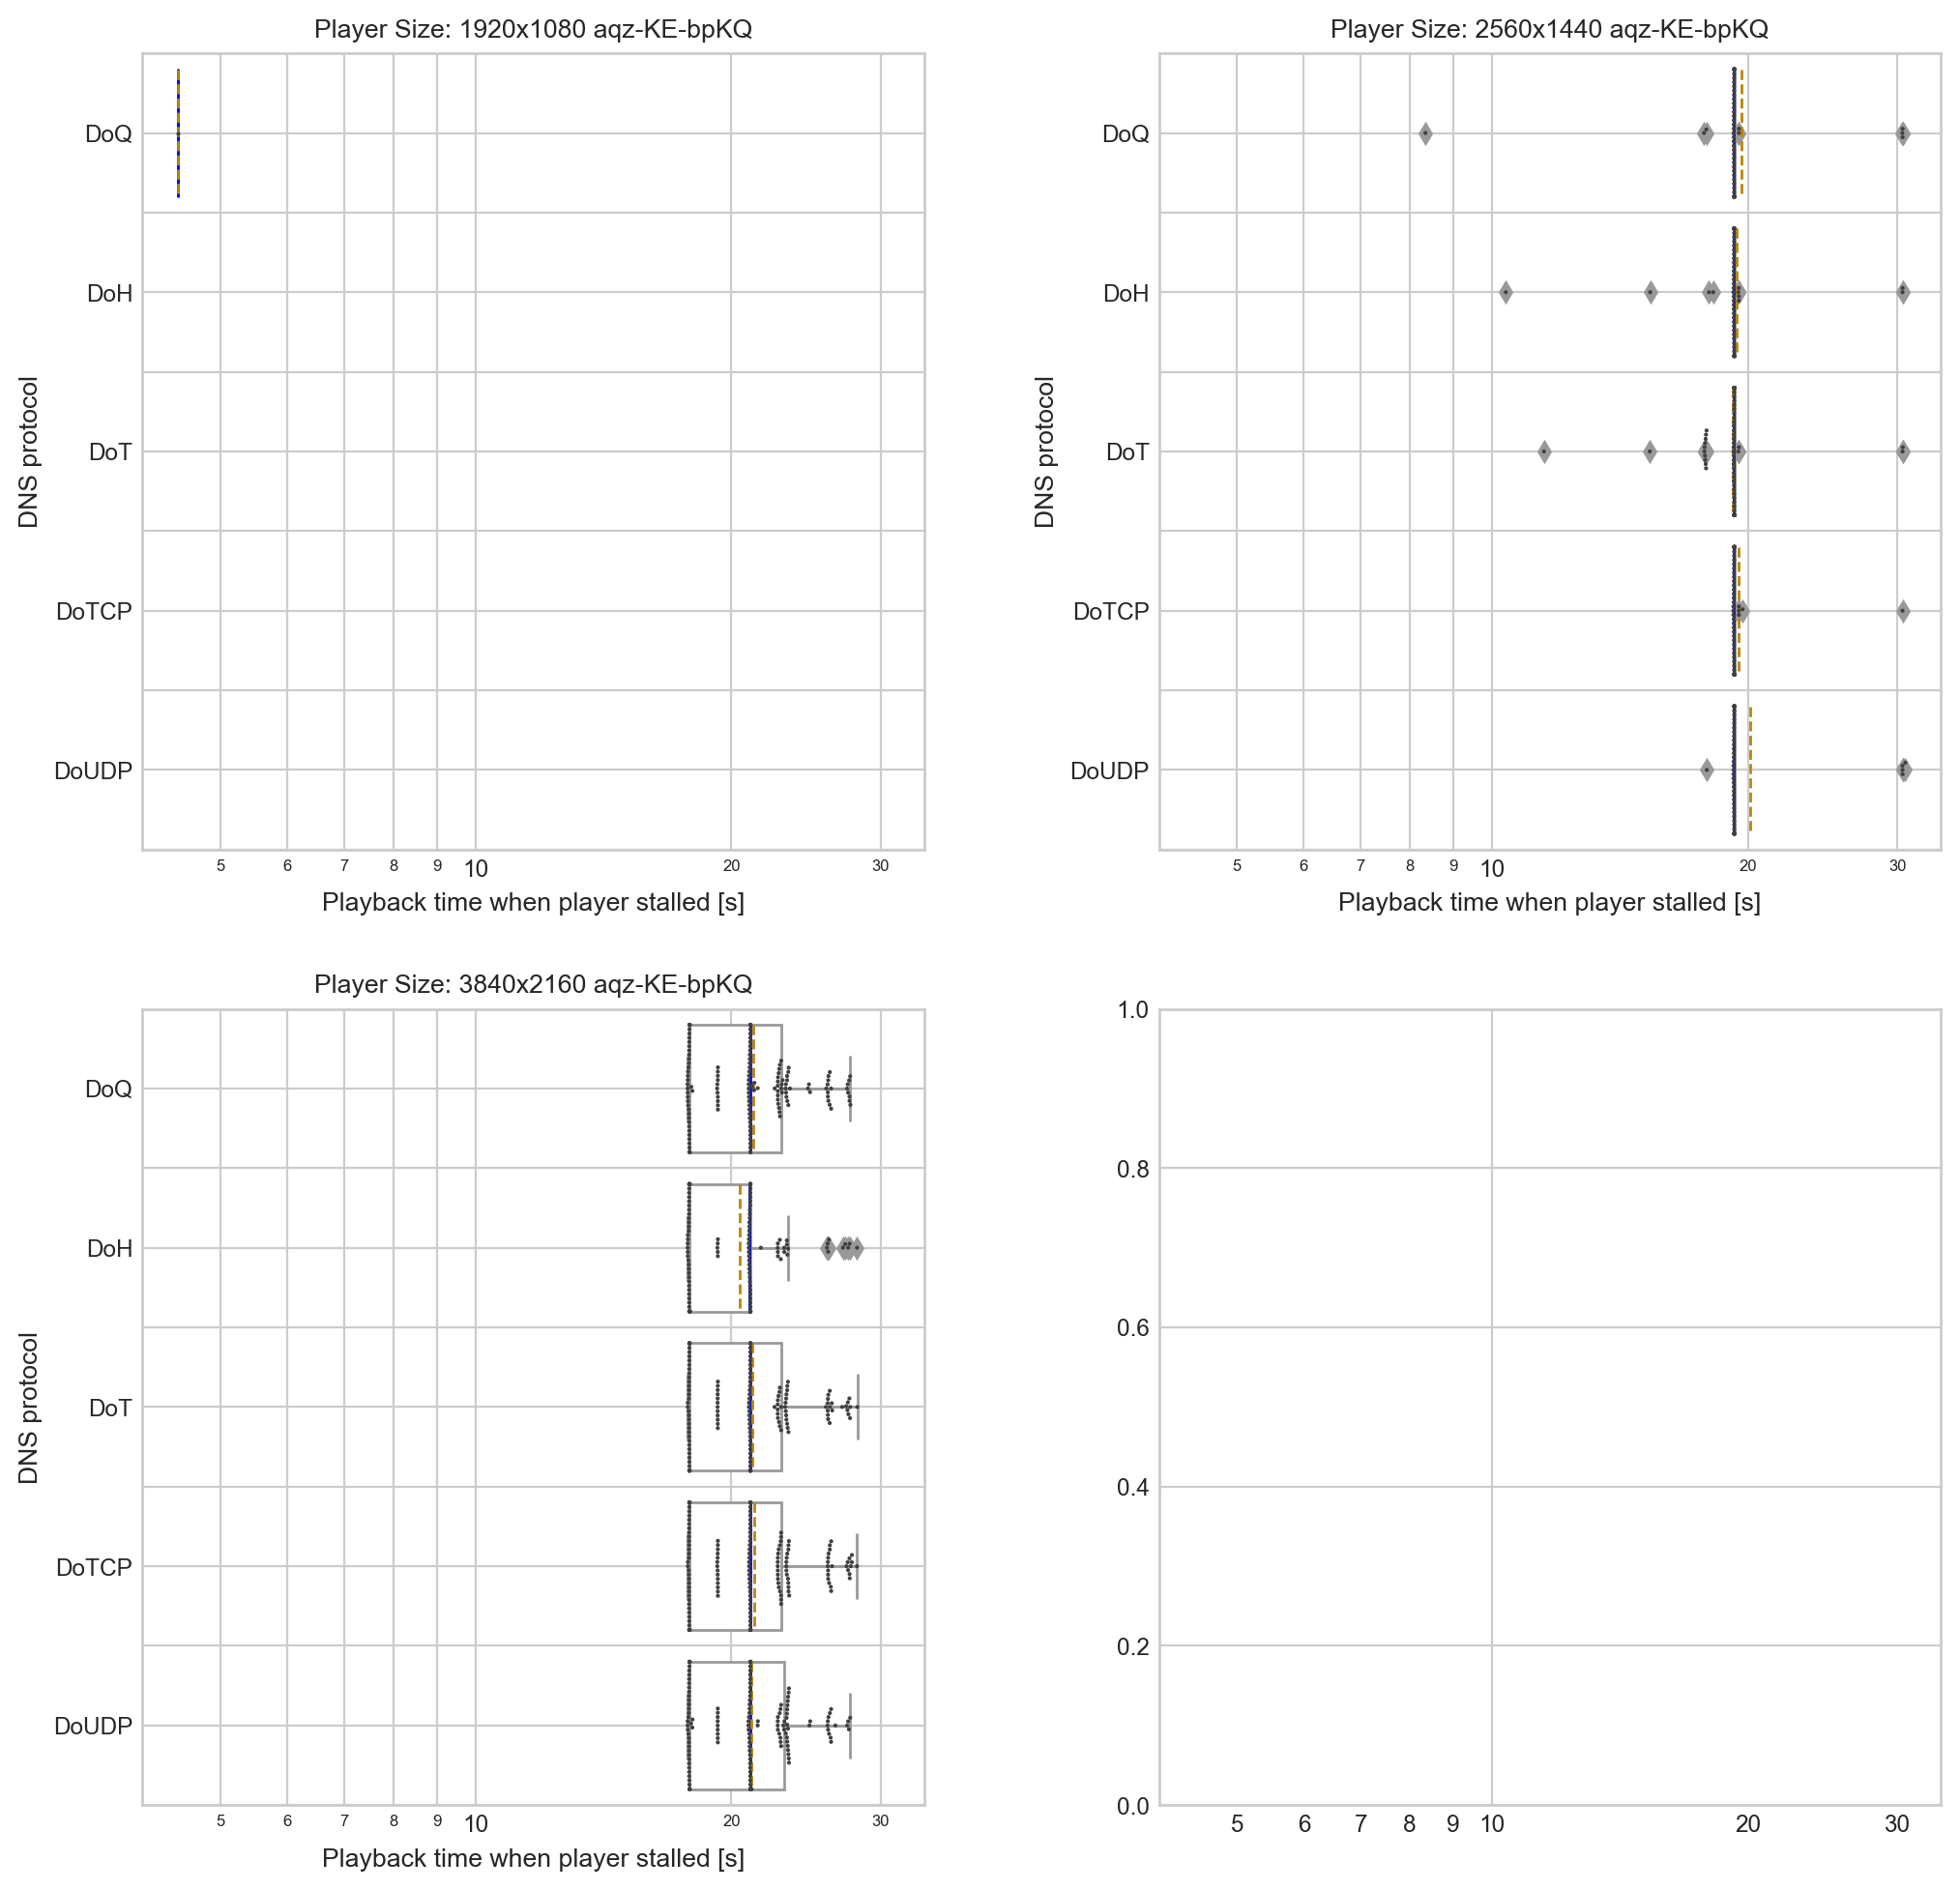

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

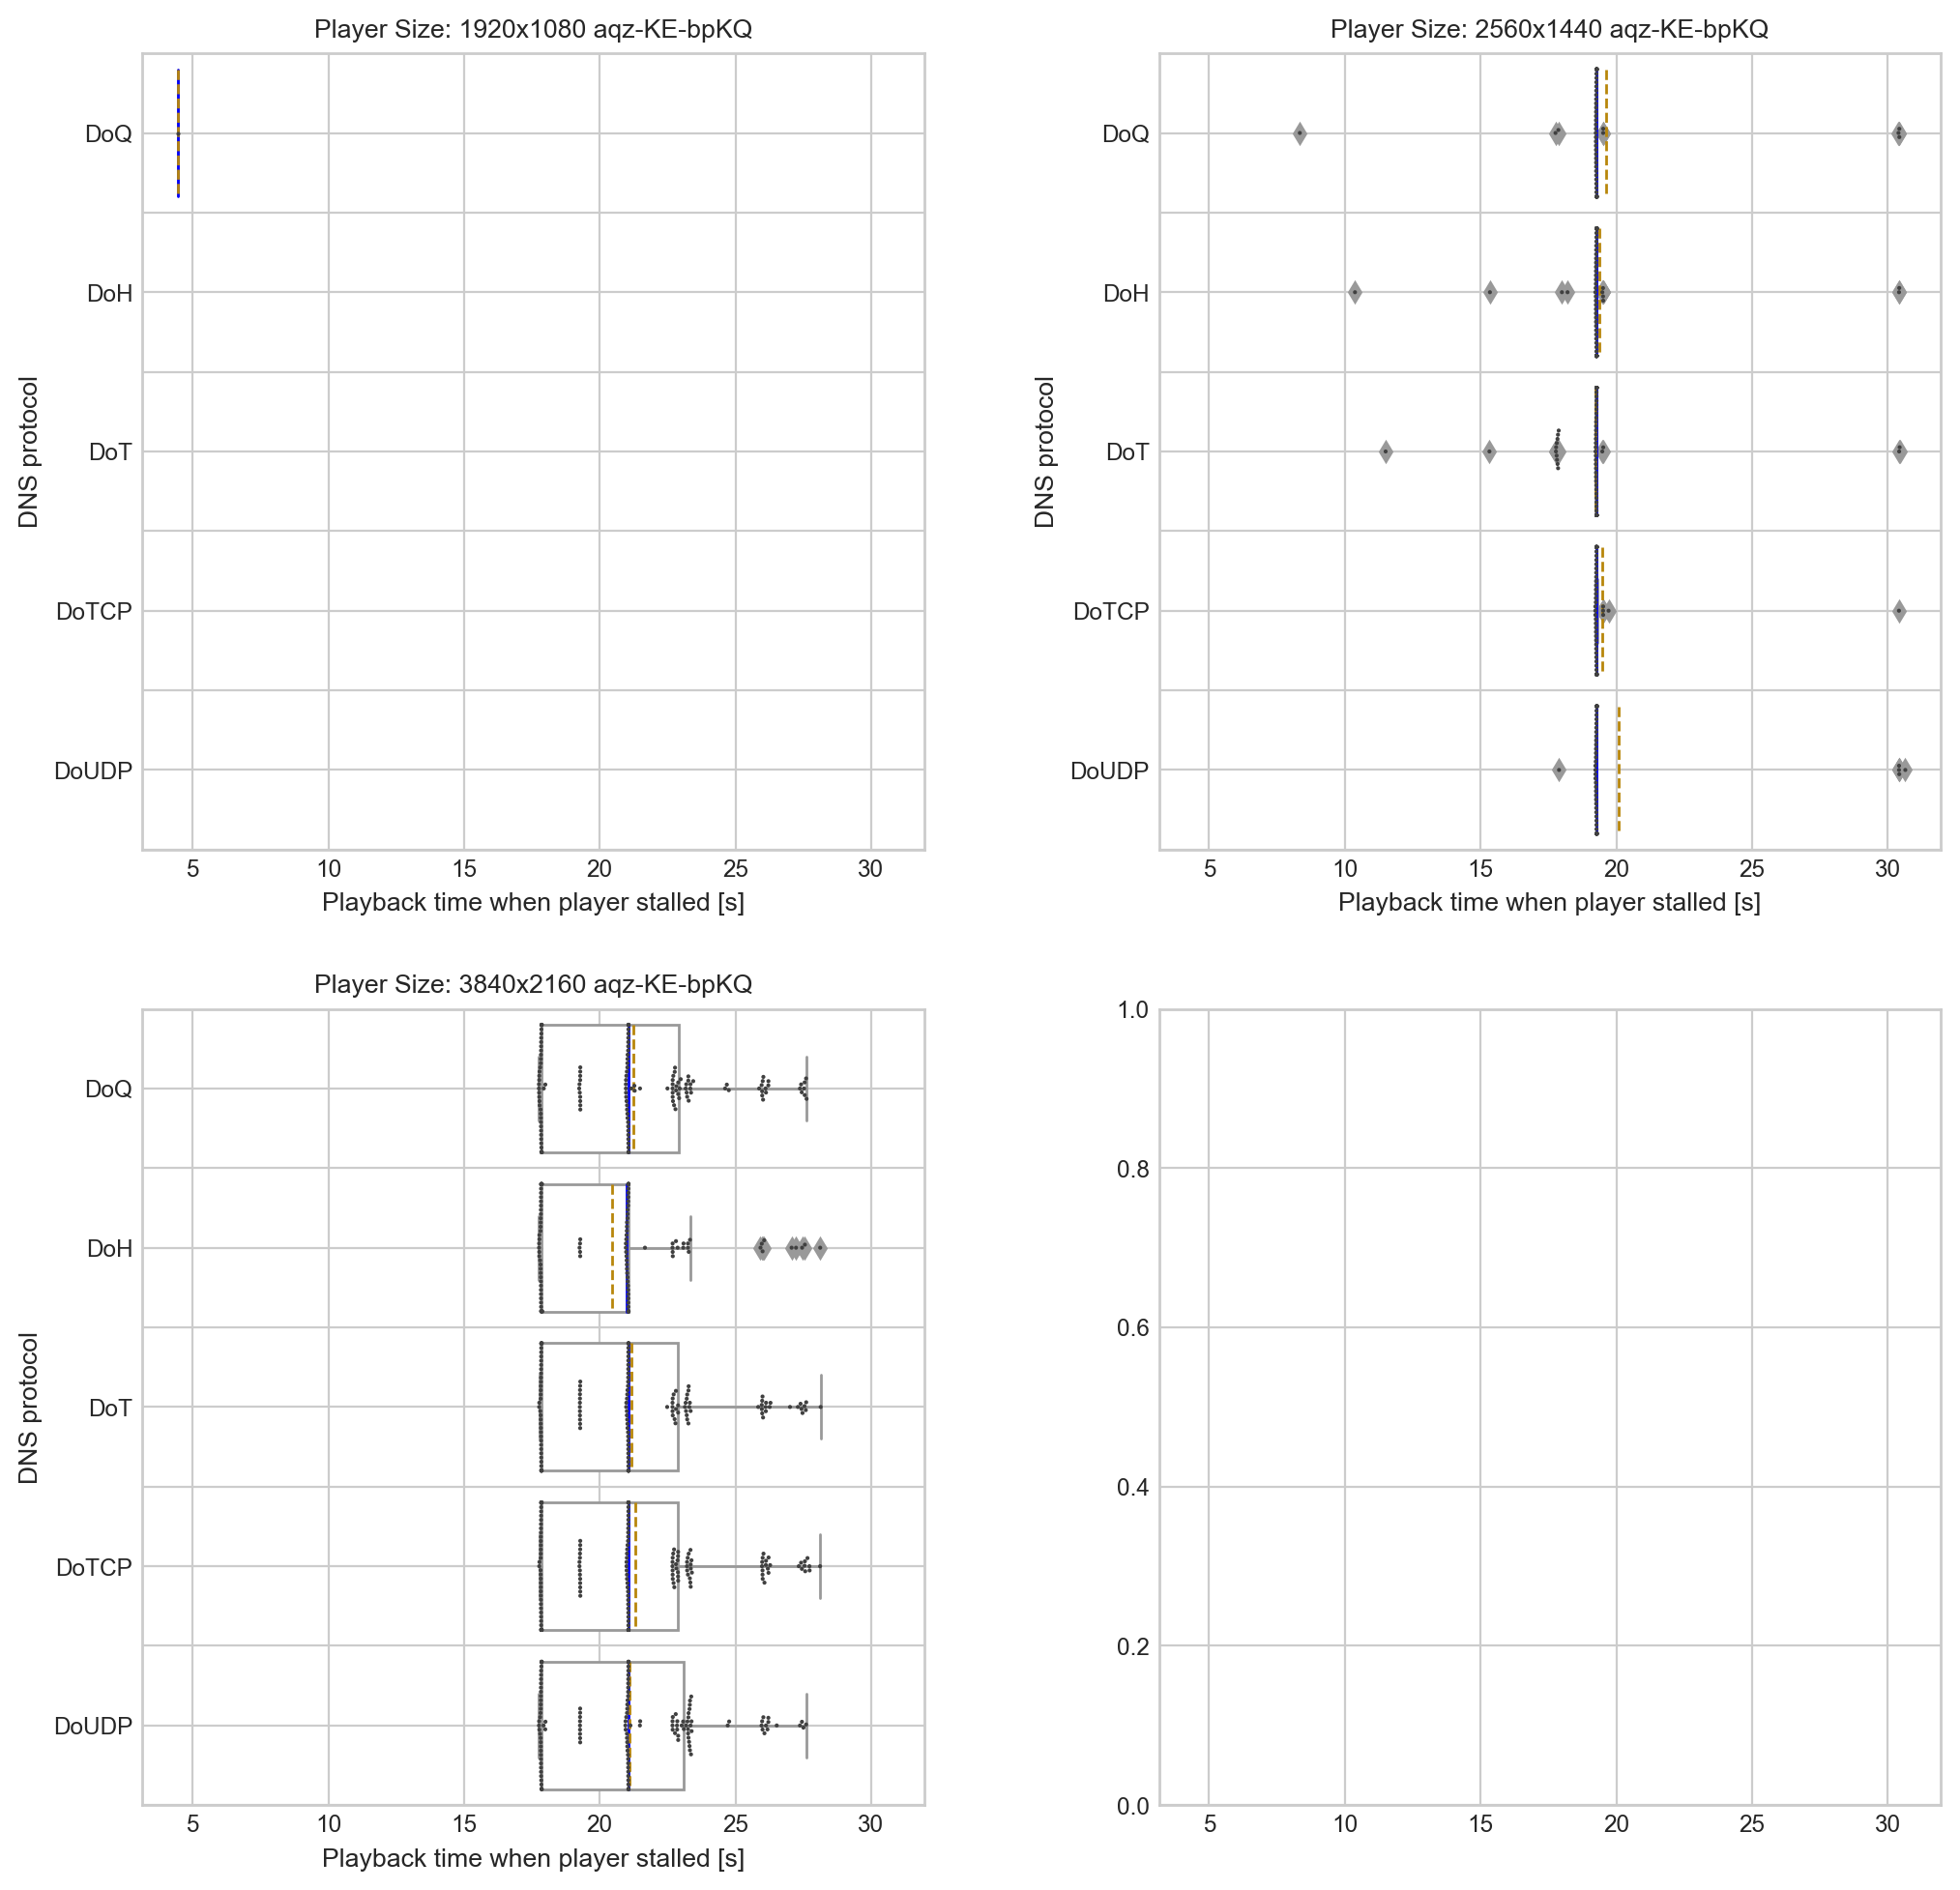

In [240]:
draw_boxplot_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True, False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

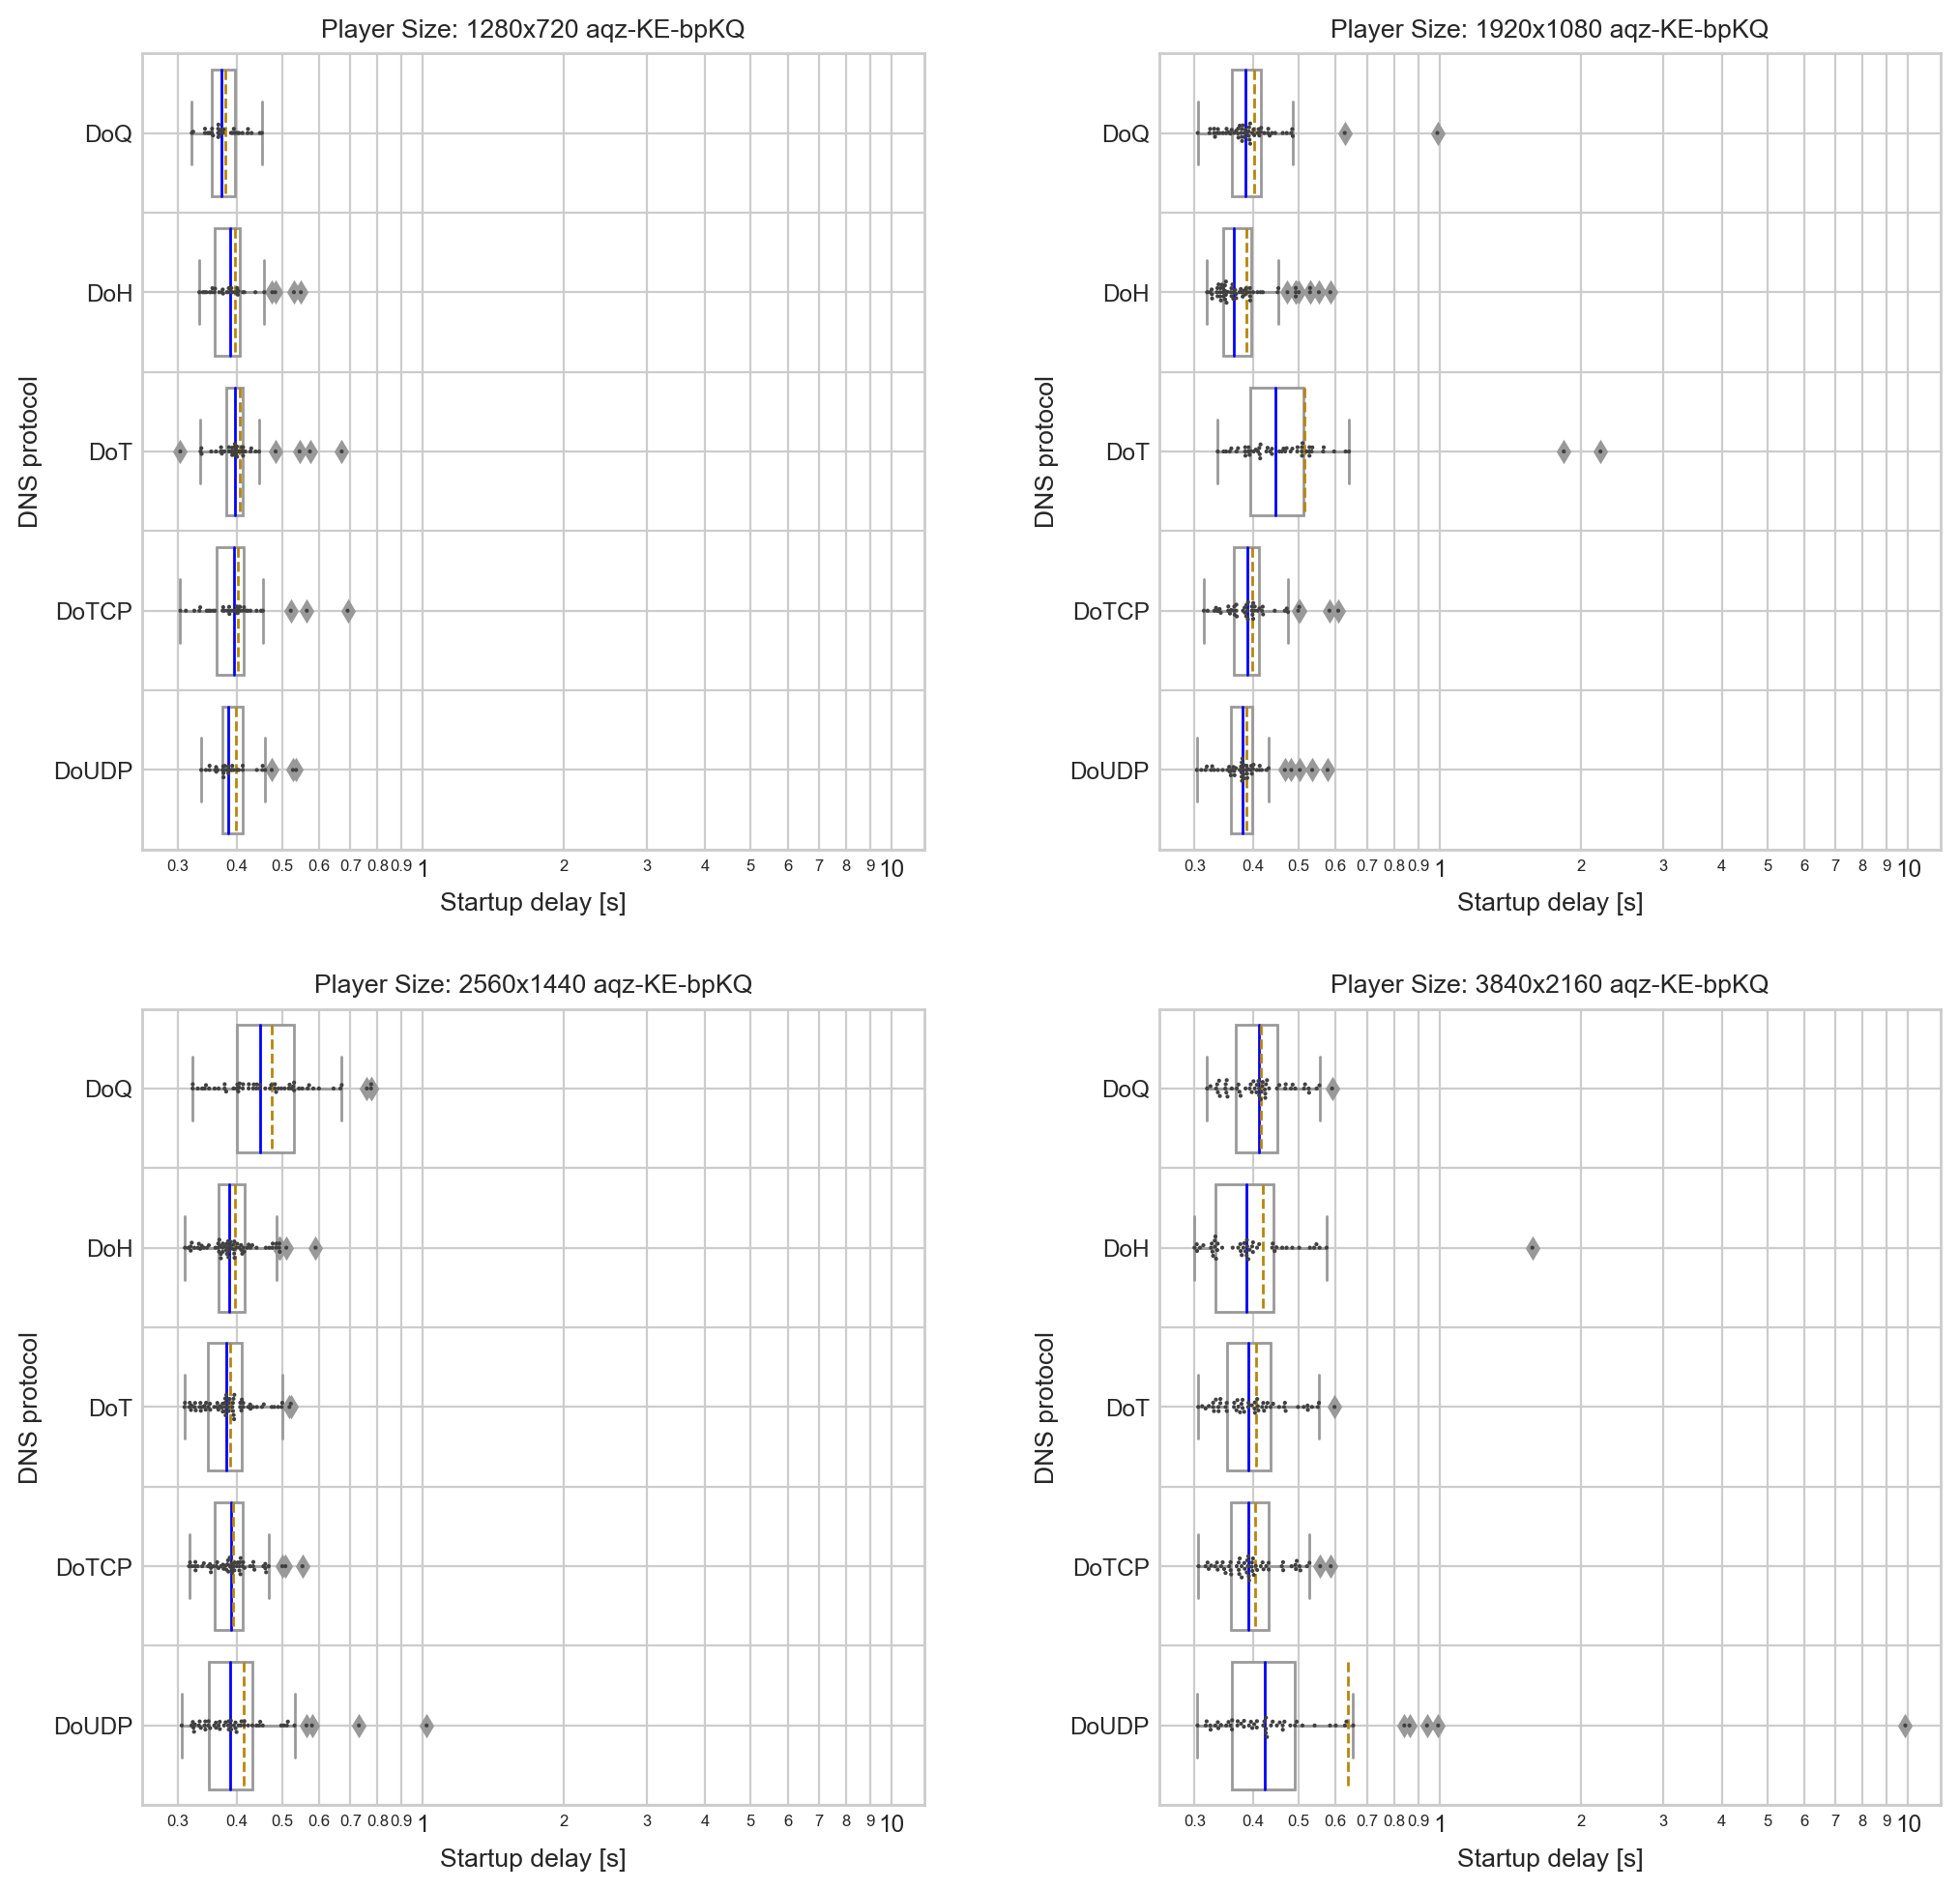

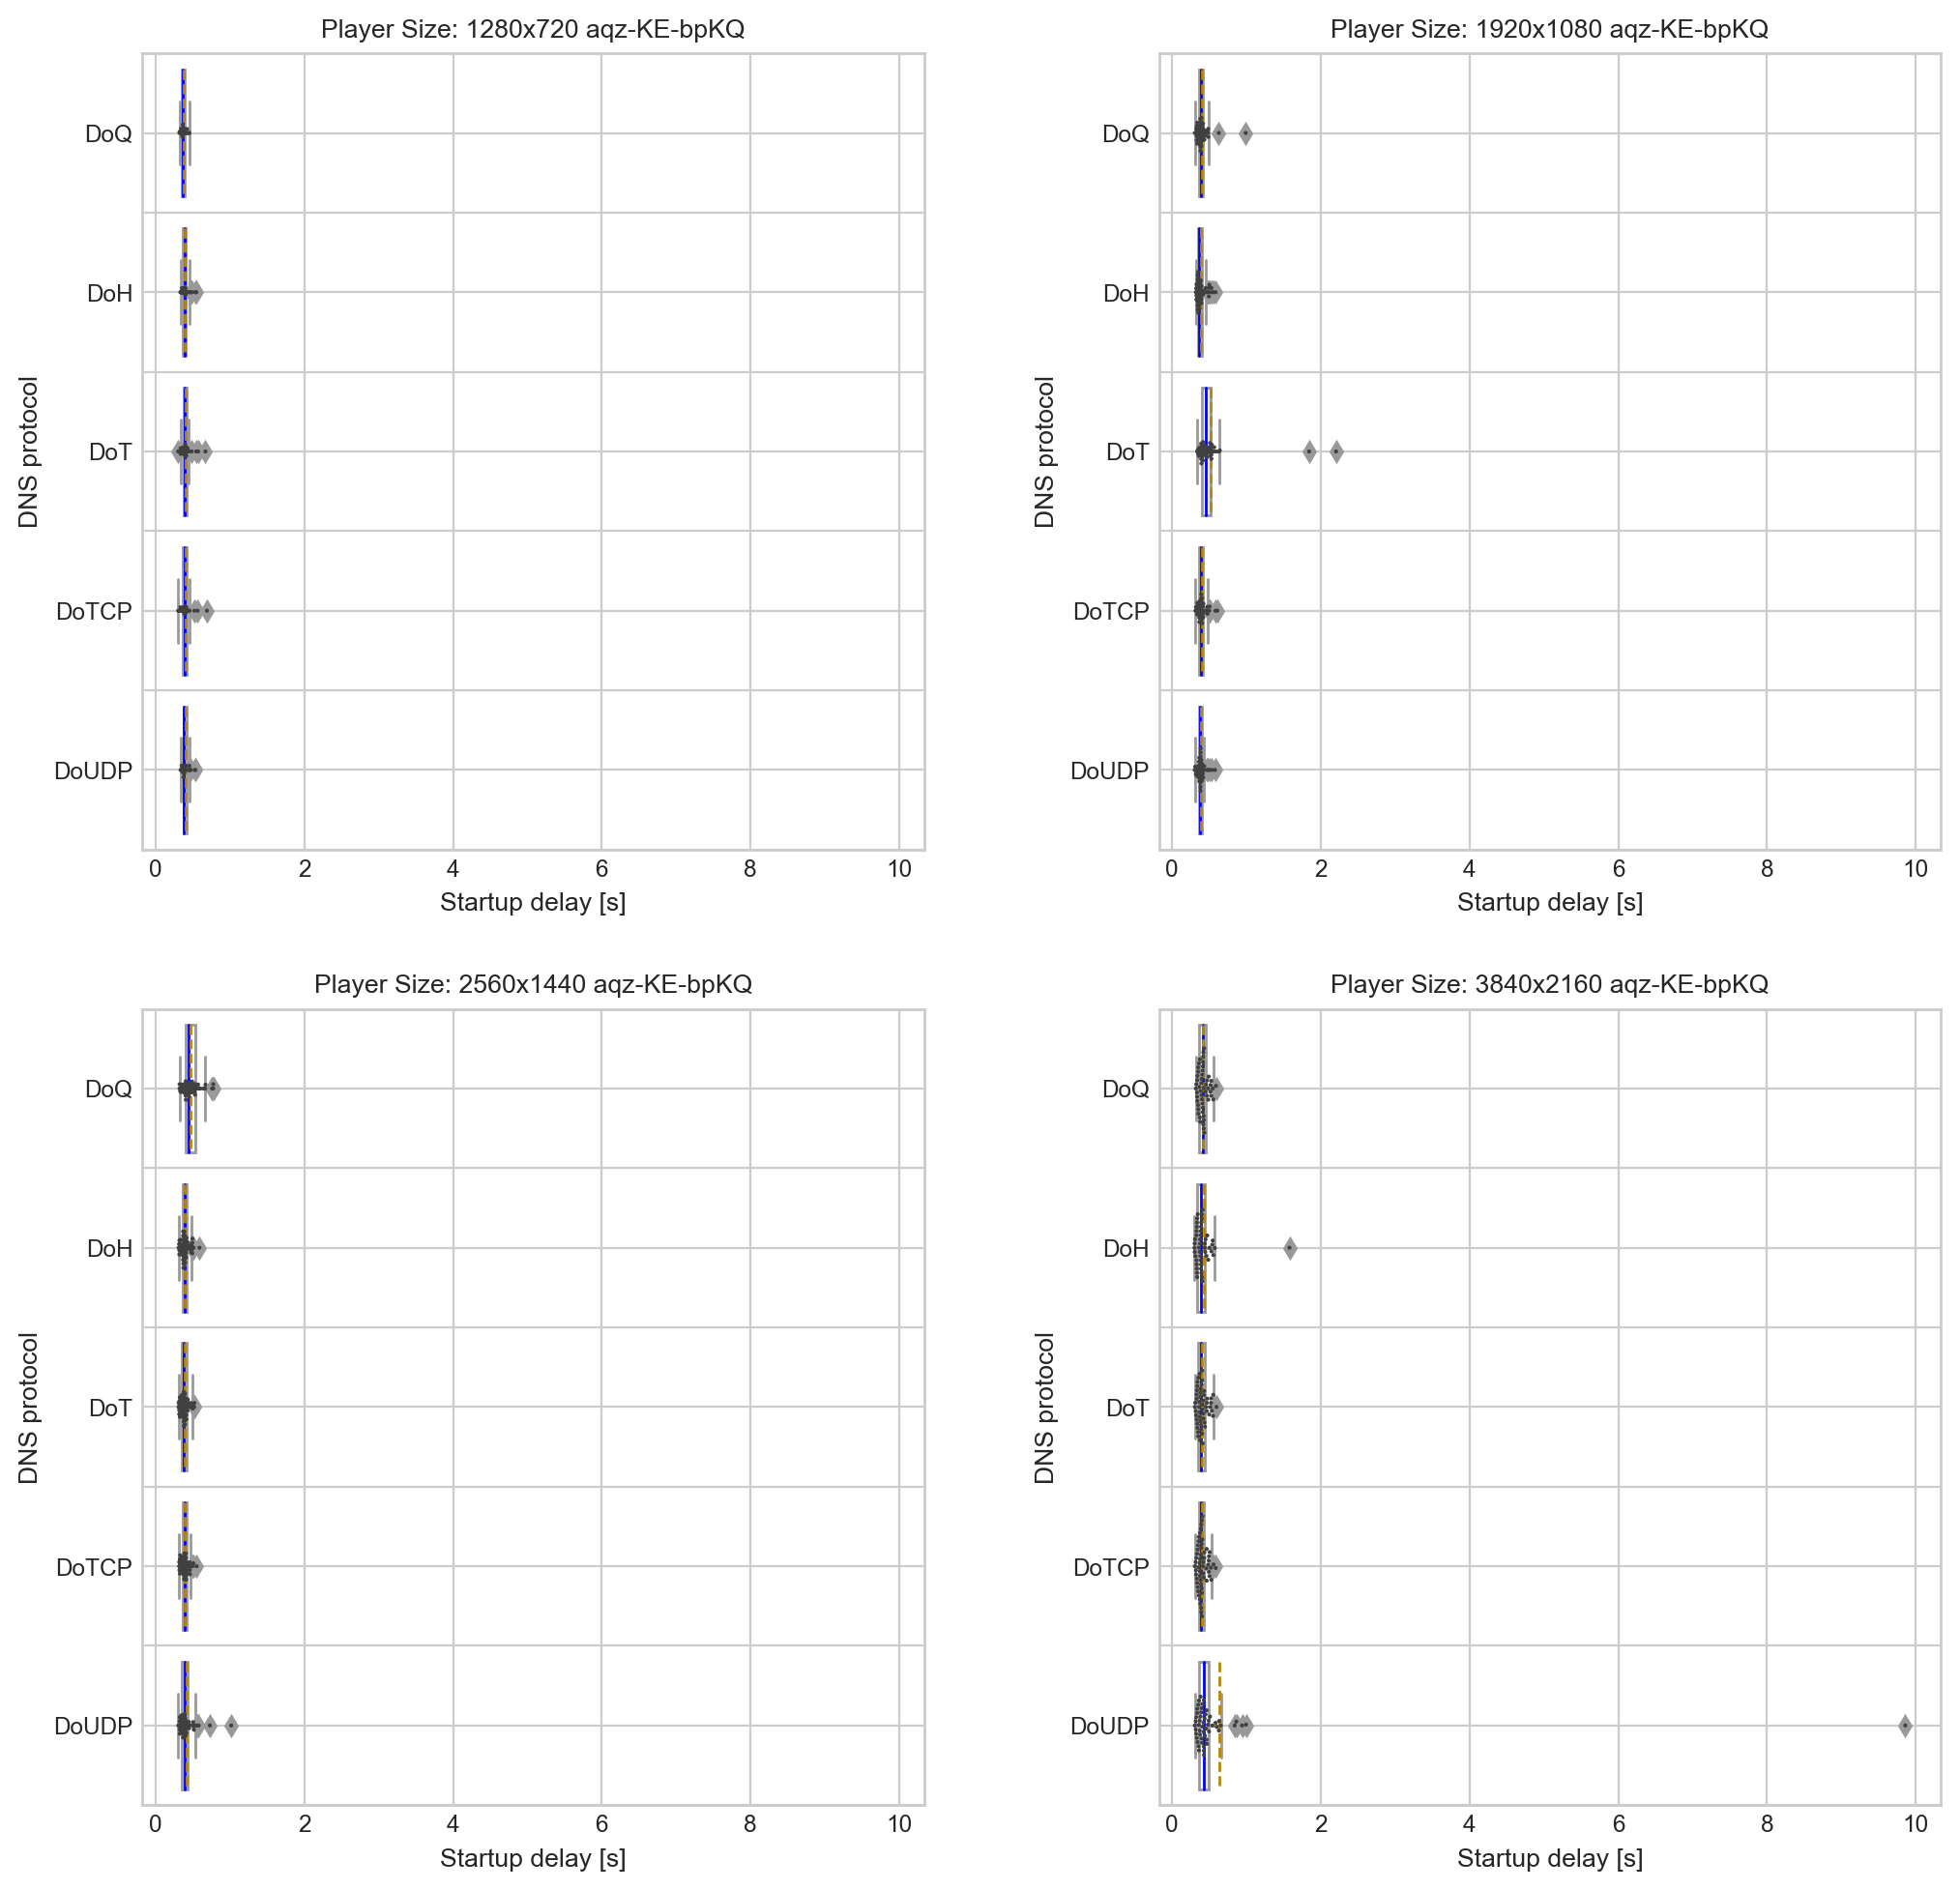

In [241]:
draw_boxplot_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

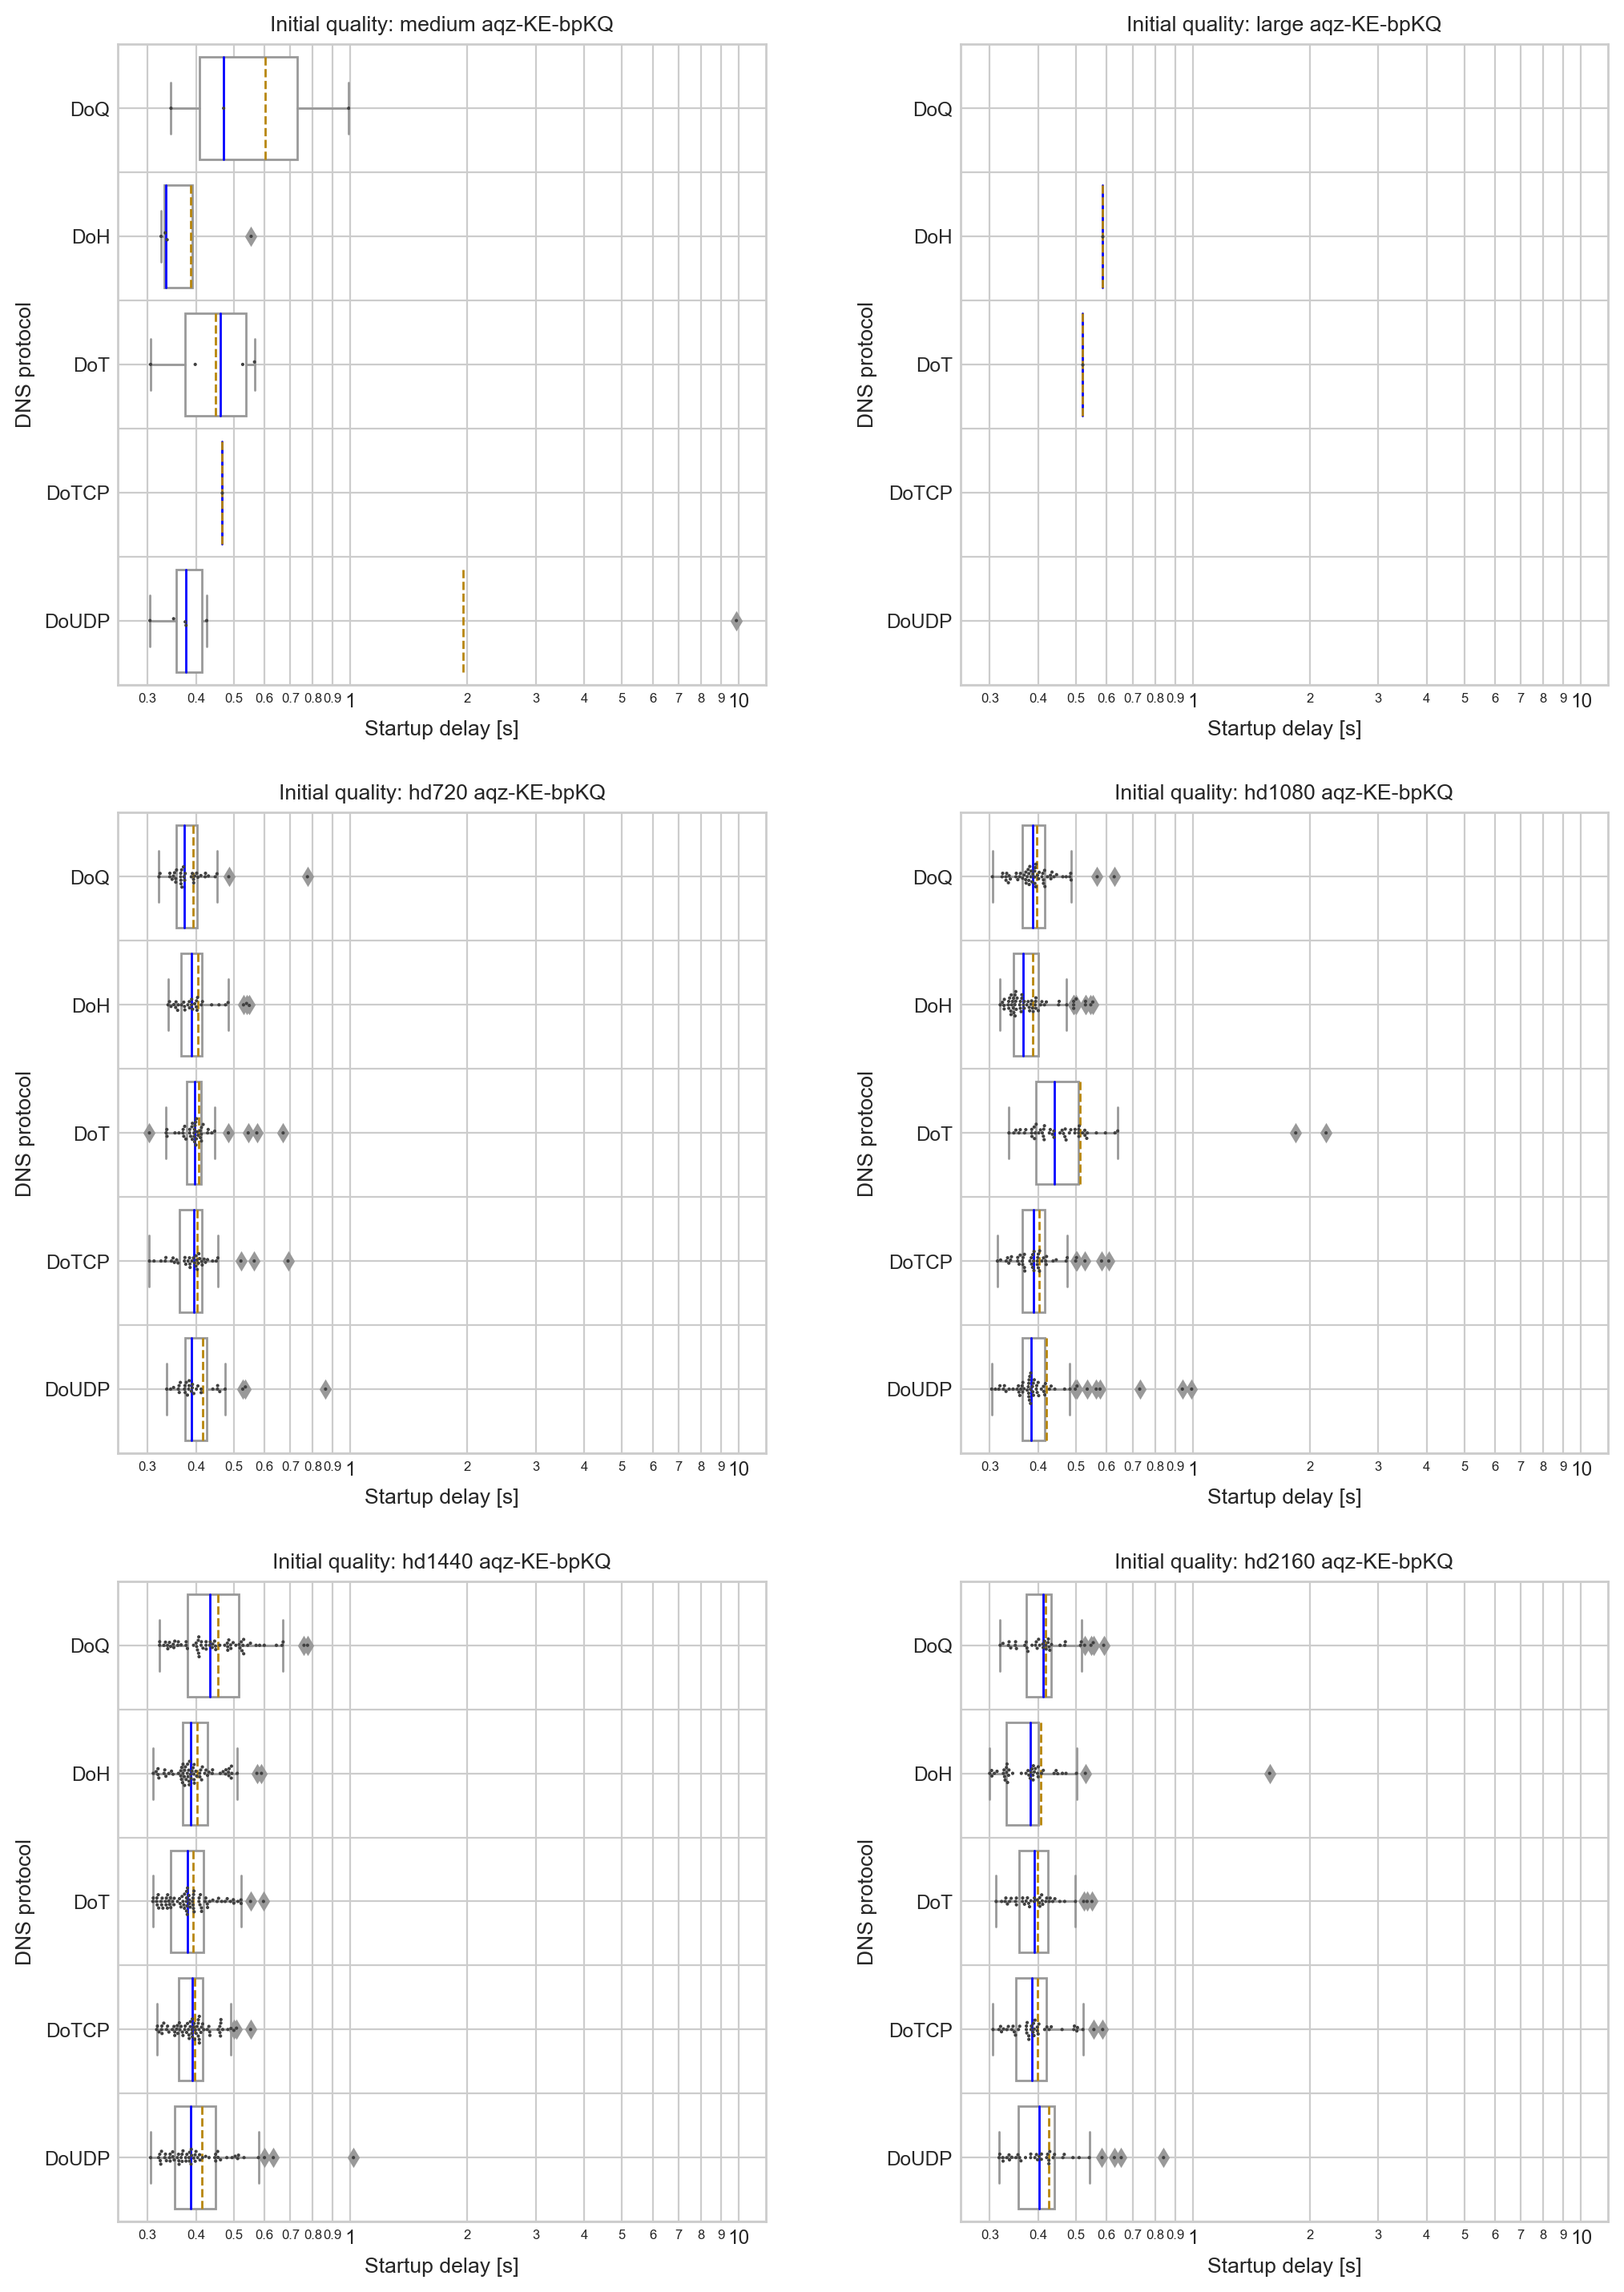

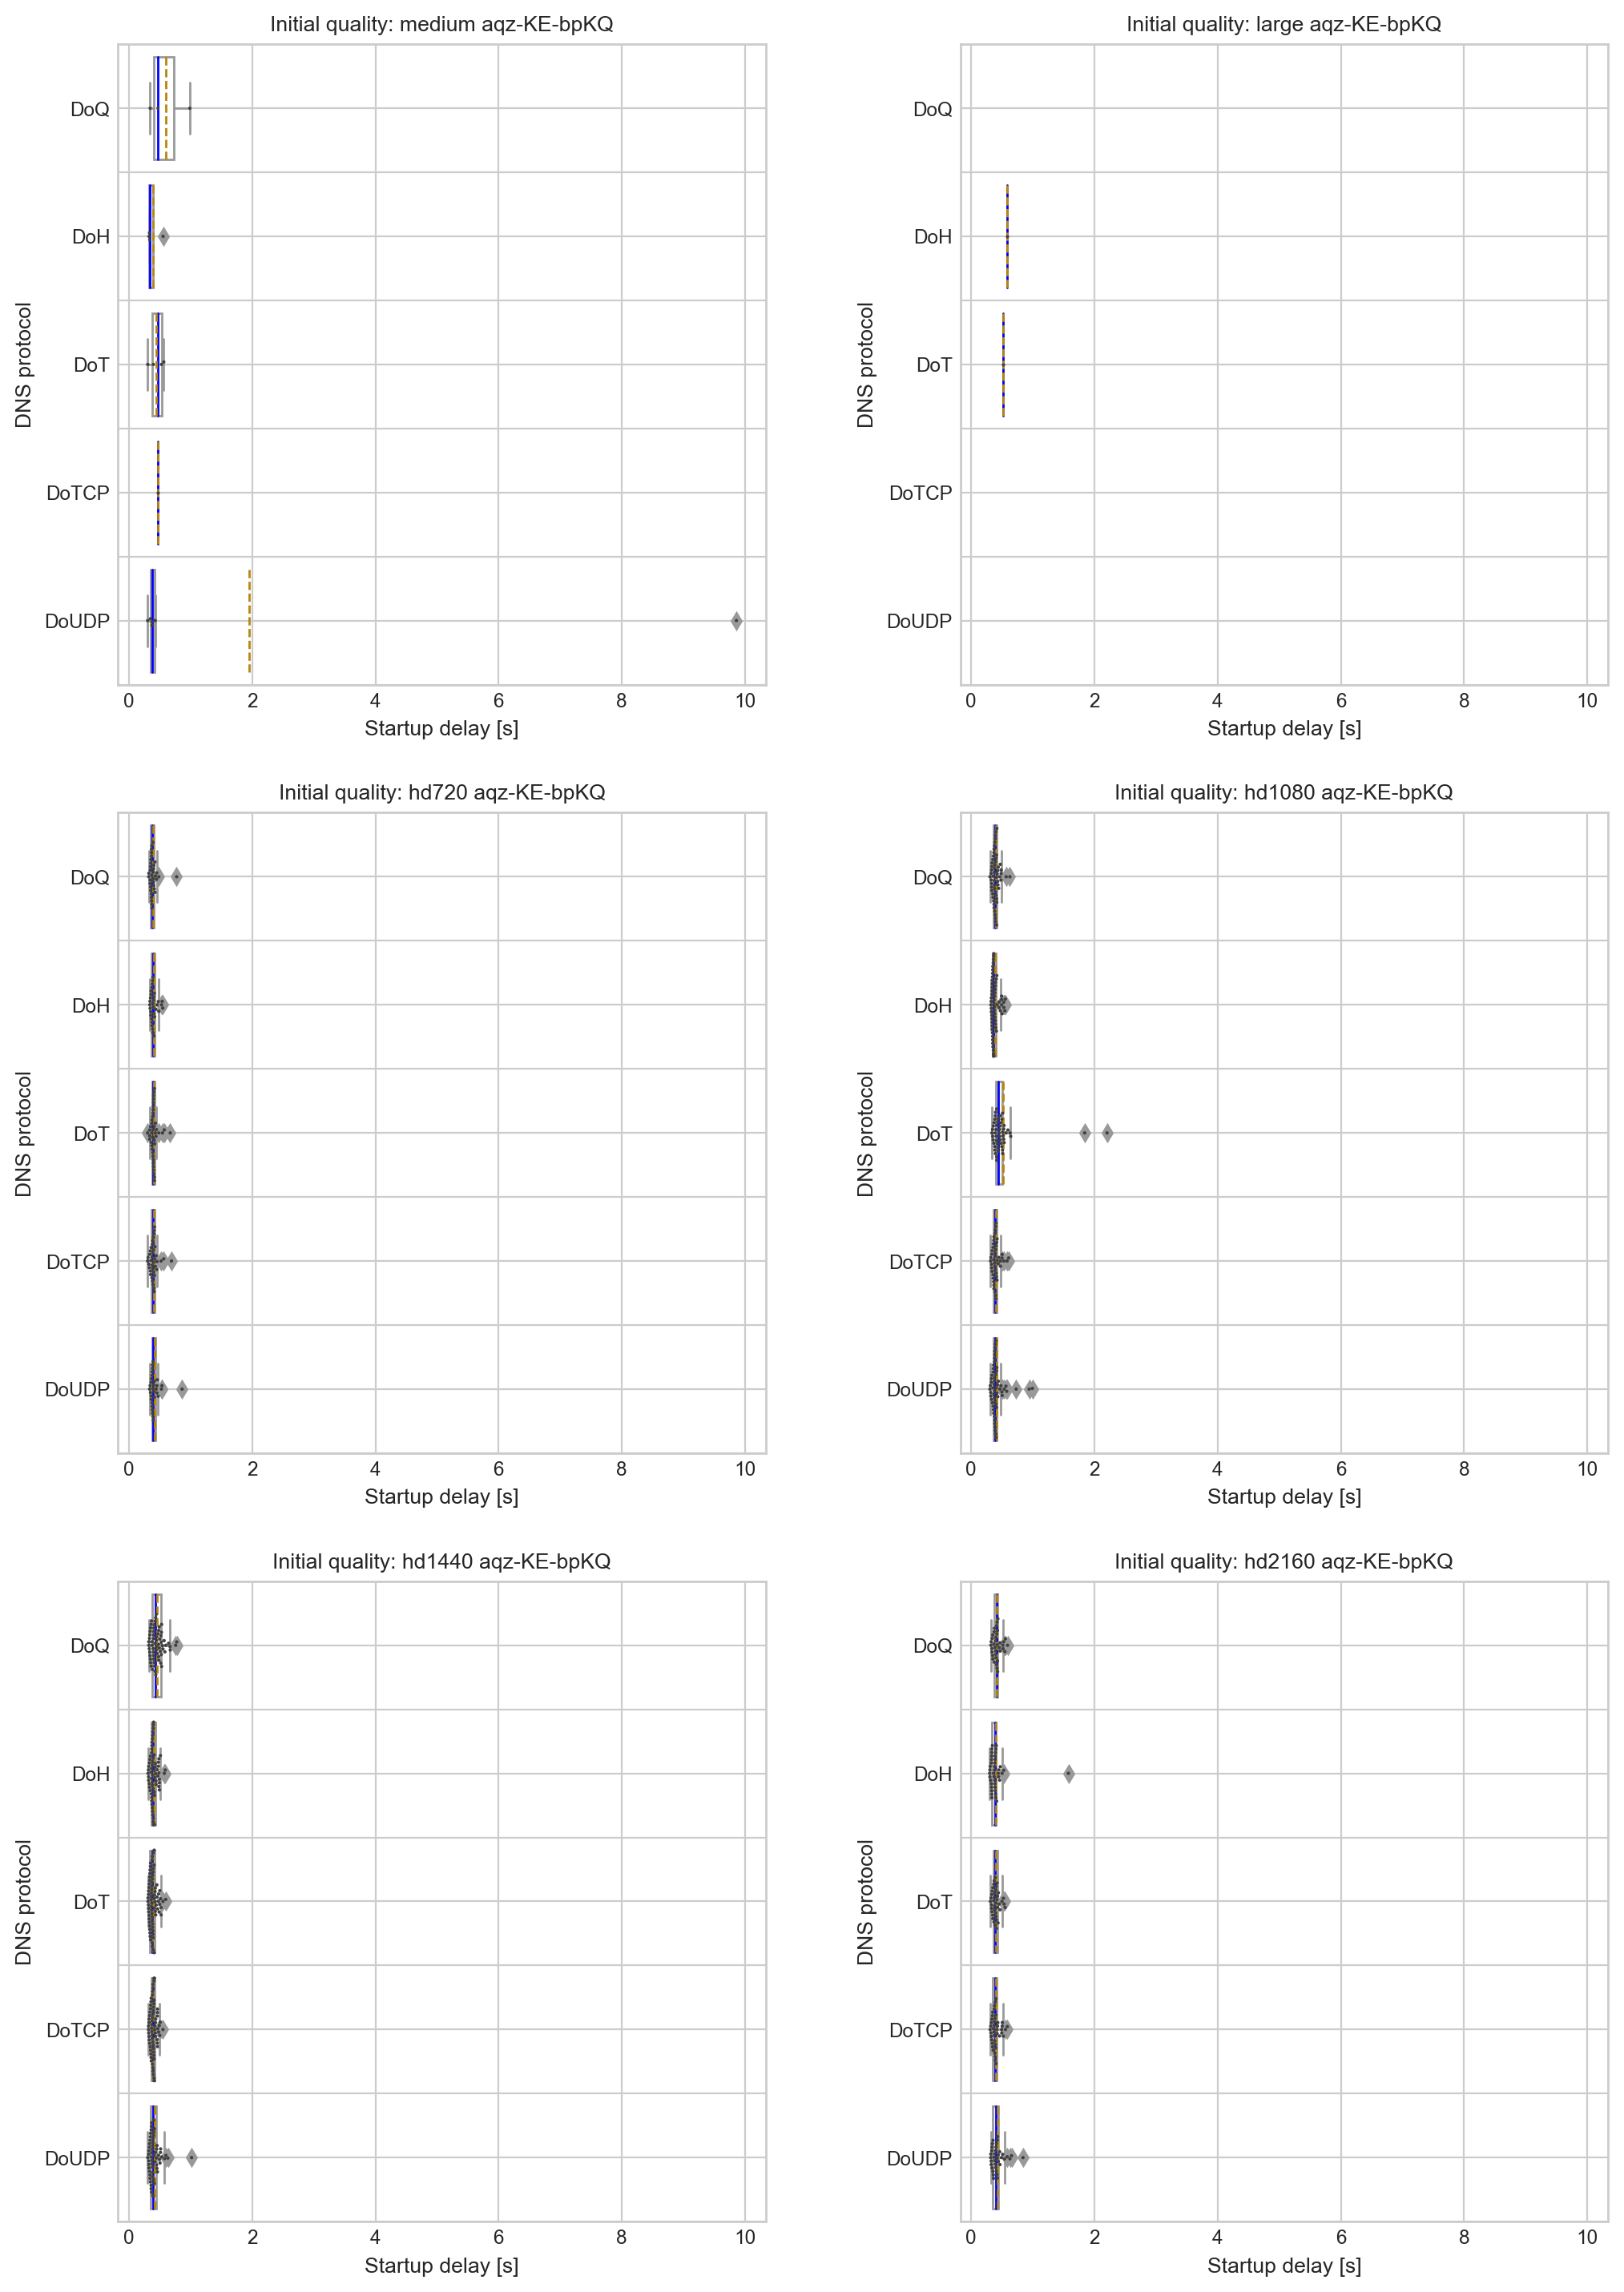

In [242]:
draw_boxplot_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


In [ ]:
draw_boxplot(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


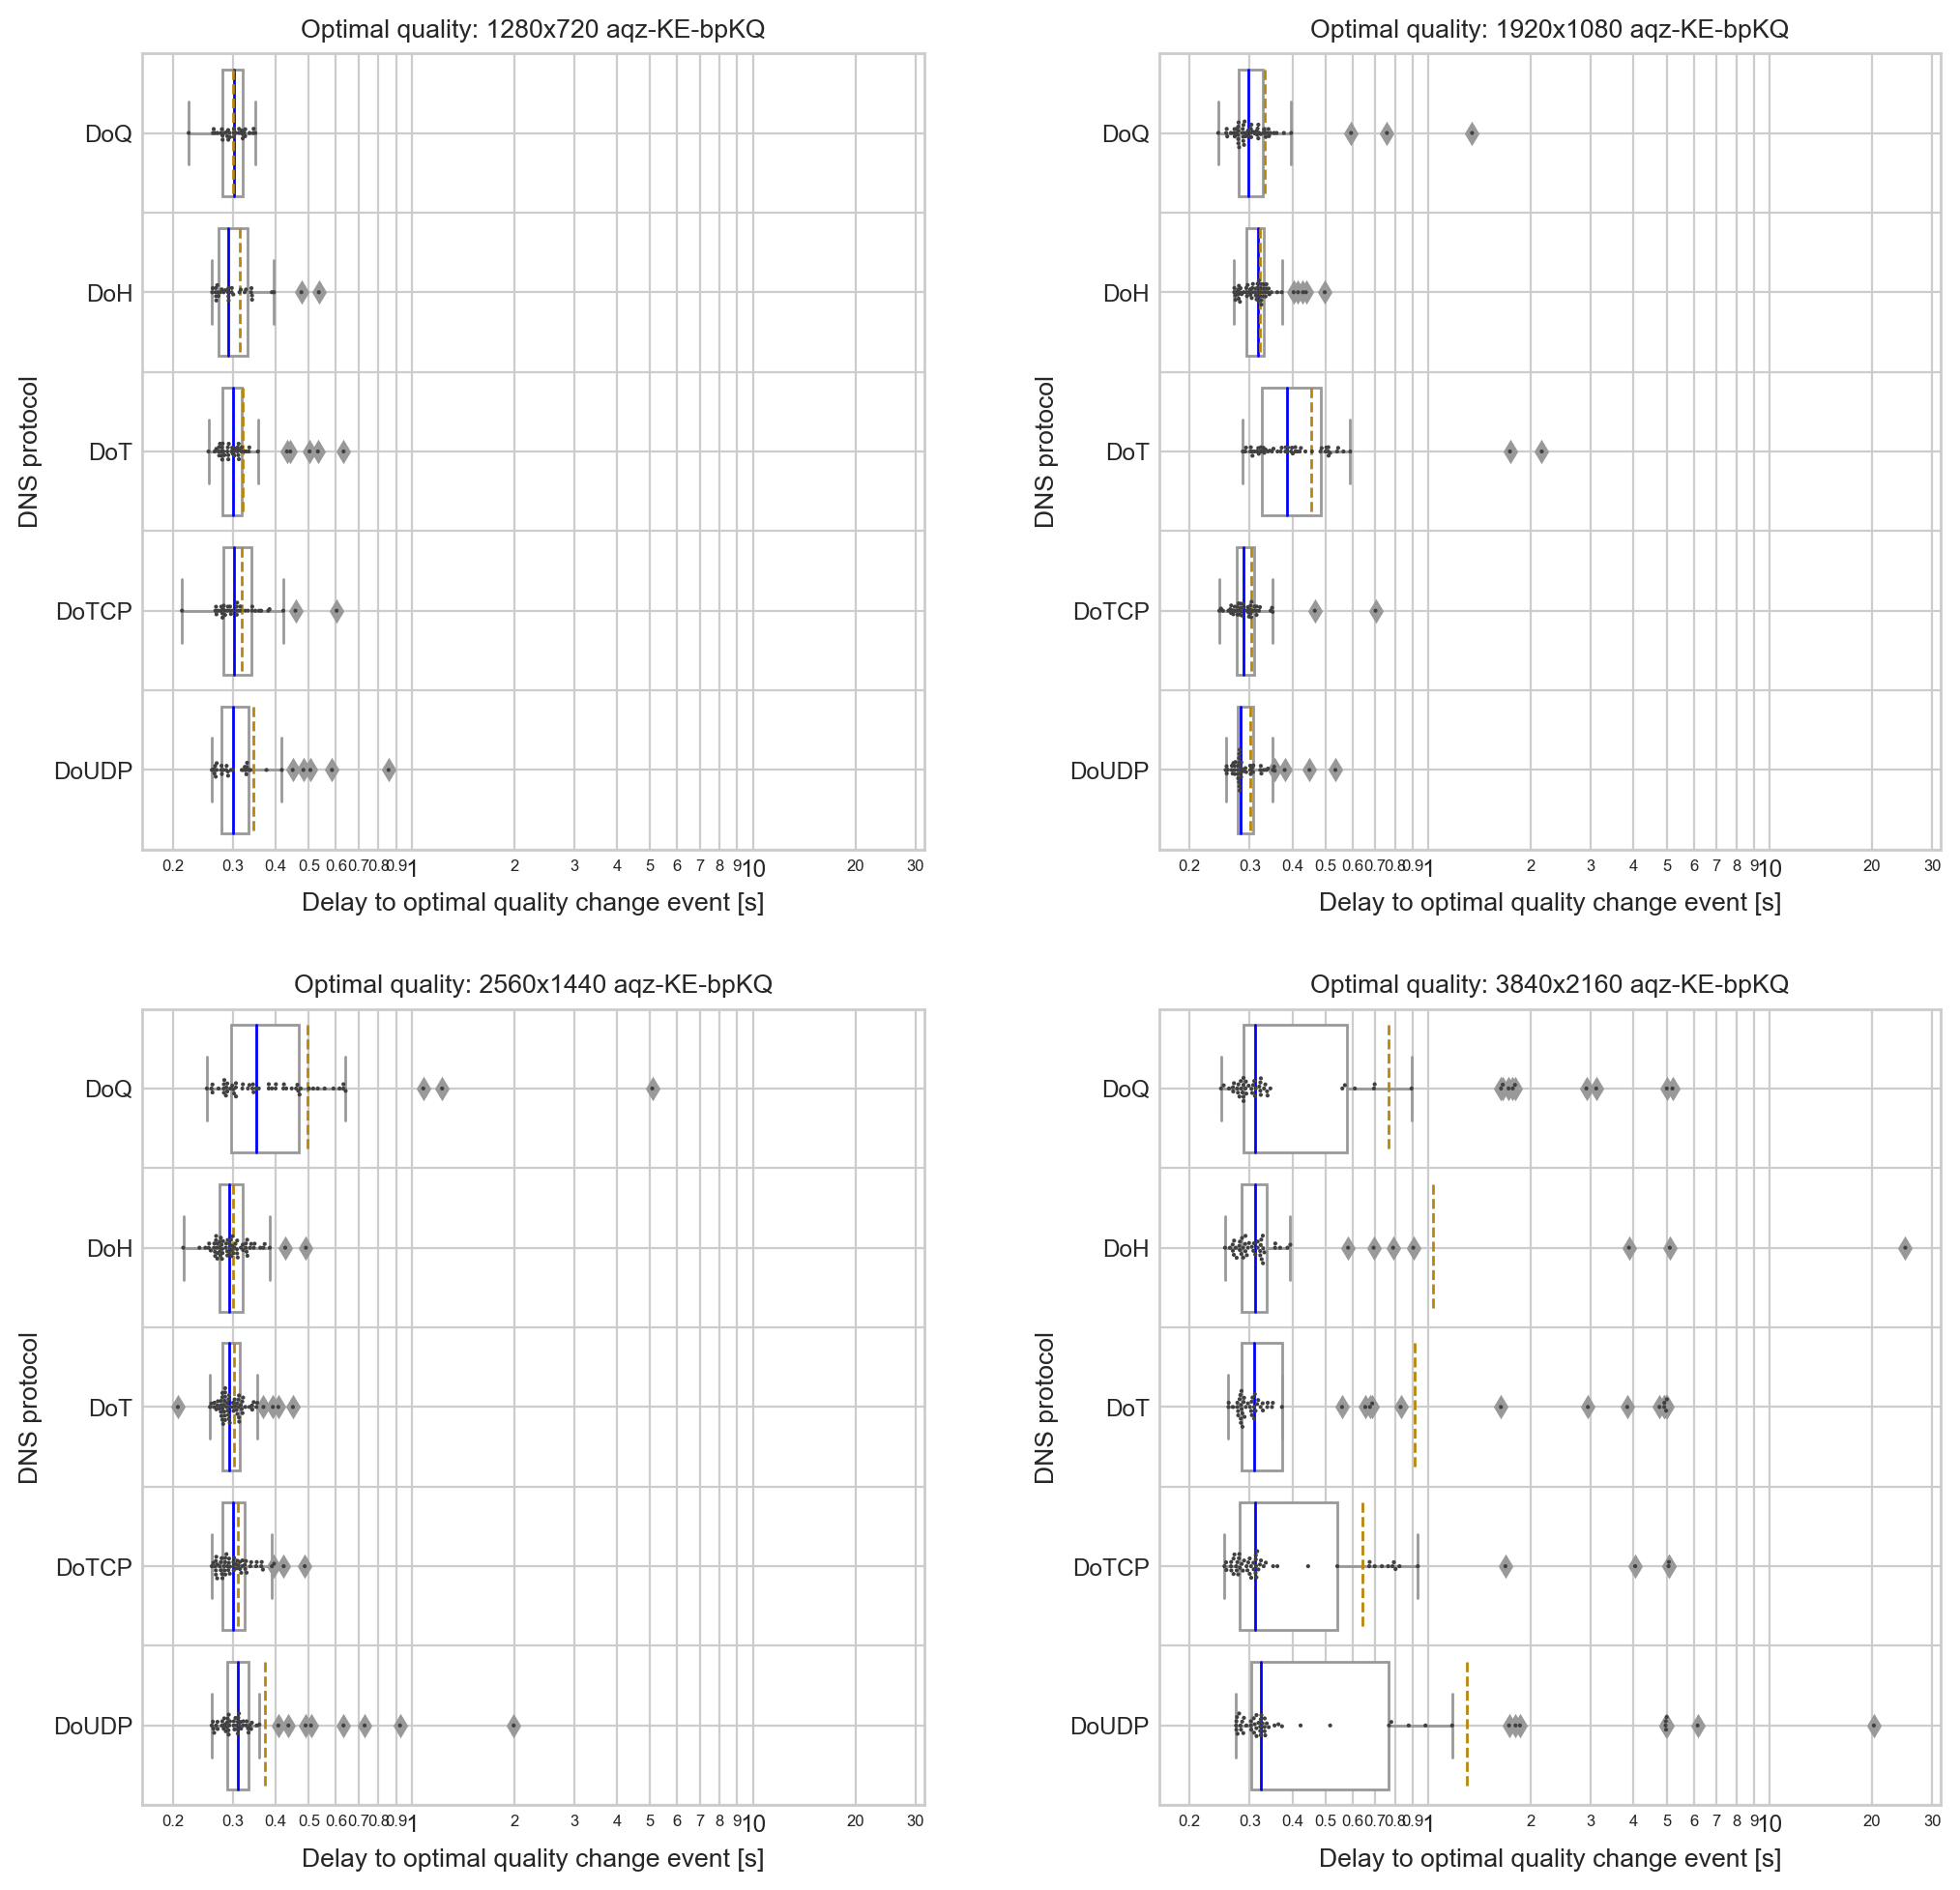

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

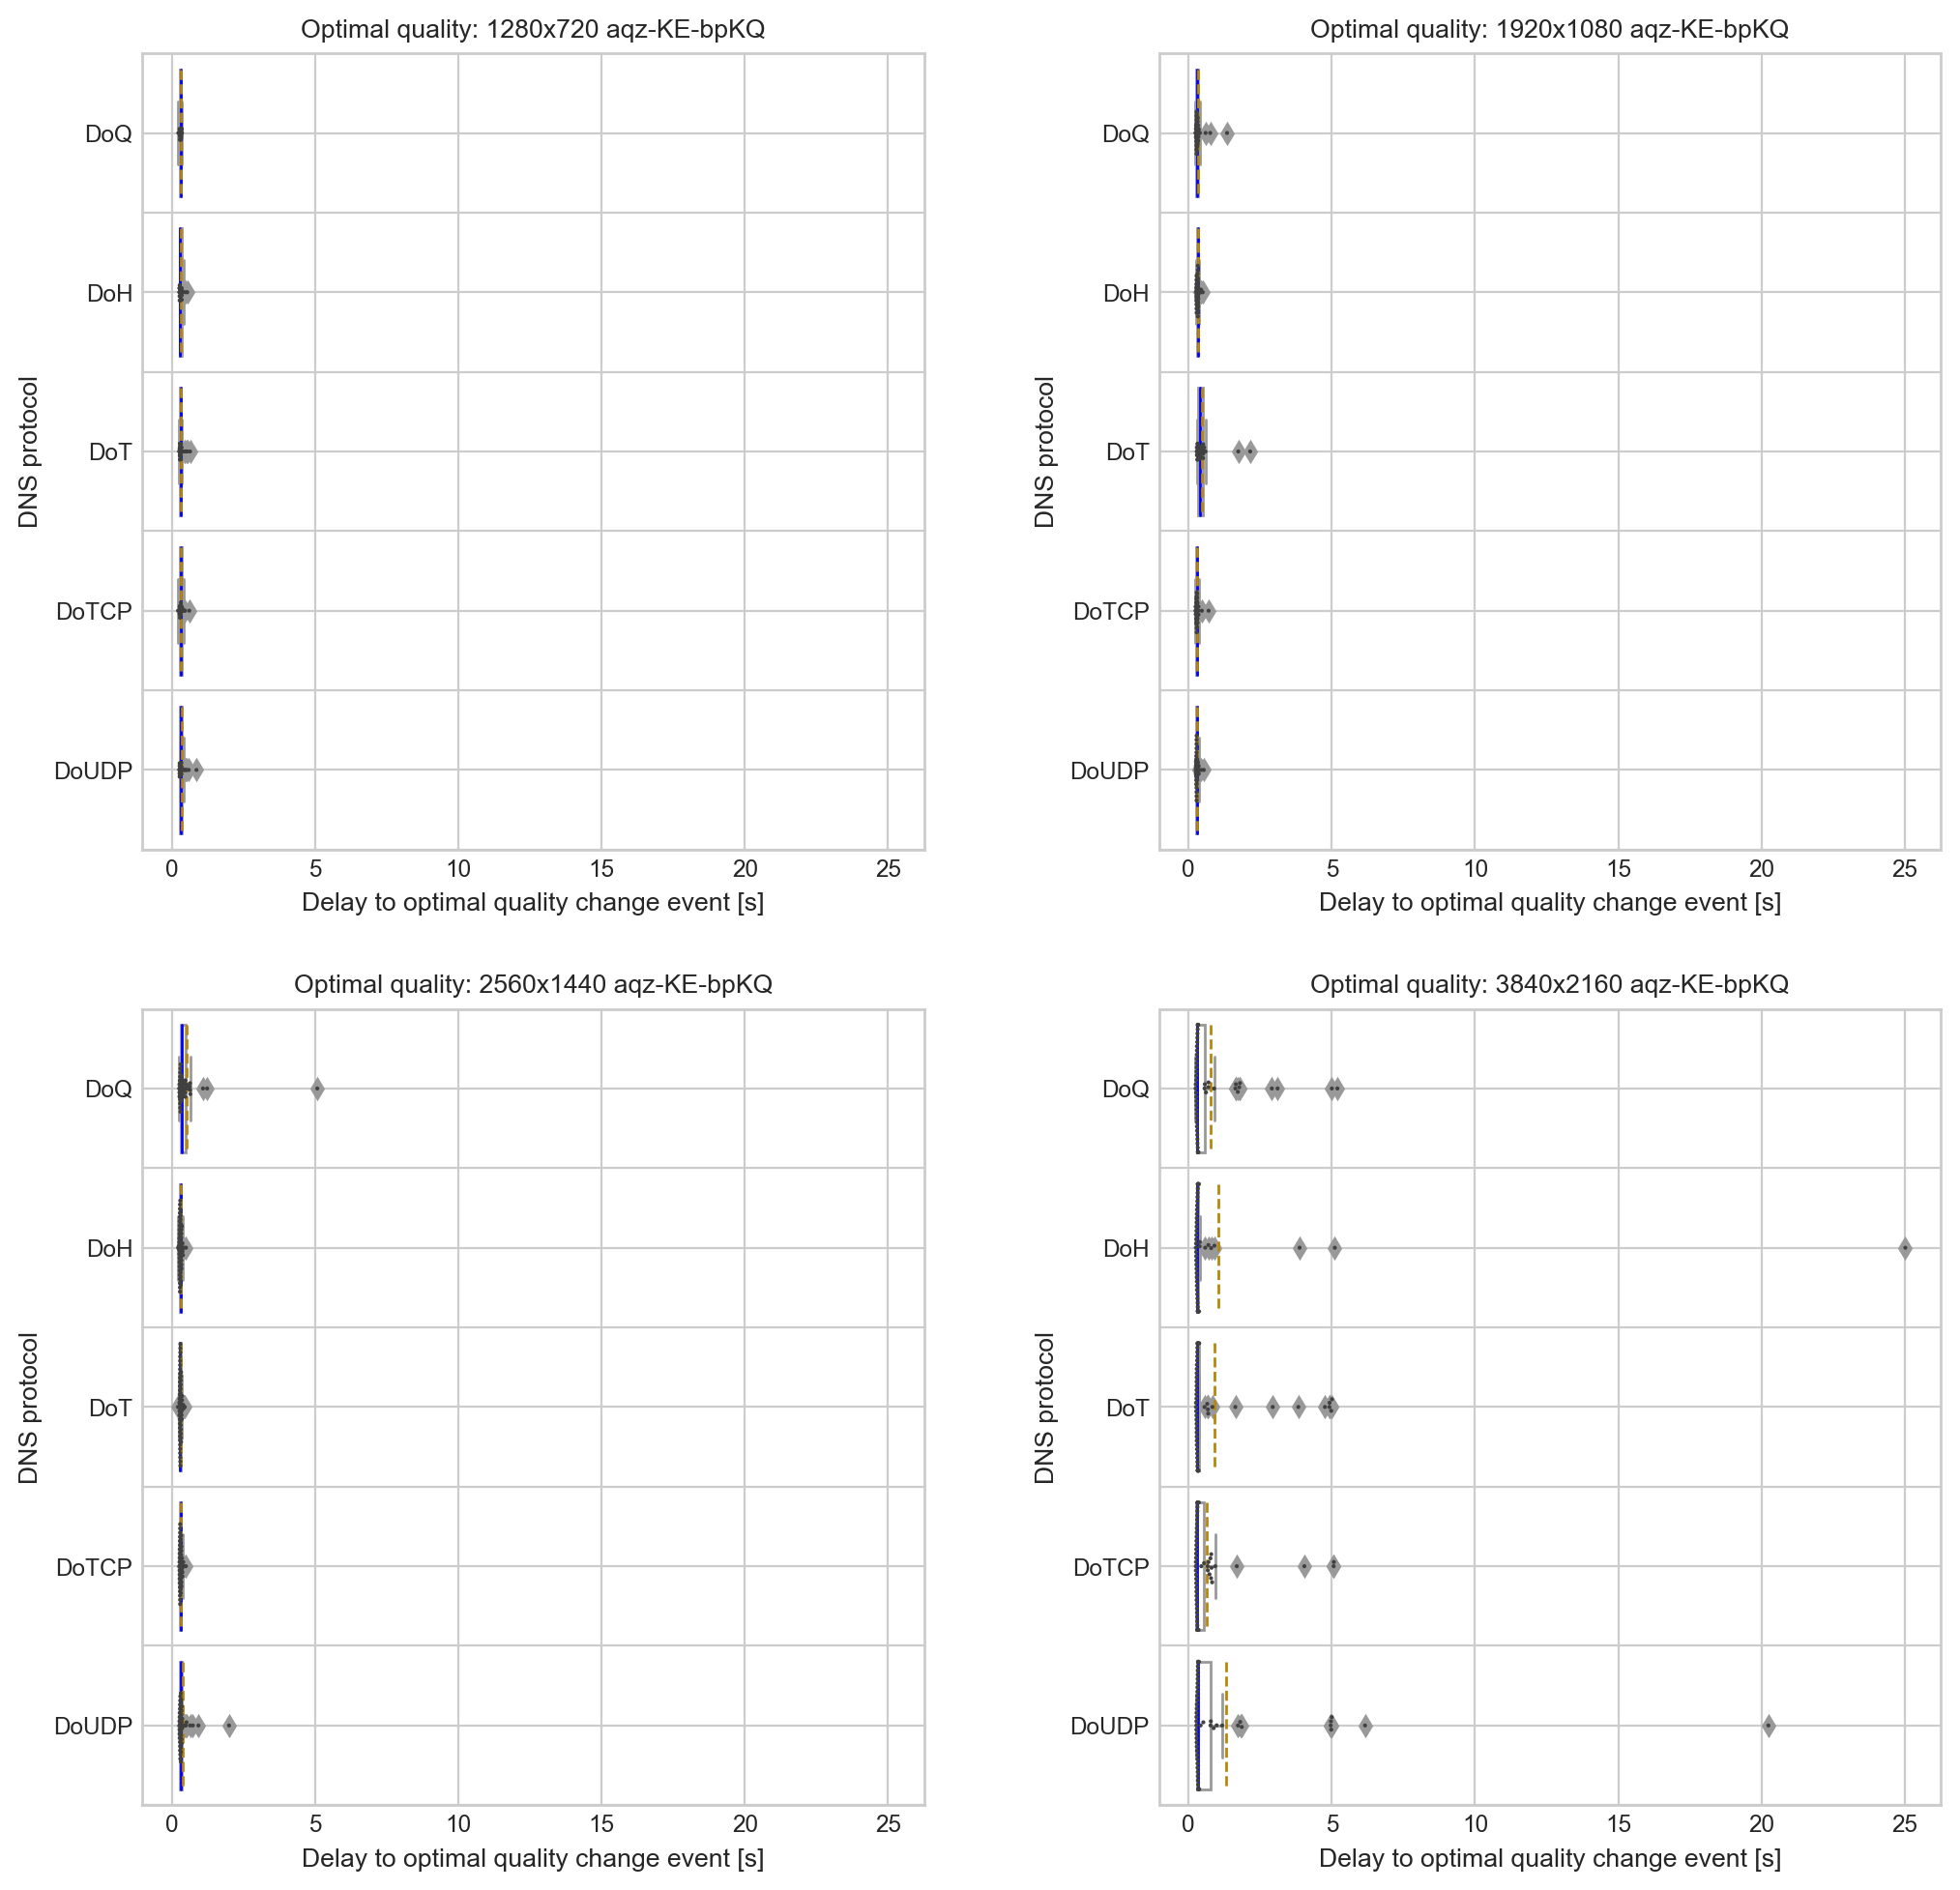

In [243]:
draw_boxplot_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True, False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
conn.close()